In [1]:
from dis import dis
from os import name
from platform import node
from re import L
from traceback import print_tb
import numpy as np
import math
from numpy.core.fromnumeric import ptp
from numpy.linalg import inv, det, pinv
import pandas as pd
from ete3 import Tree
from Bio import Phylo
from six import b
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
from sklearn import cluster
import misdeed
from misdeed.OmicsGenerator import OmicsGenerator
from misdeed.visualization import plot_timecourse

In [2]:
'''
leaves_num: how many tree leaves we want to populate
lowerBound: lower bound of random.uniform (included)
upperBound: upper bound of random.uniform (included)
'''
def random_tree_generator(leaves_num, lowerBound, upperBound):
  # The branch length between one node and its parent is encoded as the TreeNode.dist attribute.
  t = Tree()
  t.populate(leaves_num)
  for i in t.traverse("postorder"):
    # Not equal to root node (root node has no parent)
    if i != t:
      i.dist = round(random.uniform(lowerBound, upperBound), 2)
    else:
      pass
  leaves = []
  distance = []
  for i in t:
    leaves.append(i)
    distance.append(i.get_distance(t))
  max_distance = np.max(distance)
  for index in range(0, len(distance)):
    leaf = leaves[index]
    dist_leaf = distance[index]
    leaf.dist +=  (max_distance - dist_leaf)
  counter = 1
  for i in t:
    i.name = str(counter)
    counter += 1
  return t
# Finished

# Generate value from normal distribution
def normal_helper(mean, sigma):
  # set seed Let them be random, and test multiple time to see pattern
  return np.random.normal(mean, sigma)
# Finished

# Pass in two leaf nodes
def dist_helper(leaf1, leaf2):
  # Get their first common ancestor
  commonAncestor = leaf1.get_common_ancestor(leaf2)
  distance1 = leaf1.get_distance(commonAncestor)
  distance2 = leaf2.get_distance(commonAncestor)
  return distance1 + distance2
# Finished

In [3]:
# Input an negative value for diagonal
def Hypothesis1(tree_addr, negativeVal):
  # Load trees
  # bac_tree is the root of the tree
  bac_tree = Tree(tree_addr)
  # Go through leaves  Returns the list of terminal nodes (leaves) under this node.
  leaves = bac_tree.get_leaves()
  # We just assume that interaction matrix is not too big for numpy to handle
  interactionMatrix = np.zeros((len(leaves), len(leaves)))
  for leaf_i in range(0, interactionMatrix.shape[0]):
    for leaf_j in range(0, interactionMatrix.shape[1]):
      if leaf_i == leaf_j:
        interactionMatrix[leaf_i][leaf_j] = negativeVal
      else:
        distance_ij = dist_helper(leaves[leaf_i], leaves[leaf_j])
        interactionMatrix[leaf_i][leaf_j] = normal_helper(0, distance_ij)
  
  leaves_names = []
  for i in leaves:
    leaves_names.append(i.name)
  return interactionMatrix, leaves_names
# Finished

In [4]:
# Geo-dist sparse interaction Matrix
# We will have function to mark nodes
def Hypothesis2(tree_addr, negativeVal, sigmaFunc, P):
  '''
  Each tree node has two basic attributes used to establish its position in the tree: TreeNode.up and TreeNode.children. 
  The first is a pointer to parent's node, while the later is a list of children nodes.

  TreeNode.dist	stores the distance from the node to its parent (branch length).
  '''
  # Load trees
  # bac_tree is the root of the tree
  bac_tree = Tree(tree_addr)
  nodes = []
  # Traverse all nodes
  for i in bac_tree.traverse("postorder"):
    nodes.append(i)
  interactionMatrix = np.zeros((len(nodes), len(nodes)))
  # If value is zero, no updates happen and if non zero, how many times updated
  recordMatrix = np.zeros((len(nodes), len(nodes)))
  # Only iterate through the upper triangle, and update the lower and the upper triangle at the same time.
  for i in range(0, interactionMatrix.shape[0]):
    for j in range(i, interactionMatrix.shape[1]):
      if i == j:
        interactionMatrix[i][j] = negativeVal
        recordMatrix[i][j] += 1
      else:
        # If element is off-diagonal, we update interactionMatrix[i][j] and interactionMatrix[j][i] at the same time
        # If recordMatrix[i][j] == 0, we also know that recordMatrix[j][i] == 0.
        if recordMatrix[i][j] == 0:
          # If distance < 0, we do not care about its distance
          distance = -1
          if nodes[i].up == nodes[j]:
            distance = nodes[i].dist
          elif nodes[j].up == nodes[i]:
            distance = nodes[j].dist
          else:
            pass
          if distance < 0:
            pass
          else:
            # 1-D array of length 2
            mean = np.array([0, 0])
            sigma = sigmaFunc(distance)
            # 2-D array of 2 X 2
            cov = sigma * np.array([[1, P],[P, 1]])
            interactionMatrix[i][j], interactionMatrix[j][i] = np.random.multivariate_normal(mean, cov)
            recordMatrix[i][j] += 1
            recordMatrix[j][i] += 1
        else:
          pass
  
  return interactionMatrix, nodes
# Finished

In [5]:
# Each cluster is a class
class Cluster:
  def __init__(self, indexVal, rootNode):
    self.indexVal = indexVal
    self.root = rootNode
    self.leaves = []

  def addleaves(self, leaf):
    self.leaves.append(leaf)
  
  def get_leaf_cluster(self):
    leaf_cluster = {}
    leaf_cluster["Index"] = self.indexVal
    leaf_cluster["Root"] = self.root
    leaf_cluster["Nodes"] = self.leaves
    return leaf_cluster
# Finished

'''Sigma is proportional to each distance computed'''
# Sigma functions for the same cluter
# Parameters are one Cluster objects
def sigma_cluster1(cluster1, proportionFunc1, operations1, backup):
  if len(cluster1.leaves) == 1:
    return backup
  if operations1 == 1 or operations1 == 2:
    tmp_dist = []
    for i in range(0, len(cluster1.leaves)-1):
      for j in range(i+1, len(cluster1.leaves)):
        node_i = cluster1.leaves[i]
        node_j = cluster1.leaves[j]
        tmp_dist.append(node_i.get_distance(node_j))
    # non-zero minimum pairwise distance
    if operations1 == 1:
      dist = min(tmp_dist)
    # maximum pairwise distance
    else:
      dist = max(tmp_dist)
  # distance between random pair
  else:
    index1 = random.randint(0, len(cluster1.leaves)-1)
    index2 = random.randint(0, len(cluster1.leaves)-1)
    while index2 == index1:
      index2 = random.randint(0, len(cluster1.leaves)-1)
    dist = cluster1.leaves[index1].get_distance(cluster1.leaves[index2])
  sigma = proportionFunc1(dist)
  return sigma


# Sigma functions for two different clusters
# Parameters are two class Cluster objects
def sigma_cluster2(cluster1, cluster2, proportionFunc2, operations2):
  # distance between root nodes
  if operations2 == 1:
    root1 = cluster1.root
    root2 = cluster2.root
    dist = root1.get_distance(root2)
  elif operations2 == 2 or operations2 == 3:
    tmp_dist = []
    for i in cluster1.leaves:
      for j in cluster2.leaves:
        tmp_dist.append(i.get_distance(j))    
    # minimum pairwise distance
    if operations2 == 2:
      dist = min(tmp_dist)
    # maximum pairwise distance
    else:
      dist = max(tmp_dist)
  # distance between random pair
  else:
    index1 = random.randint(0, len(cluster1.leaves)-1)
    index2 = random.randint(0, len(cluster2.leaves)-1)
    dist = cluster1.leaves[index1].get_distance(cluster2.leaves[index2])
  sigma = proportionFunc2(dist)
  return sigma


# Stable self interaction within a cluster
'''
C:
    Float in (0,1]: Sparsity parameter. Higher C = less sparse.
d:
    Float. Negative self-interaction size. If set to None/default, it will be computed automatically as sigma - sqrt(n * C) + 1.
sigma:
    Float. Variance used to generate multivariate normal covariance matrix.
rho:
    Float in [-1, 1]. Correlation term of covariance matrix. Higher rho = positive connectance = mutualism =
    harder to stabilize. Lower rho = predator-prey--type relationships = easier to stabilize.

return computed d value
'''
# Compute d value
def d_computation(C, rho, n, cluster1, proportionFunc1, operations1, backup):
  sigma = sigma_cluster1(cluster1, proportionFunc1, operations1, backup)
  d = sigma * np.sqrt(n * C) * (1 + rho) + 1
  return d
# Finished

'''
cluster_level allow users to define cutting depth
sigma_cluster1,: sigma function for the same cluster
sigma_cluster2: sigma function for two differnt clusters
'''
def Hypothesis3(tree_addr, cluster_level, C, rho, P, proportionFunc1, operations1, proportionFunc2, operations2, backup):
  # Load trees
  # bac_tree is the root of the tree
  bac_tree = Tree(tree_addr)

  # Get all leaves in bac_tree
  all_leaves = []
  for l in bac_tree:
    all_leaves.append(l)
  
  '''
  The height of a node is the length of the longest downward path to a leaf from that node.
  The height of the root is the height of the tree. The depth of a node is the length of the path to its root
  '''
  # Traverse all nodes and obtain their depths
  # We only care about nodes which has depth larger that cluster level
  nodes = []
  # We wish to preserve the orders of leaves, left first then right
  for i in bac_tree.traverse("postorder"):
    if i.get_distance(bac_tree) > cluster_level:
      # Below the threshold
      nodes.append(i)
    else:
      pass
  
  # We are looking for frontier nodes
  frontier = []
  # frontier nodes: its distance to root is larger than threshold while its parent's distance to the root 
  # is smaller than threshold
  for j in nodes:
    parent = j.up
    if parent.get_distance(bac_tree) <= cluster_level:
      frontier.append(j)
    else:
      pass
  
  #=======================================================================
  # We need to examine whether leaves of frontiers generated all leaves of this tree
  frontier_update = []
  # Get all leaves
  root_leaves = bac_tree.get_leaves()
  root_leaves_copy = root_leaves.copy()
  # Since frontier is ordered, we can do this
  for node in frontier:
    # Get leaves that can be generated by this frontier node
    tmp_leaf = node.get_leaves()
    for leaves in root_leaves:
      # If this leaf is in this list
      if leaves in tmp_leaf:
        frontier_update.append(node)
        for tl in tmp_leaf:
          root_leaves_copy.remove(tl)
        break
      else:
        frontier_update.append(leaves)
        root_leaves_copy.remove(leaves)
    
    root_leaves = root_leaves_copy.copy()
  
  # If some leaves remain, we add them into frontier
  for tmpL in root_leaves:
    frontier_update.append(tmpL)
  
  frontier = frontier_update
  #====================================================================
  # Above is OK
  # print(frontier)
  # Record nodes for each cluster
  # List ot clusters - each frontier represent one cluster
  clusters = []
  # Key is leaf, value is the index of the cluster
  leaf_cluster = {}
  reordered_node = []
  count = 0
  # f is a node in frontier
  for f in frontier:
    newCluster = Cluster(count, f)
    for leaf in f:
      newCluster.addleaves(leaf)
      reordered_node.append(leaf)
      leaf_cluster[leaf] = count
    
    clusters.append(newCluster)
    count += 1
  
  # reordered_node has order left to right

  # Pre-computed self interaction values for each cluster
  self_interactionVals = []
  for cluster1 in clusters:
    tmp = - d_computation(C, rho, len(clusters), cluster1, proportionFunc1, operations1, backup)
    self_interactionVals.append(tmp)
  # self_interactionVals order by clusters 
  # leaf_cluster value index clusters and self_interactionVals

  # Pre-computed inter-clusters interaction value (cluster-wise)
  inter_clusterVals = {}
  for C1 in range(0, len(clusters)-1):
    for C2 in range(C1+1, len(clusters)):
      sigmaInter = sigma_cluster2(clusters[C1], clusters[C2], proportionFunc2, operations2)
      # 1-D array of length 2
      mean = np.array([0, 0])
      # 2-D array of 2 X 2
      cov = sigmaInter * np.array([[1, P], [P, 1]])
      val1, val2 = np.random.multivariate_normal(mean, cov)
      inter_clusterVals[(clusters[C1], clusters[C2])] = val1
      inter_clusterVals[(clusters[C2], clusters[C1])] = val2
  
  # What should interaction matrix looks like if some leaves do not belong to any cluster? -- they are clusters themselves

  interactionMatrix = np.zeros((len(reordered_node),len(reordered_node)))
  for i in range(0, interactionMatrix.shape[0]):
    for j in range(0, interactionMatrix.shape[1]):
      # We care about diagonal cluster
      leaf_i = reordered_node[i]
      leaf_j = reordered_node[j]
      # In the same cluster
      if leaf_cluster[leaf_i] == leaf_cluster[leaf_j]:
        interactionMatrix[i][j] = self_interactionVals[leaf_cluster[leaf_i]]
      # Not in the same cluster
      else:
        interactionMatrix[i][j] = inter_clusterVals[(clusters[leaf_cluster[leaf_i]], clusters[leaf_cluster[leaf_j]])]
  
  return interactionMatrix, reordered_node
# Finished

In [6]:
# Null distribution
def Hypothesis4(tree_addr, sigma, negativeVal):
  # Load trees
  # bac_tree is the root of the tree
  bac_tree = Tree(tree_addr)
  # Go through leaves  Returns the list of terminal nodes (leaves) under this node.
  leaves = bac_tree.get_leaves()
  # We just assume that interaction matrix is not too big for numpy to handle
  interactionMatrix = np.zeros((len(leaves), len(leaves)))
  for i in range(0, interactionMatrix.shape[0]):
    for j in range(0, interactionMatrix.shape[1]):
      if i == j:
        interactionMatrix[i][j] = negativeVal
      else:
        interactionMatrix[i][j] = normal_helper(0, sigma)
  
  leaves_names = []
  for i in leaves:
    leaves_names.append(i.name)
  return interactionMatrix, leaves_names
# Finished

In [97]:
'''
Distance-proportion functions
'''
def inverse_distance(distance):
  return 1/distance
# Finished

def remain_distance(distance):
    return distance
# Finished
'''
Plot helper functions
'''
def matlib_matrixPlot(data, alpha):
  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(111)
  cax = ax.matshow(data)
  fig.colorbar(cax)
  ax.set_xticklabels(['']+alpha)
  ax.set_yticklabels(['']+alpha)
  plt.show()
# Finished

# Rewrite the stackoverflow post
def seaborn_plot(interactionMatrix, record, distMatrix):
  labels = []
  for i in record:
    labels.append(i.name)
  sns.set(font="monospace")
  DF = pd.DataFrame(distMatrix, index = labels, columns = labels)
  #print(DF)
  # Add labels to interaction matrix
  interactionMatrix = pd.DataFrame(interactionMatrix, index=labels, columns=labels)
  linkage = hc.linkage(sp.distance.squareform(DF), method='average', optimal_ordering= False)
  #print(interactionMatrix)
  sns.clustermap(interactionMatrix, row_linkage=linkage, col_linkage=linkage)
  plt.show()
# Finished

def distanceMatrix(treeinput):
  tree = Tree(treeinput)
  leaves = tree.get_leaves()
  distMatrix = np.zeros((len(leaves), len(leaves)))
  for i in range(0, len(leaves)):
    for j in range(0, i):
      leaf_i = leaves[i]
      leaf_j = leaves[j]
      dist = leaf_i.get_distance(leaf_j)
      distMatrix[i][j] = dist
      distMatrix[j][i] = dist
  return distMatrix, leaves

def simulation(node_size, matrix, dtV, operation):
  gen = OmicsGenerator([node_size], init_full=True)
  gen.get('n0->n0').matrix = matrix
  z,x,y = gen.generate(dt=dtV)
  if operation == 'z':
    # Numpy array
    operation = z['n0']
  elif operation == 'x':
    operation = x['n0']
  else:
    operation = y['n0']
  plot_timecourse(operation)
  plt.ylim(0, np.max(operation.sum(axis=1)))
  plt.show()
  #return operation

In [9]:
C_tree = random_tree_generator(250, 0.5, 1).write()
print(Tree(C_tree))


                     /-1
                  /-|
                 |   \-2
                 |
               /-|      /-3
              |  |   /-|
              |  |  |  |   /-4
              |  |  |   \-|
              |   \-|      \-5
              |     |
              |     |   /-6
              |      \-|
              |        |   /-7
            /-|         \-|
           |  |           |   /-8
           |  |            \-|
           |  |               \-9
           |  |
           |  |      /-10
           |  |   /-|
           |  |  |  |   /-11
           |  |  |   \-|
           |   \-|      \-12
           |     |
           |     |   /-13
           |      \-|
           |        |   /-14
           |         \-|
           |            \-15
           |
           |            /-16
           |         /-|
           |        |   \-17
           |        |
           |        |      /-18
           |      /-|   /-|
           |     |  |  |   \-19
           |     |  |  |


In [59]:
np.set_printoptions(suppress=True)
distMatrix, leaves = distanceMatrix(C_tree)

17.68
17.68
17.68
17.68
17.68
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.68
17.68
17.68
17.68
17.68
17.68
17.68
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.679999999999996
17.67999999

In [60]:
# Parameters
Constant = -1
rho = -0.5
C = 0.5
depth_leavel = 17.68/2
intra = 3
inter = 1
sigma_hp4 = 0.5

In [30]:
def eigenValVecoter(matrix):
    eigvals, eigvecs = np.linalg.eig(matrix)
    plt.scatter(np.real(eigvals), np.imag(eigvals))
    plt.xlabel('real')
    plt.ylabel('imaginary')
    #plt.xlim([-15,15])
    #plt.ylim([-15,15])
    
def plot_interaction(sample):
    fig = plt.figure(figsize=(12,12))
    plt.xlabel("time")
    plt.ylabel("species")
    plt.imshow(sample.T)
    plt.colorbar()

def plot_dieout(sample):
    sample_zeros = (sample == 0)
    sample_zerosT = sample_zeros.T
    total = 0
    die = 0
    for row in sample_zerosT:
        if True in row:
            die += 1
        total += 1
    fig = plt.figure(figsize=(12,12))
    plt.xlabel("time")
    plt.ylabel("species")
    plt.imshow(sample_zeros.T)
    return die / total

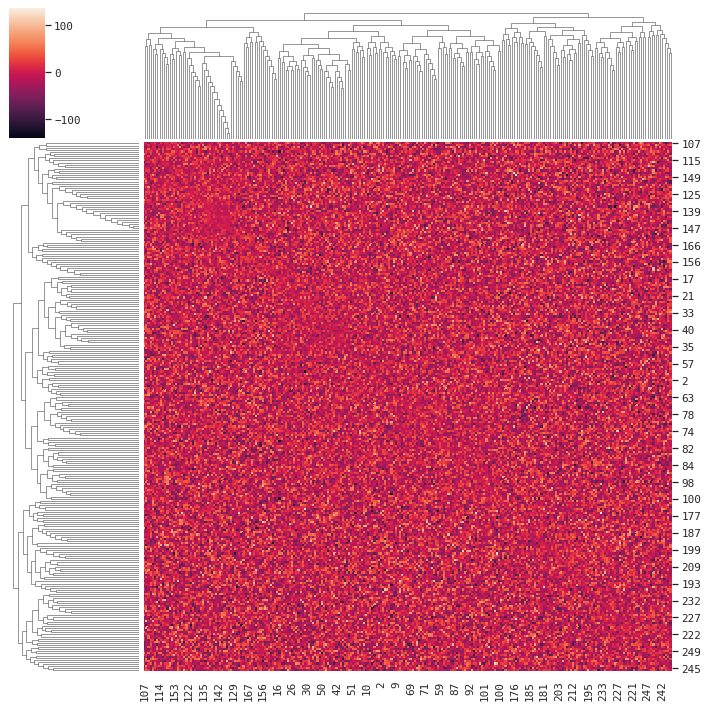

In [104]:
# Hypothesis 1
InteractionMatrix1, leaves_names1 = Hypothesis1(C_tree, Constant)
seaborn_plot(InteractionMatrix1, leaves, distMatrix)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized


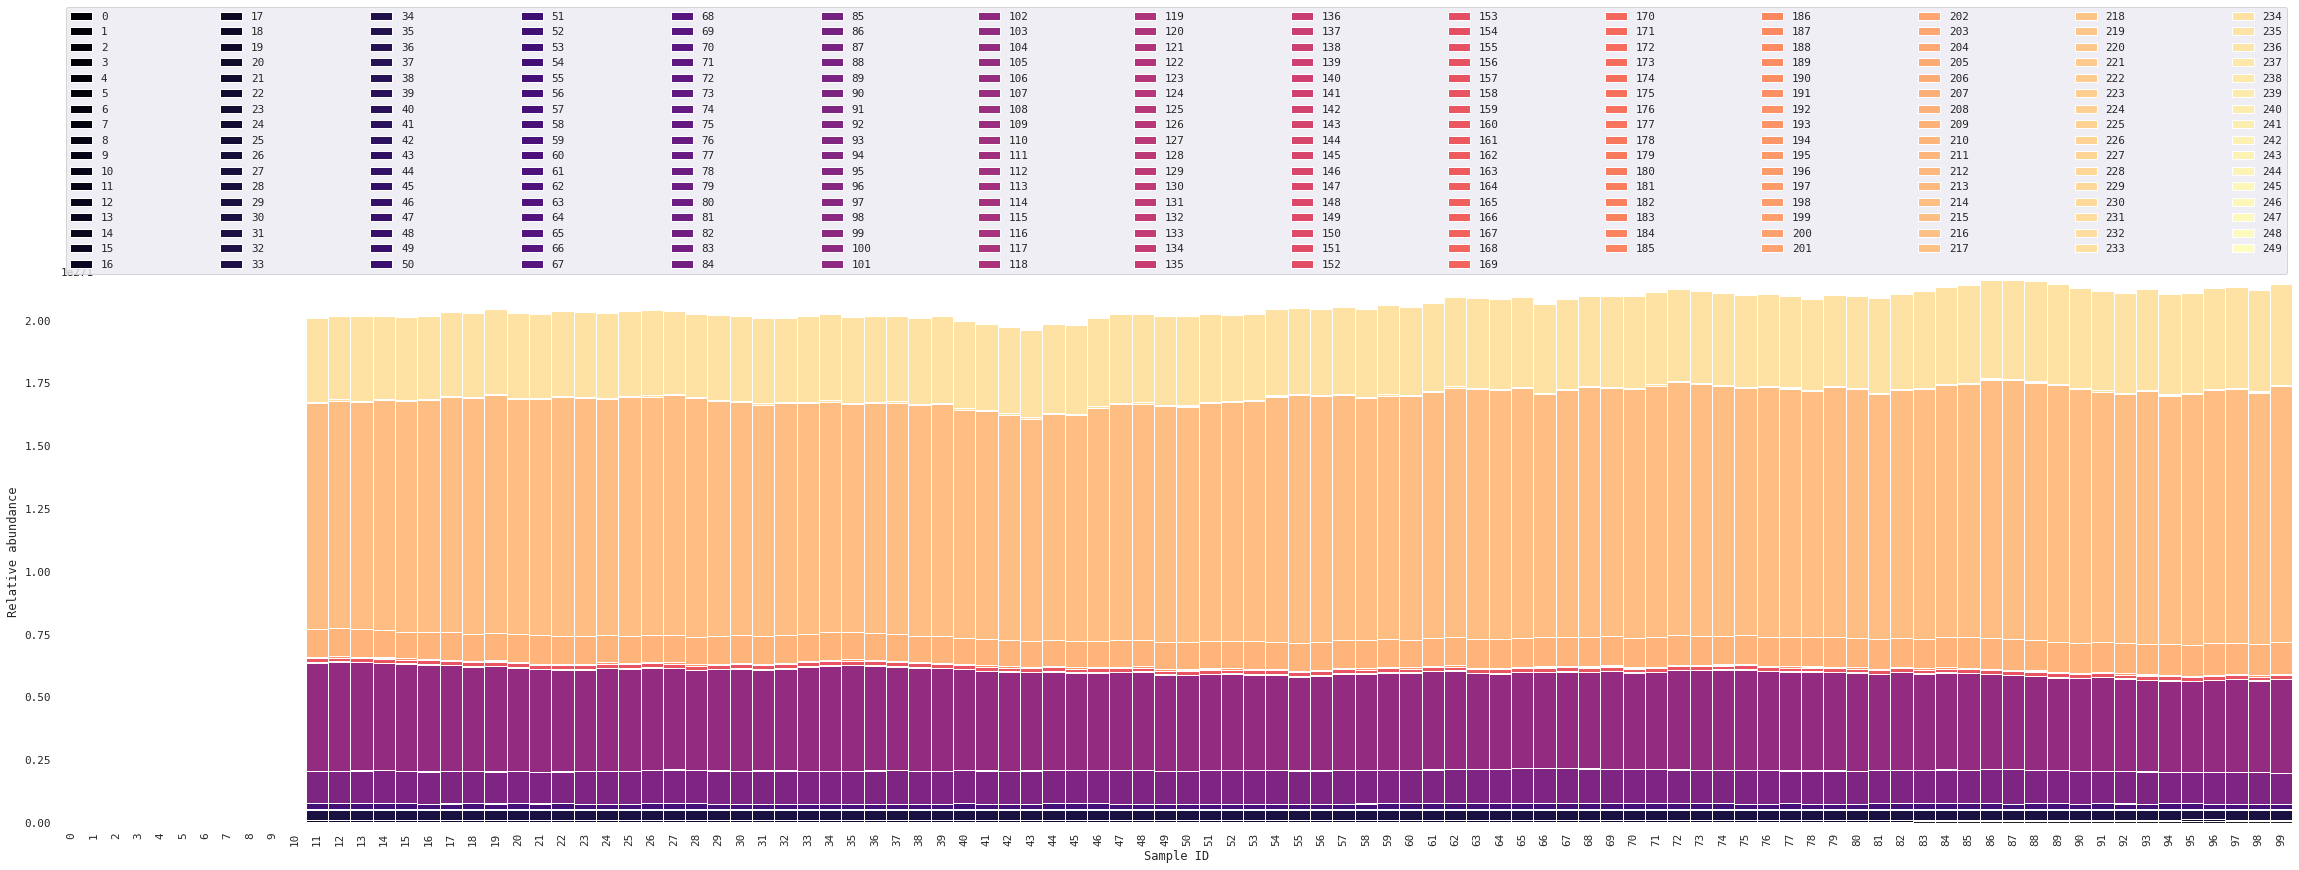

In [105]:
sample1 = simulation(len(leaves), InteractionMatrix1, 0.001, 'z')

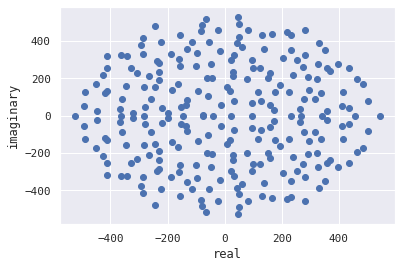

In [29]:
# Eigen value:
eigenValVecoter(InteractionMatrix1)

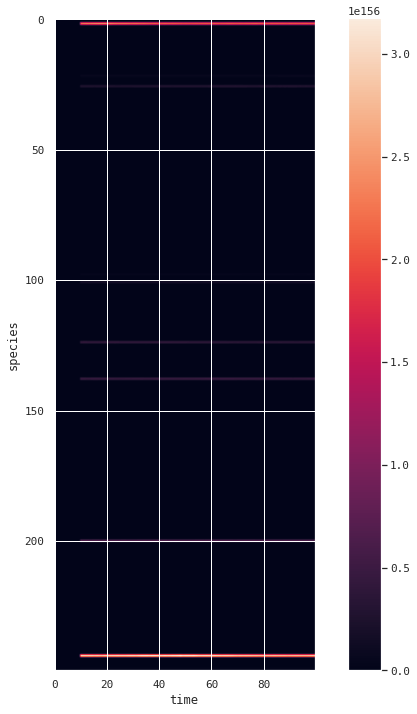

In [31]:
plot_interaction(sample1)

0.828

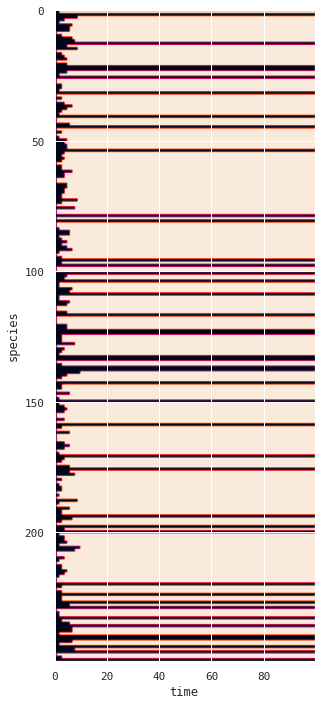

In [32]:
plot_dieout(sample1)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:25

<ipython-input-30-0506df2a79e1>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,12))


Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:25

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:25

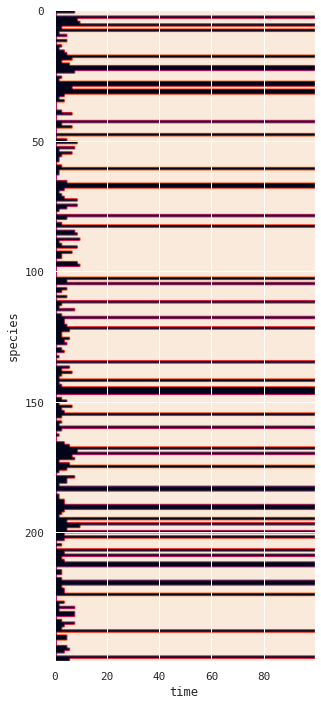

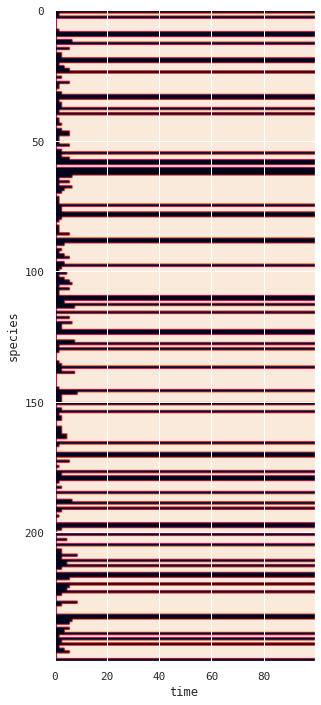

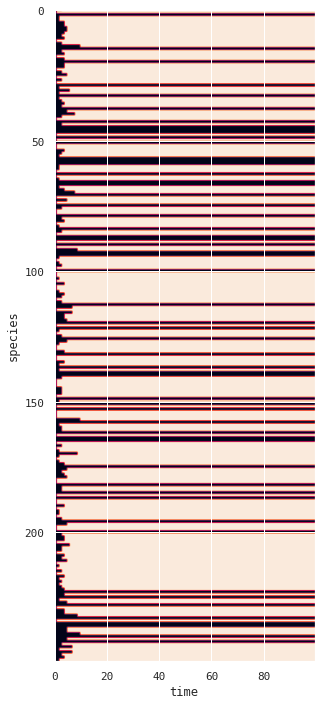

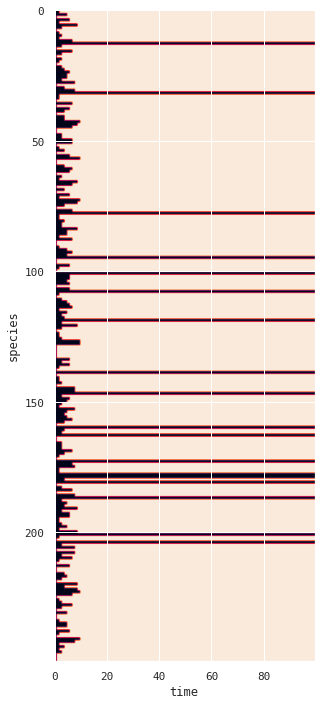

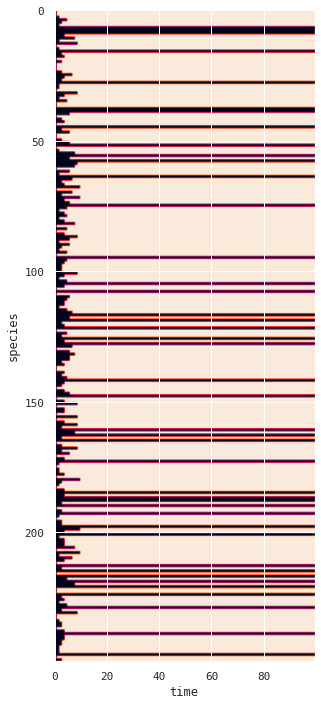

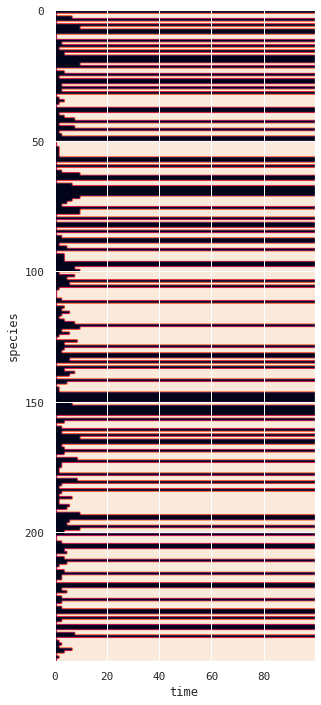

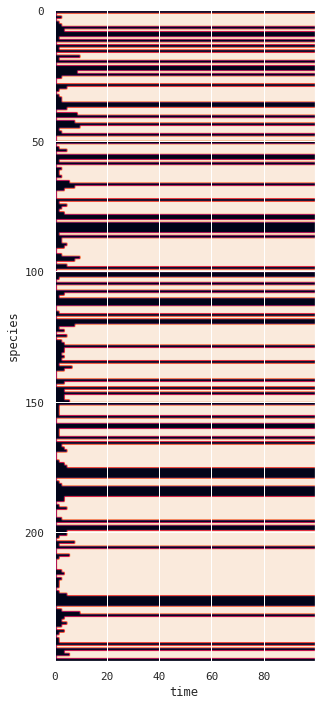

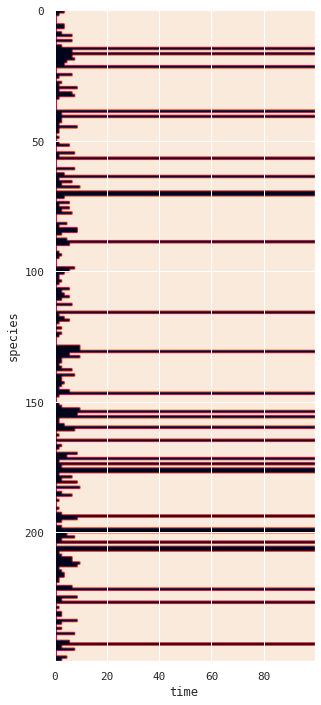

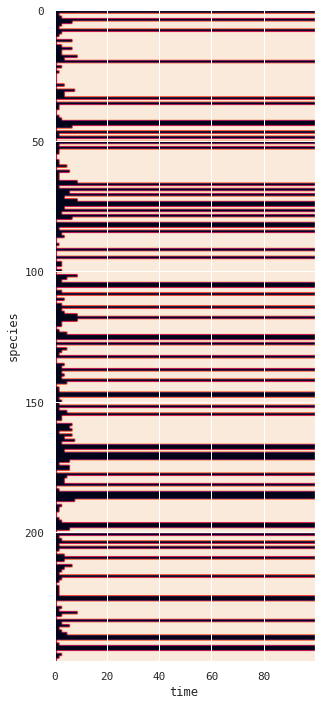

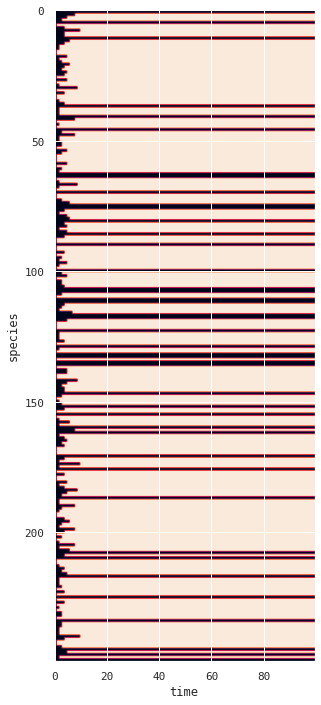

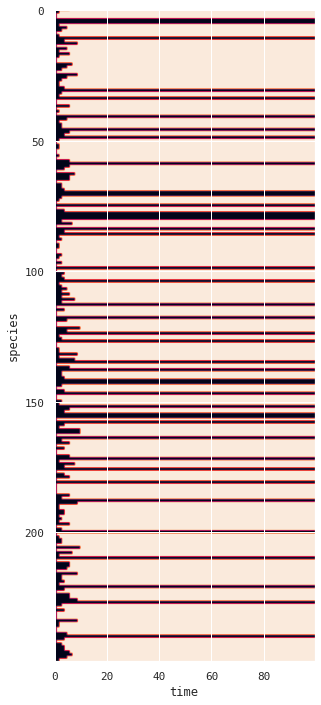

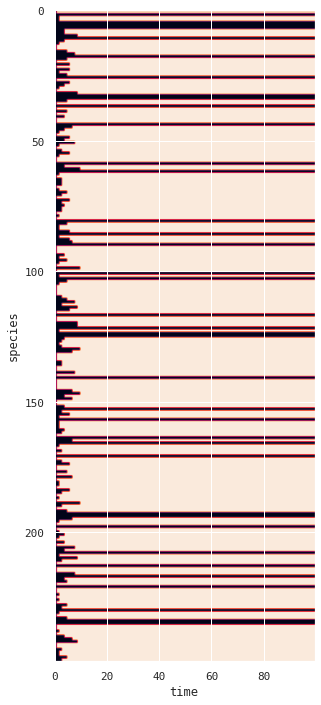

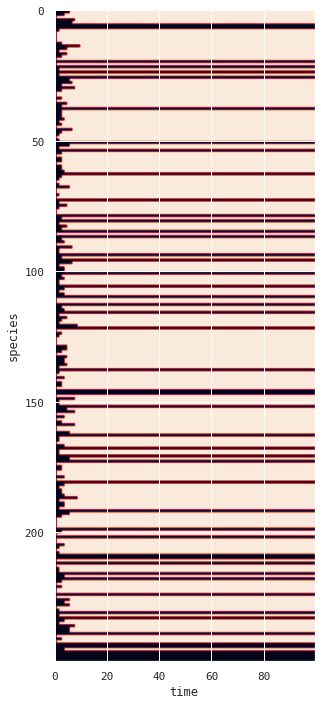

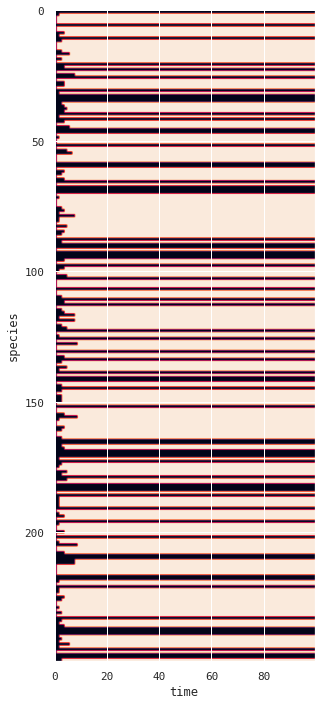

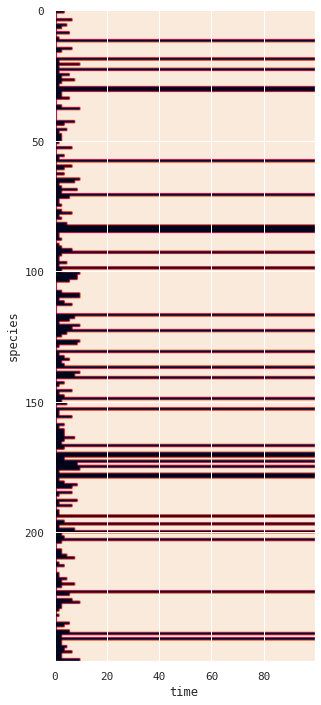

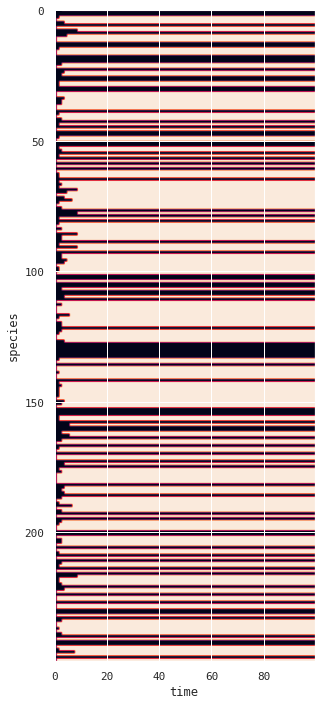

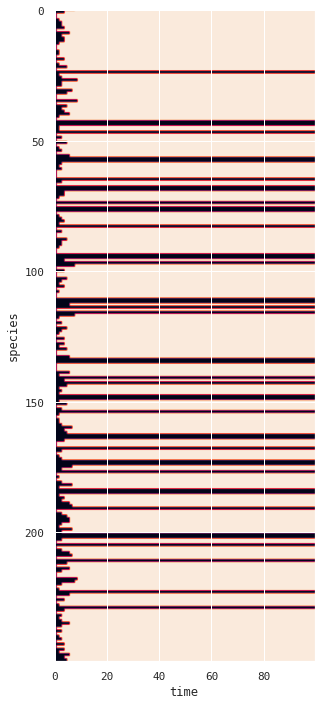

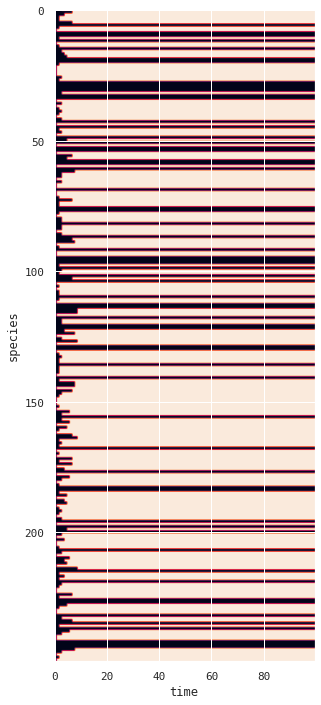

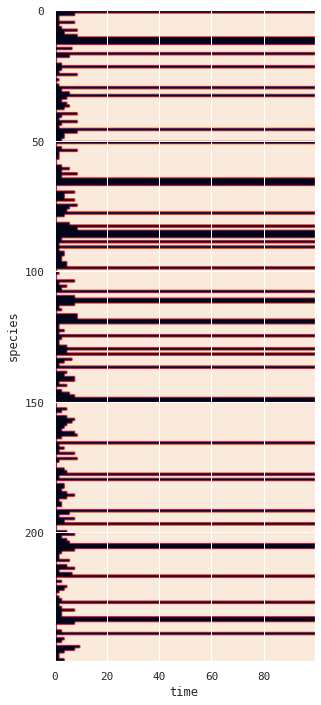

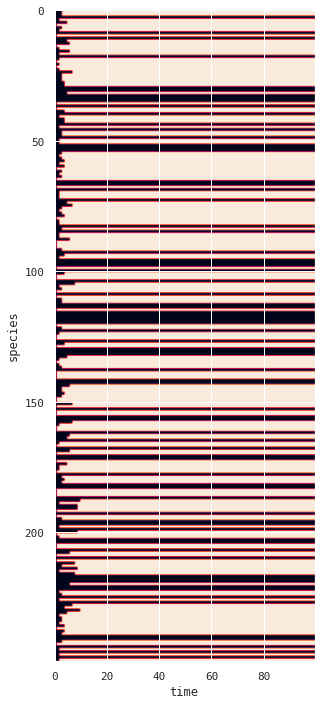

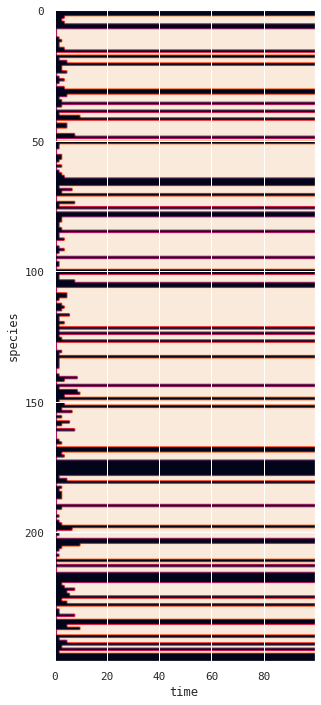

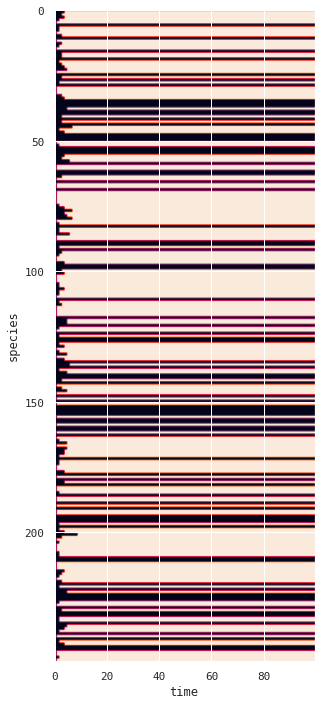

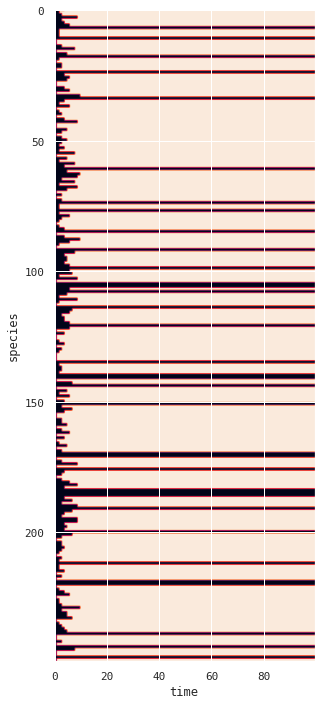

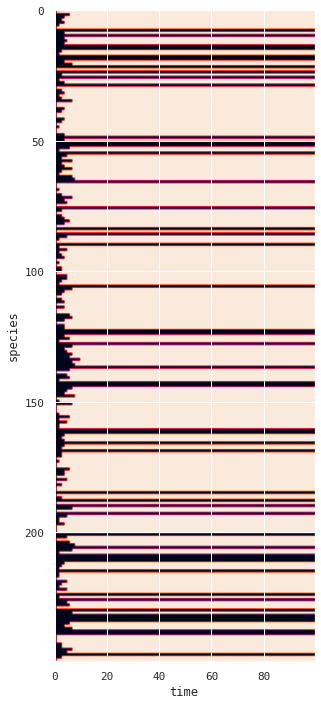

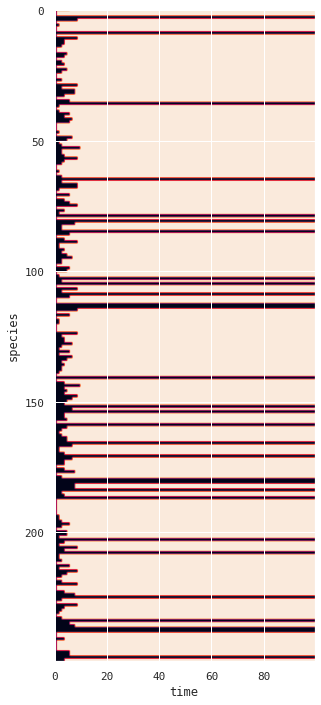

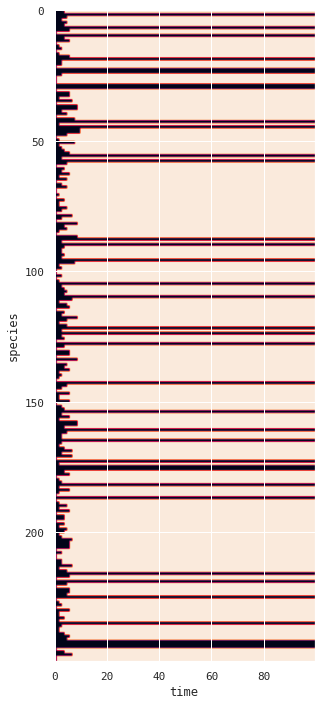

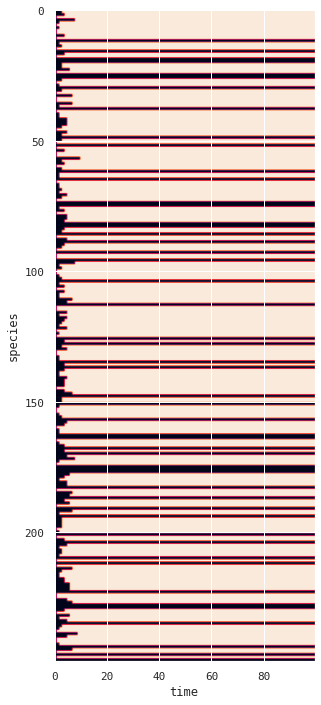

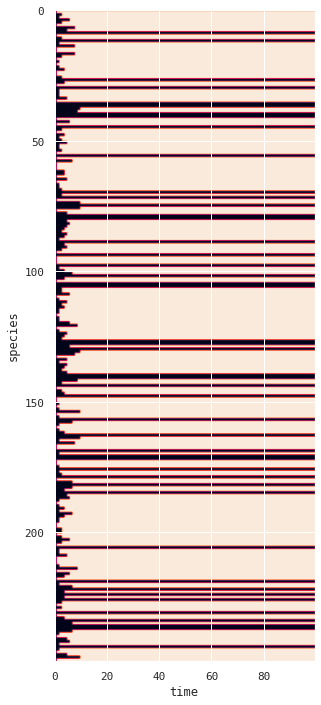

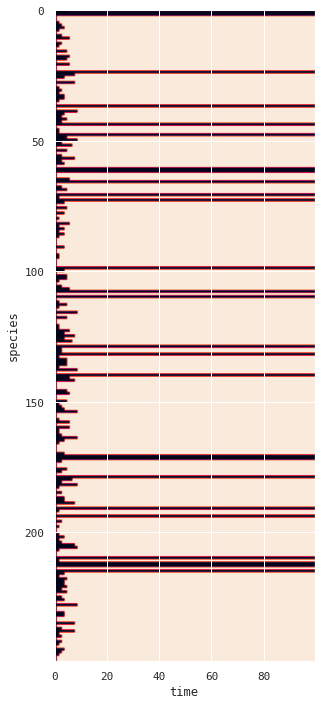

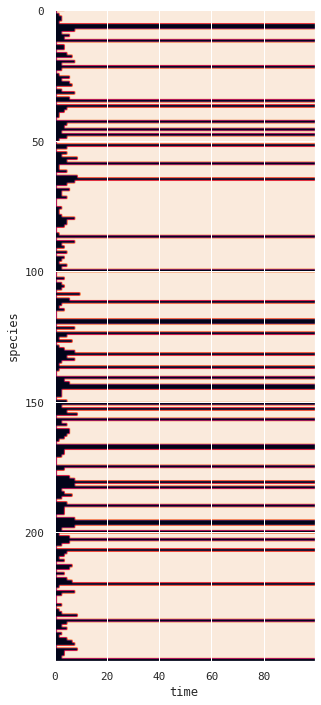

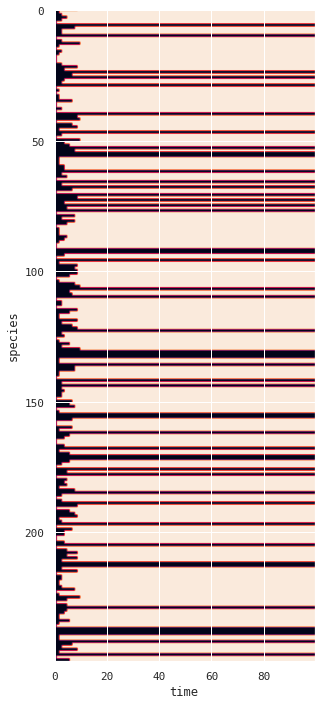

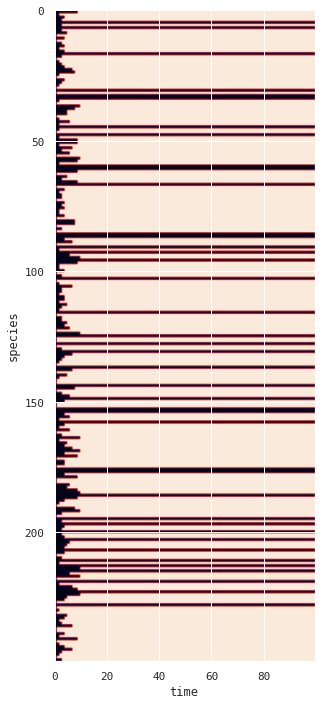

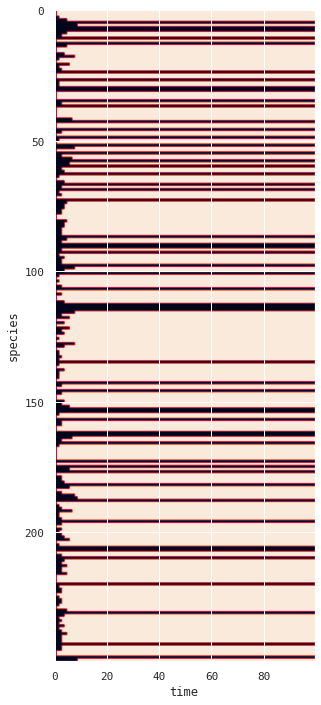

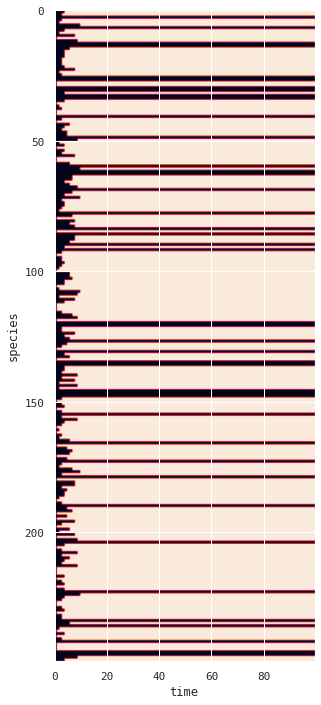

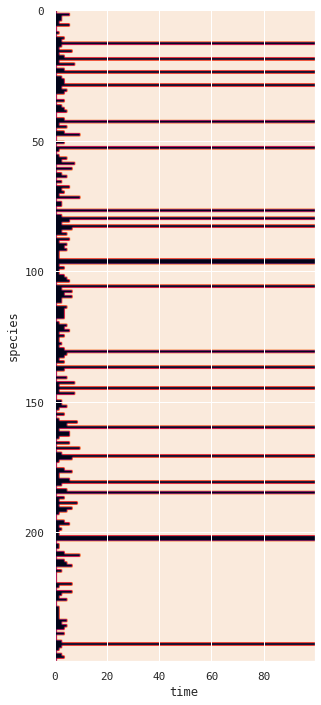

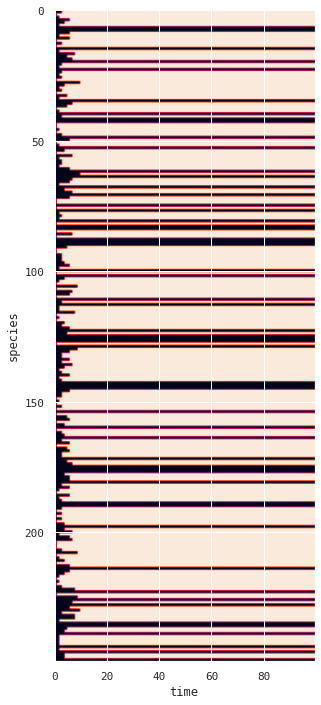

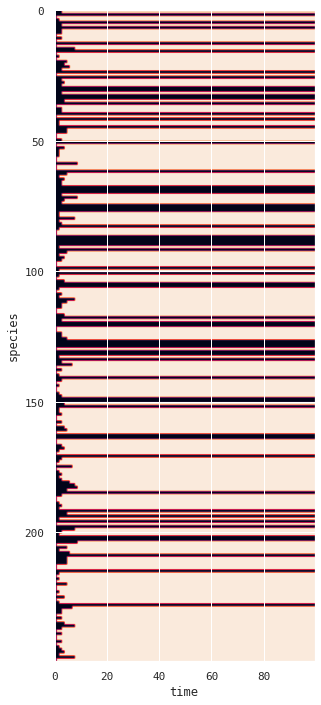

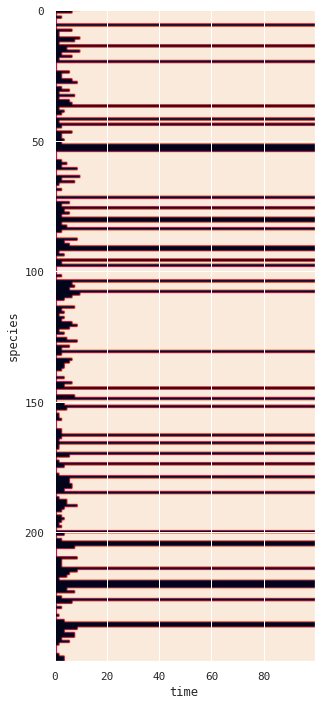

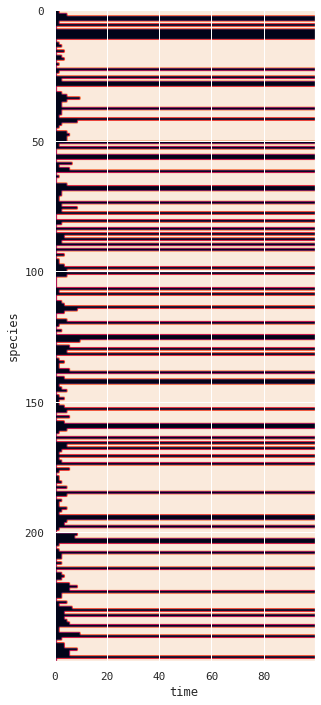

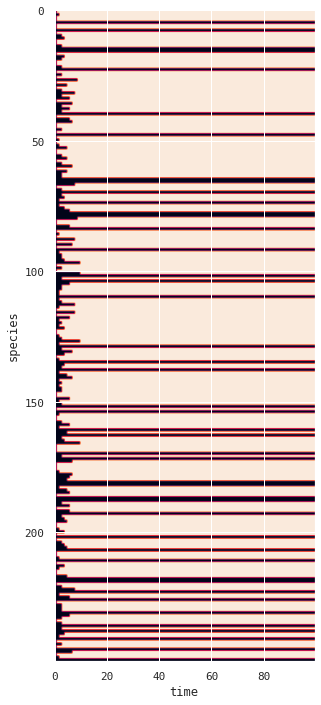

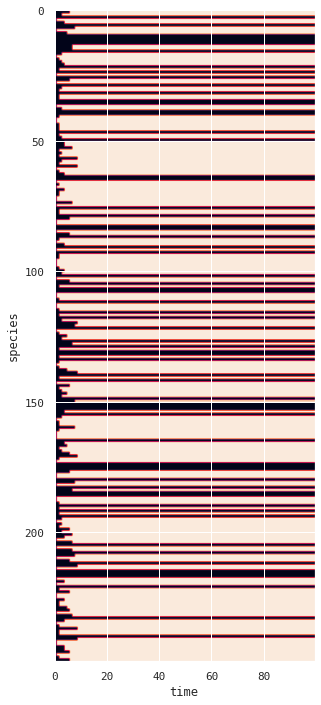

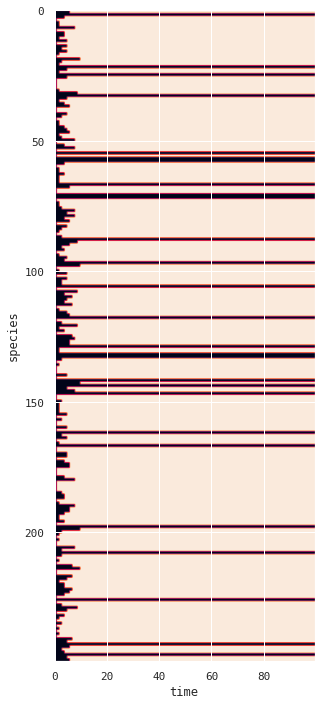

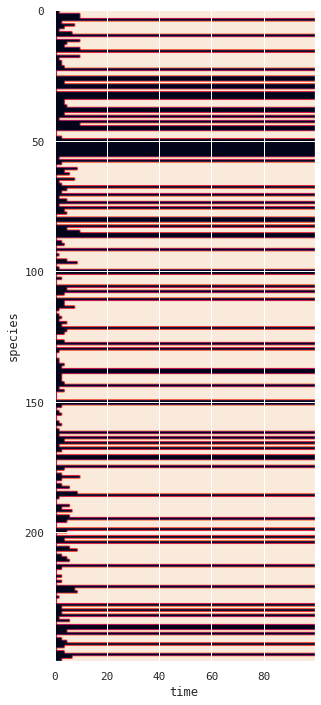

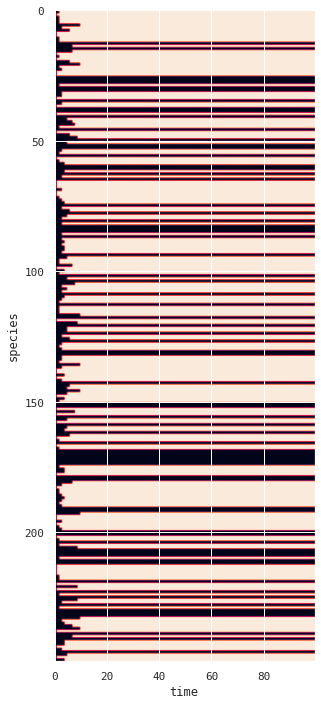

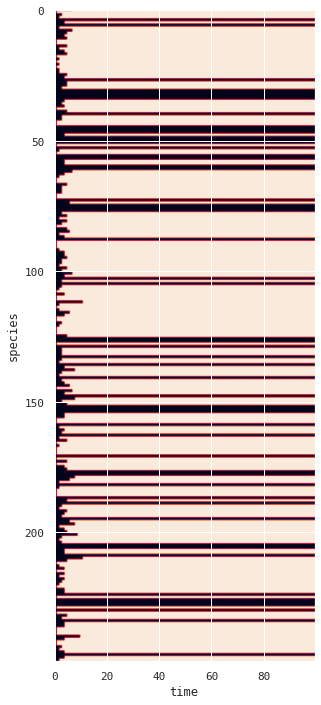

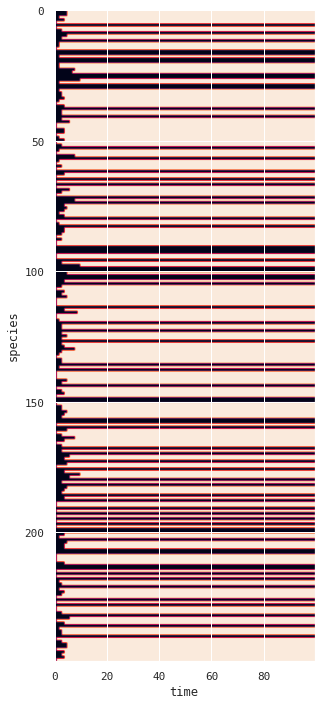

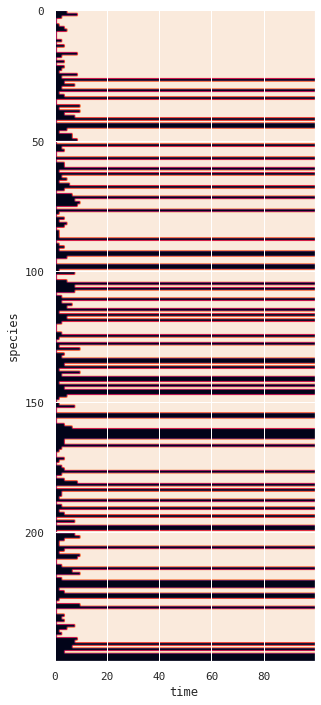

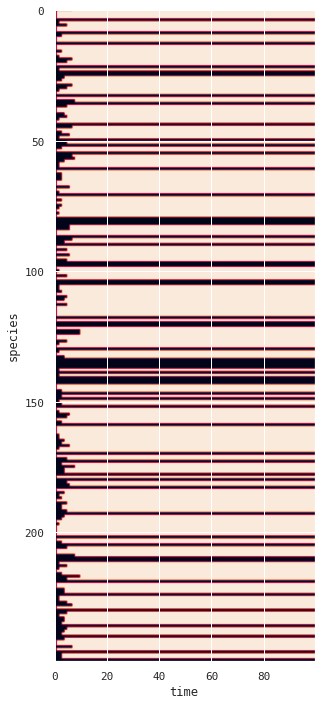

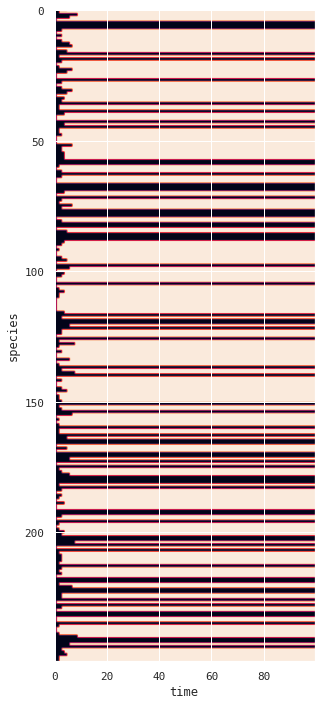

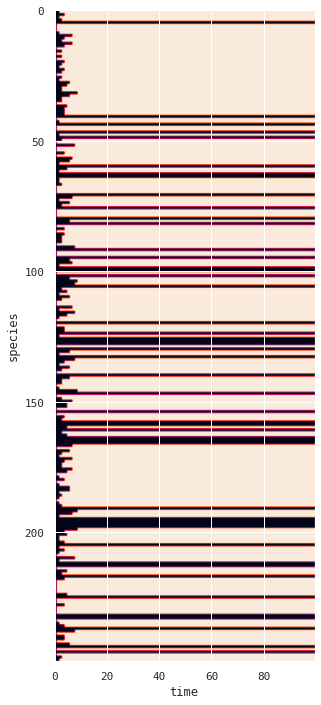

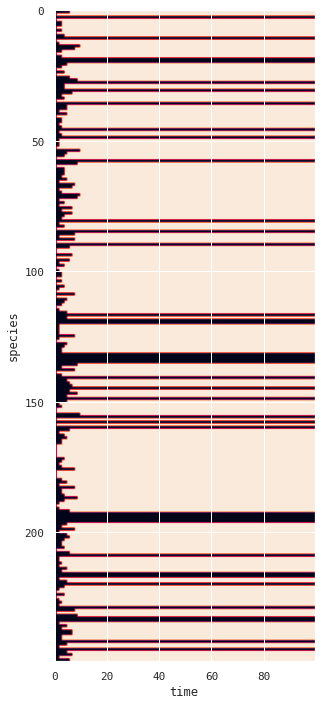

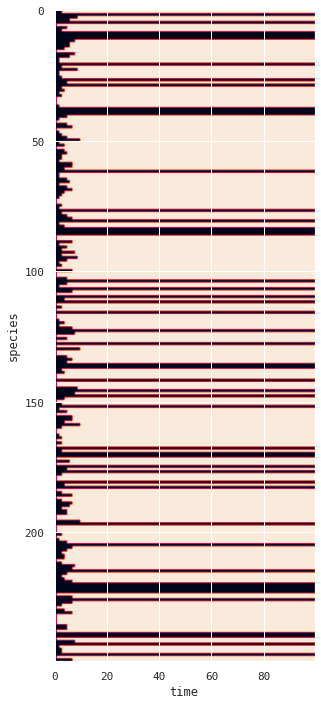

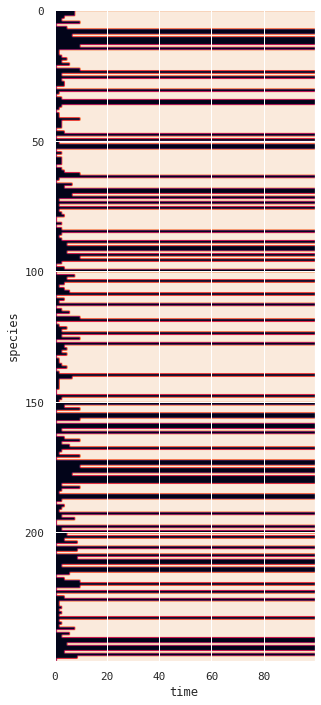

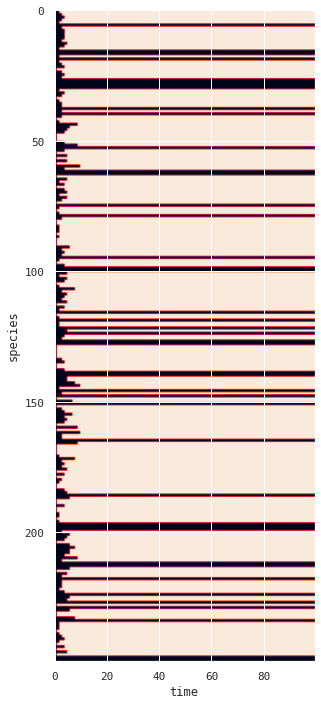

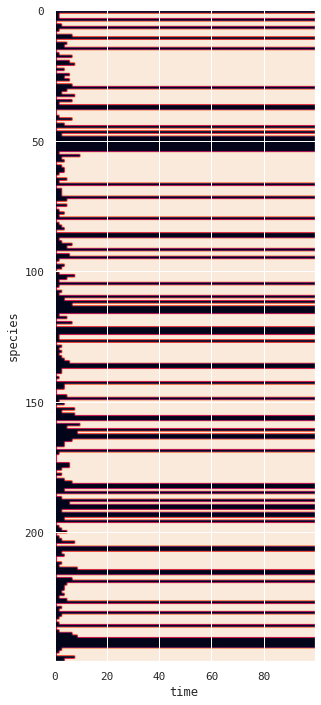

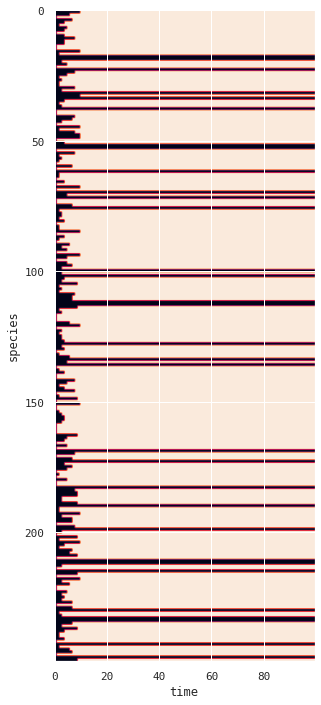

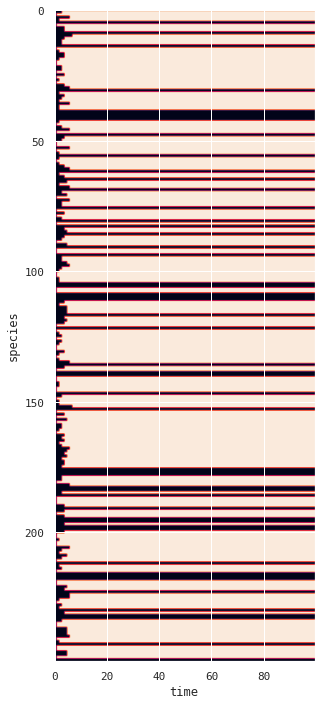

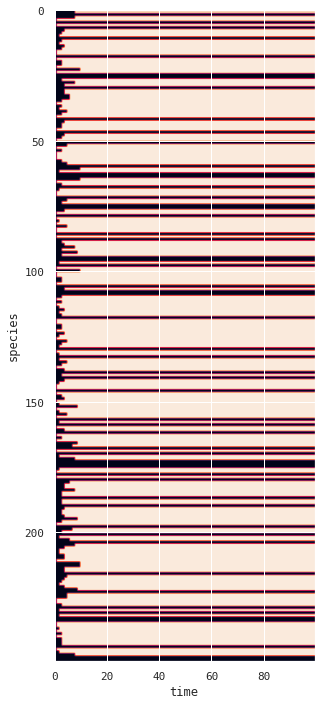

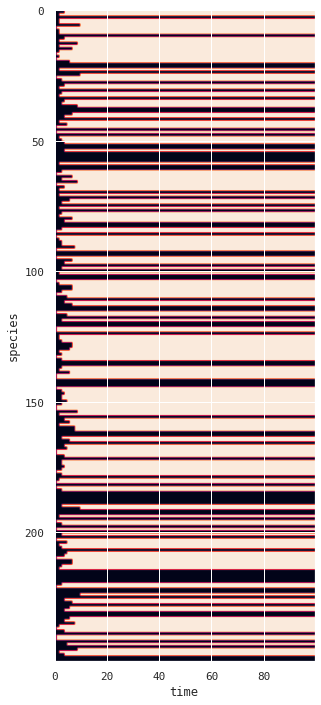

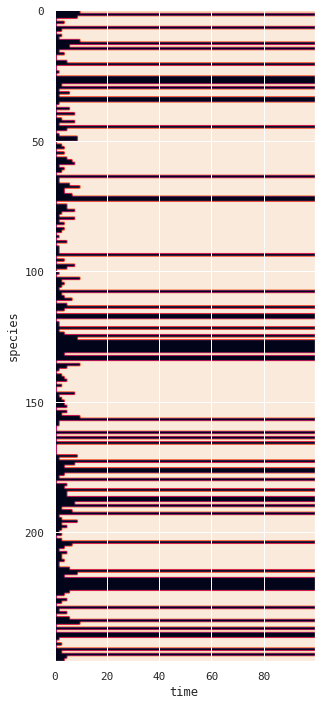

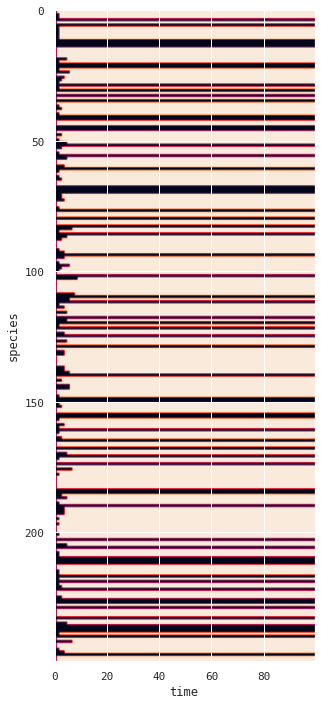

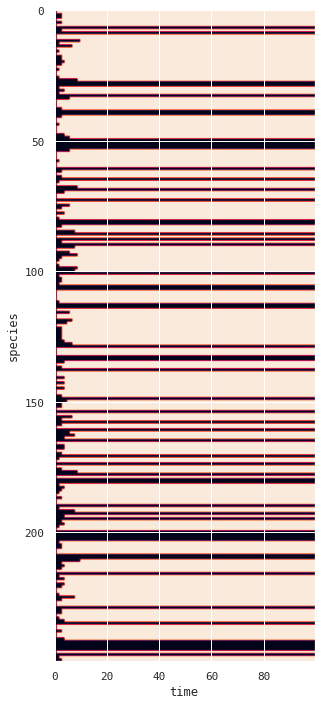

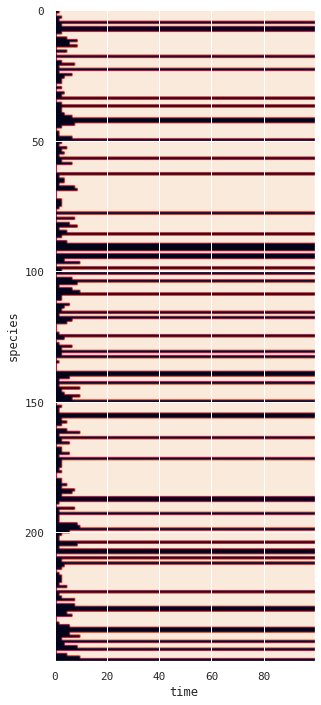

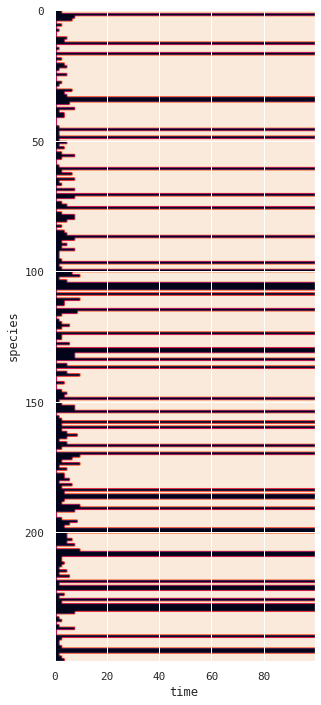

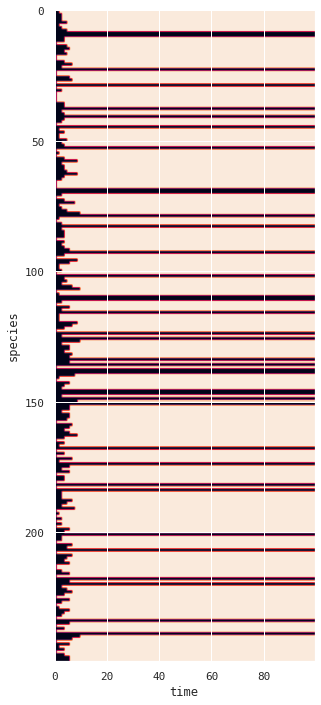

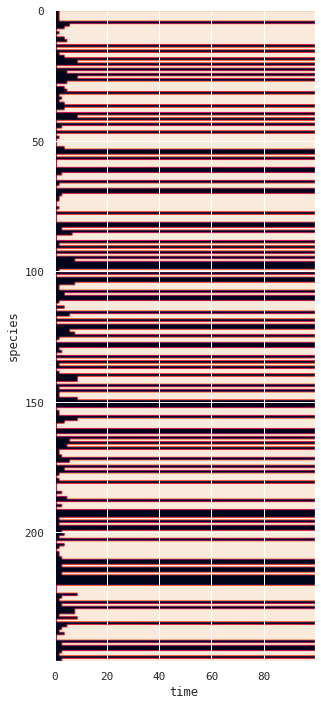

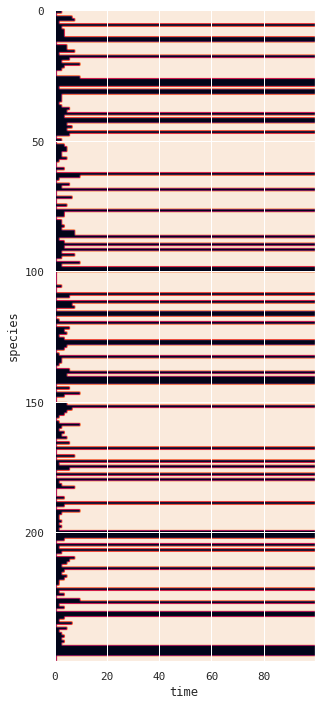

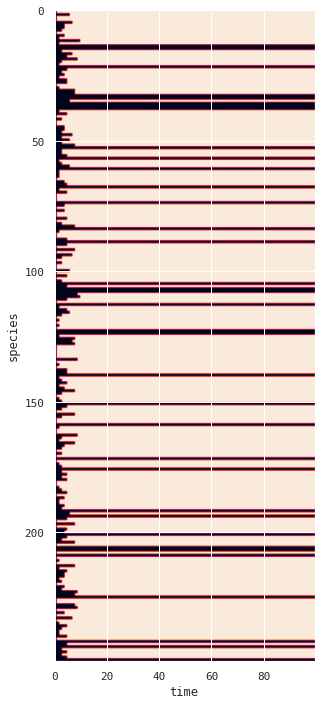

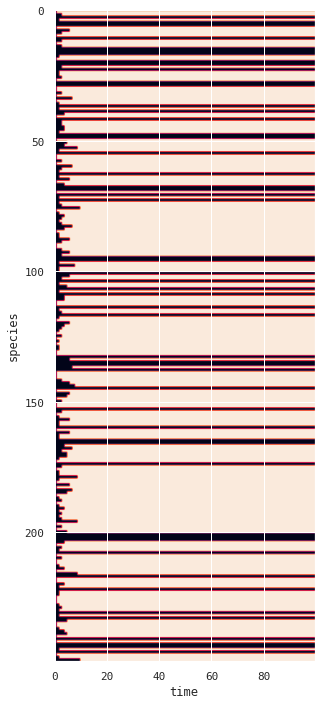

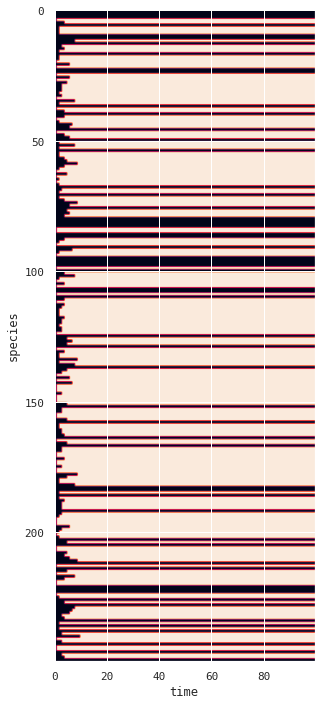

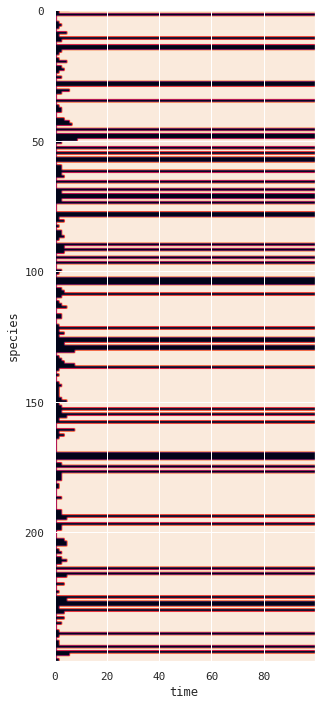

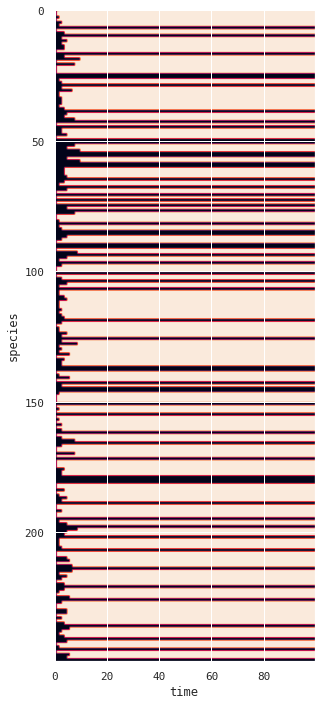

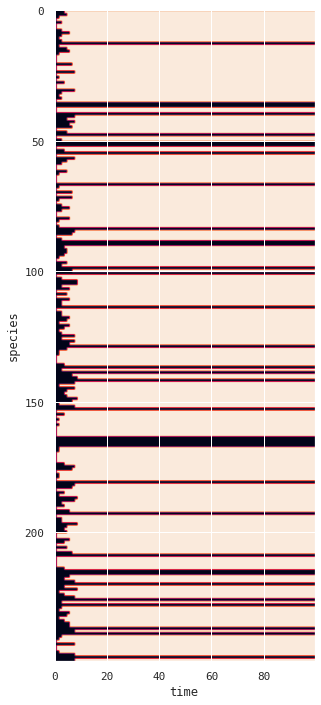

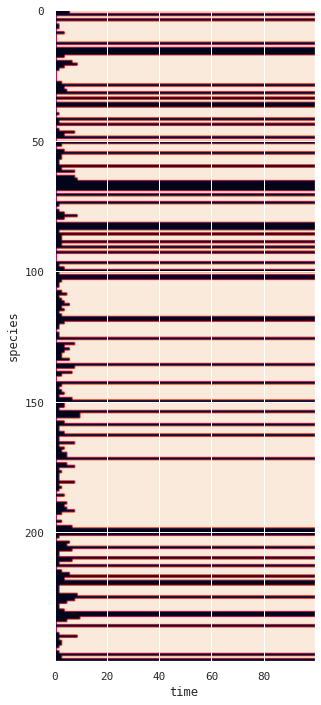

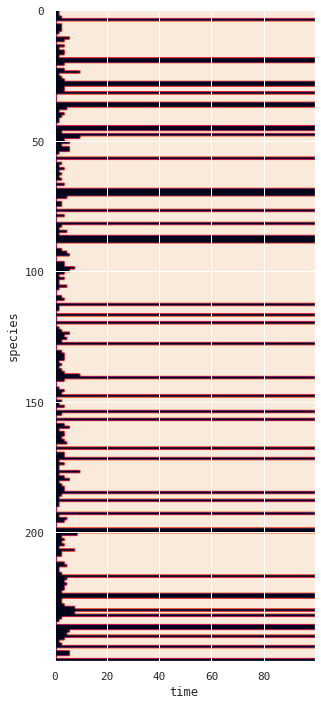

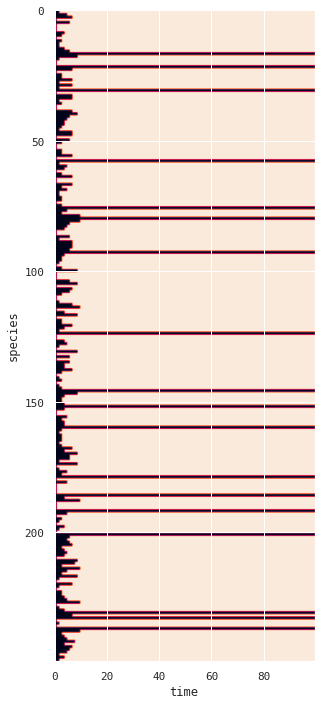

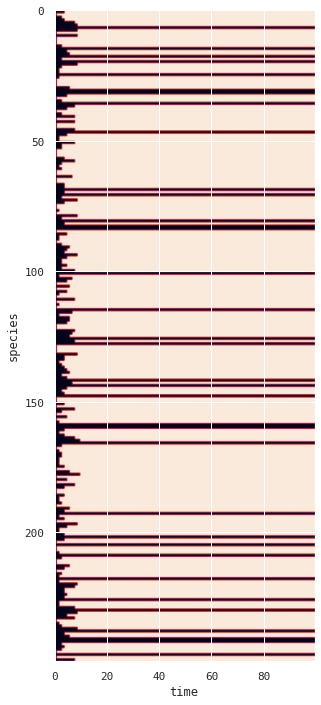

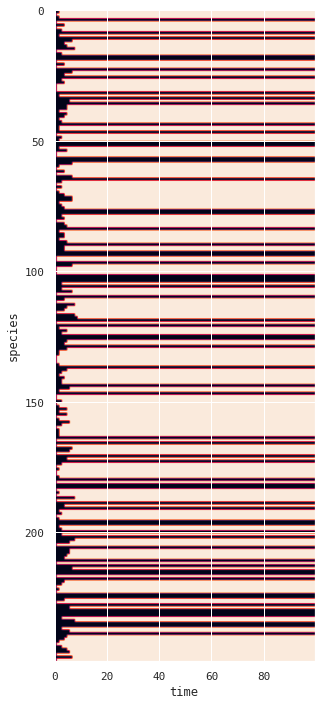

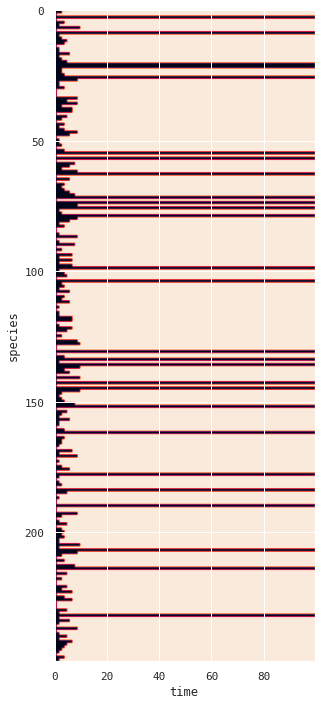

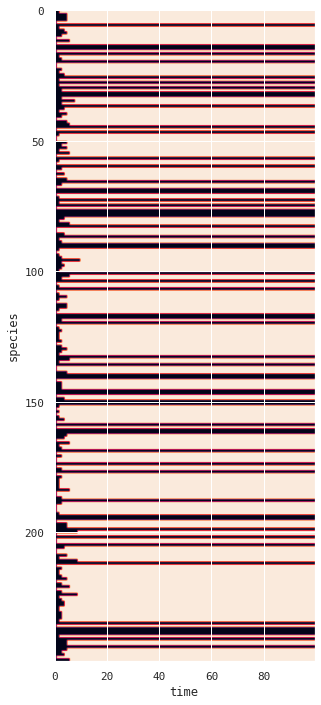

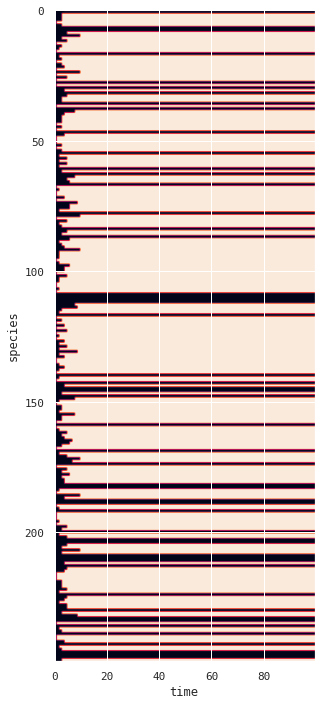

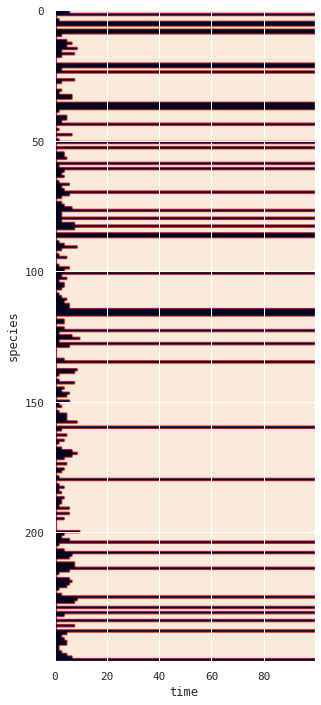

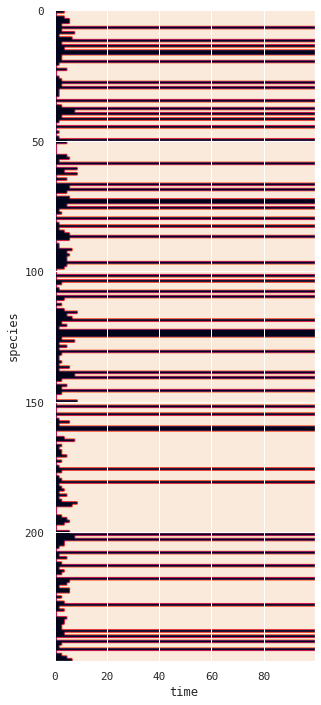

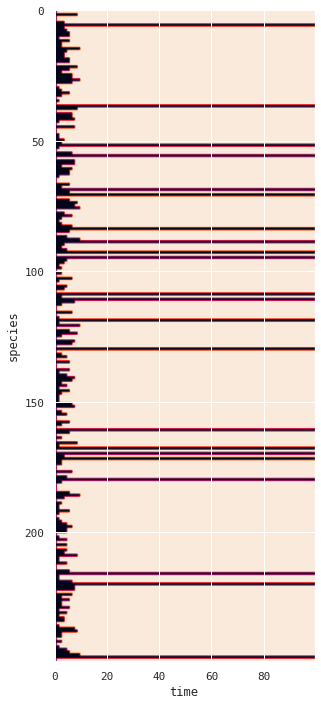

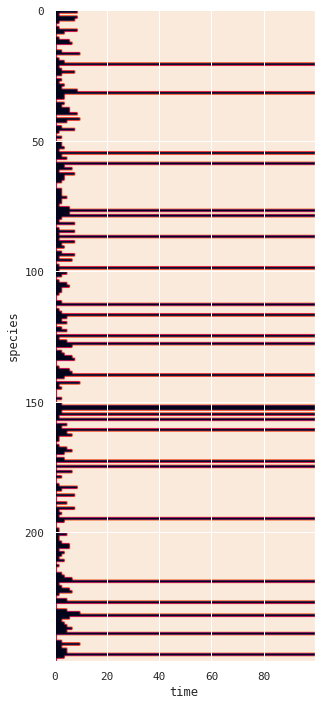

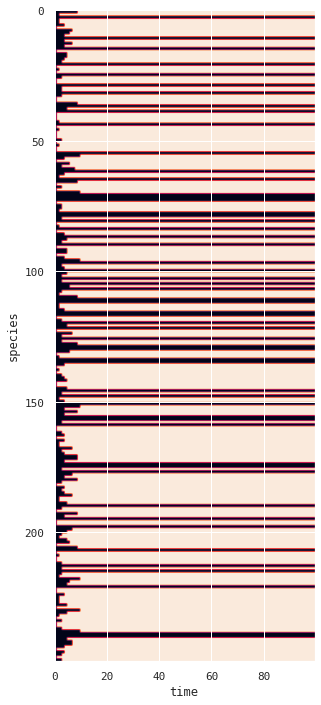

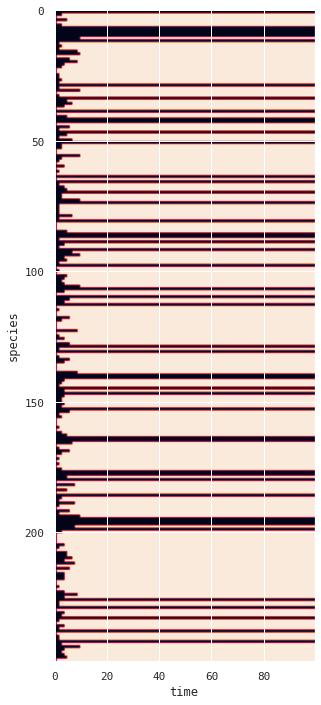

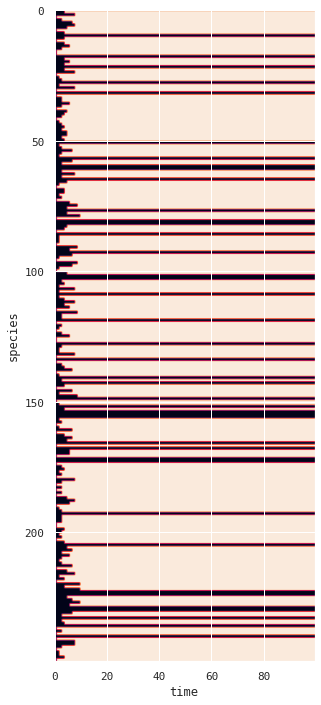

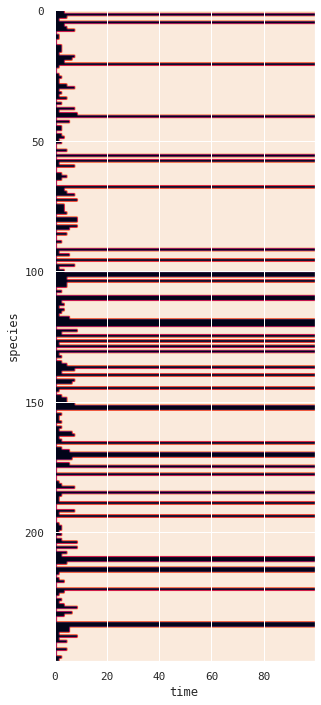

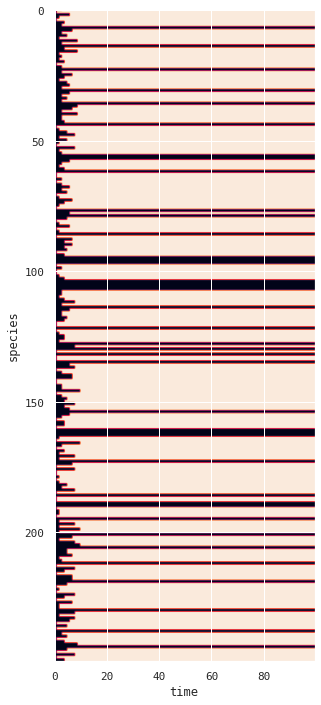

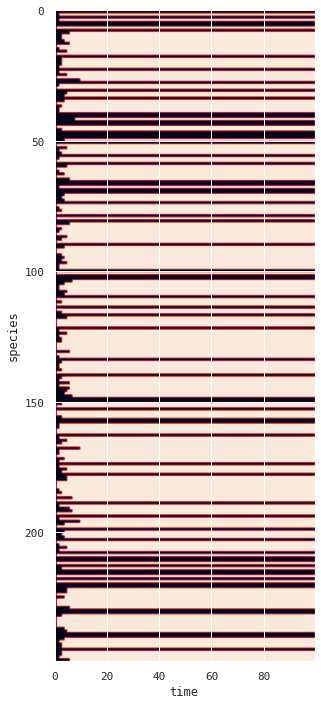

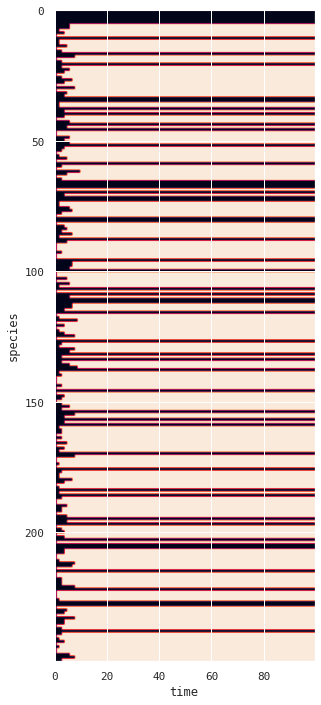

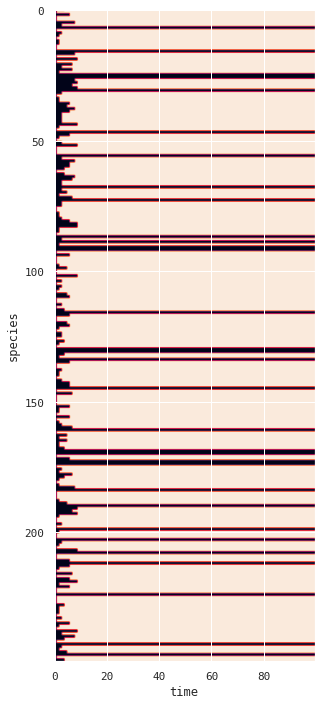

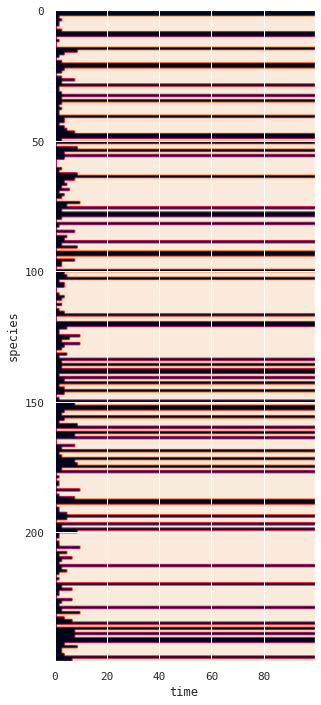

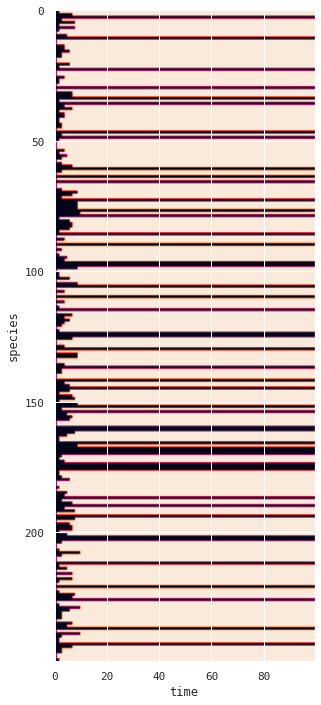

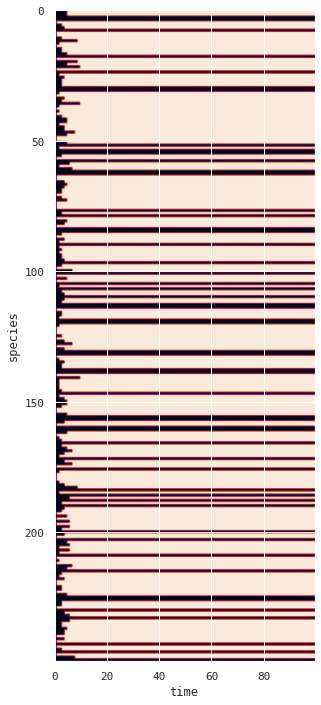

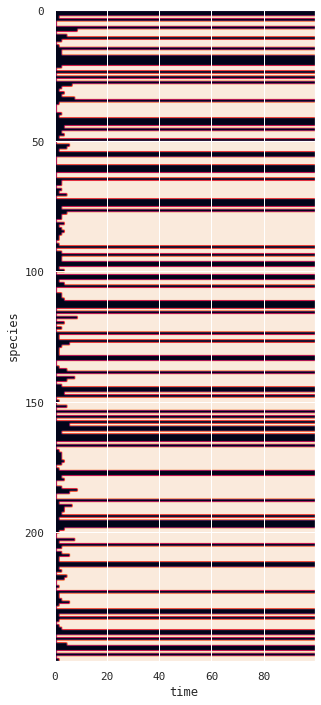

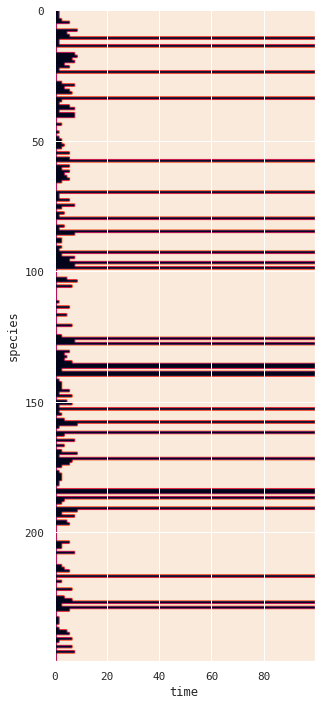

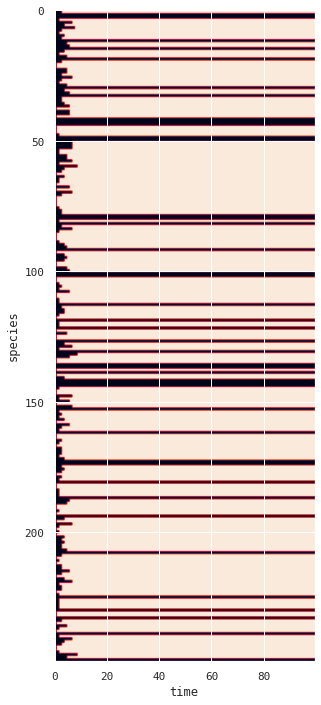

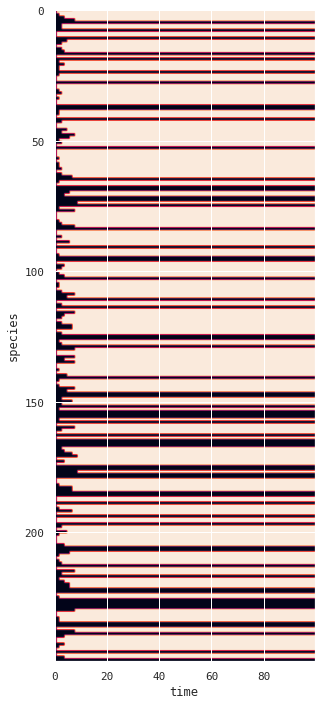

In [36]:
resultSave1 = []
for i in range(0, 100):
    InteractionMatrix1, leaves_names1 = Hypothesis1(C_tree, Constant)
    sample1 = simulation(len(leaves), InteractionMatrix1, 0.001, 'z')
    resultSave1.append(plot_dieout(sample1))
print(resultSave1)

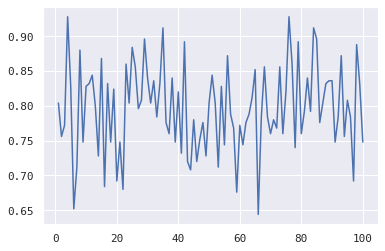

In [38]:
plt.plot([x for x in range(1,101)], resultSave1)

<ipython-input-97-cc11f40548ce>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
<ipython-input-97-cc11f40548ce>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


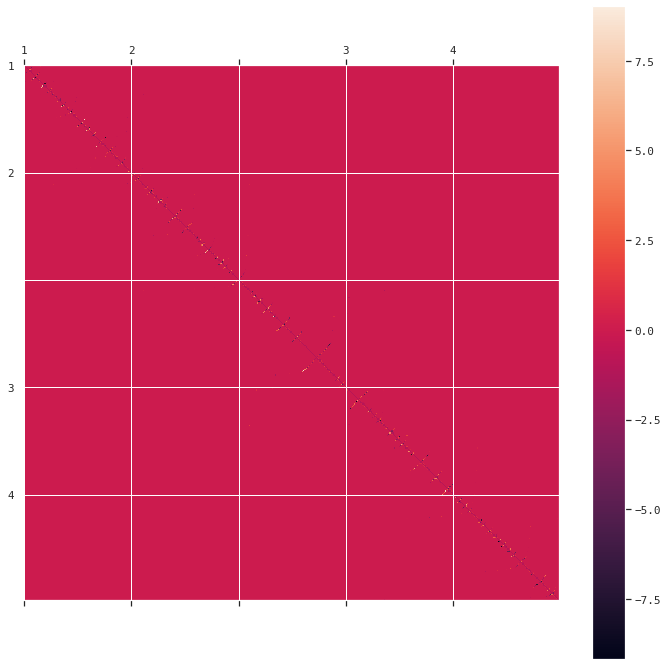

In [106]:
# Hypothesis 2
interactionMatrix2, nodes2 = Hypothesis2(C_tree, Constant, remain_distance, rho)
nodes2N = []
for i in nodes2:
    nodes2N.append(i.name)

matlib_matrixPlot(interactionMatrix2, nodes2N)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized


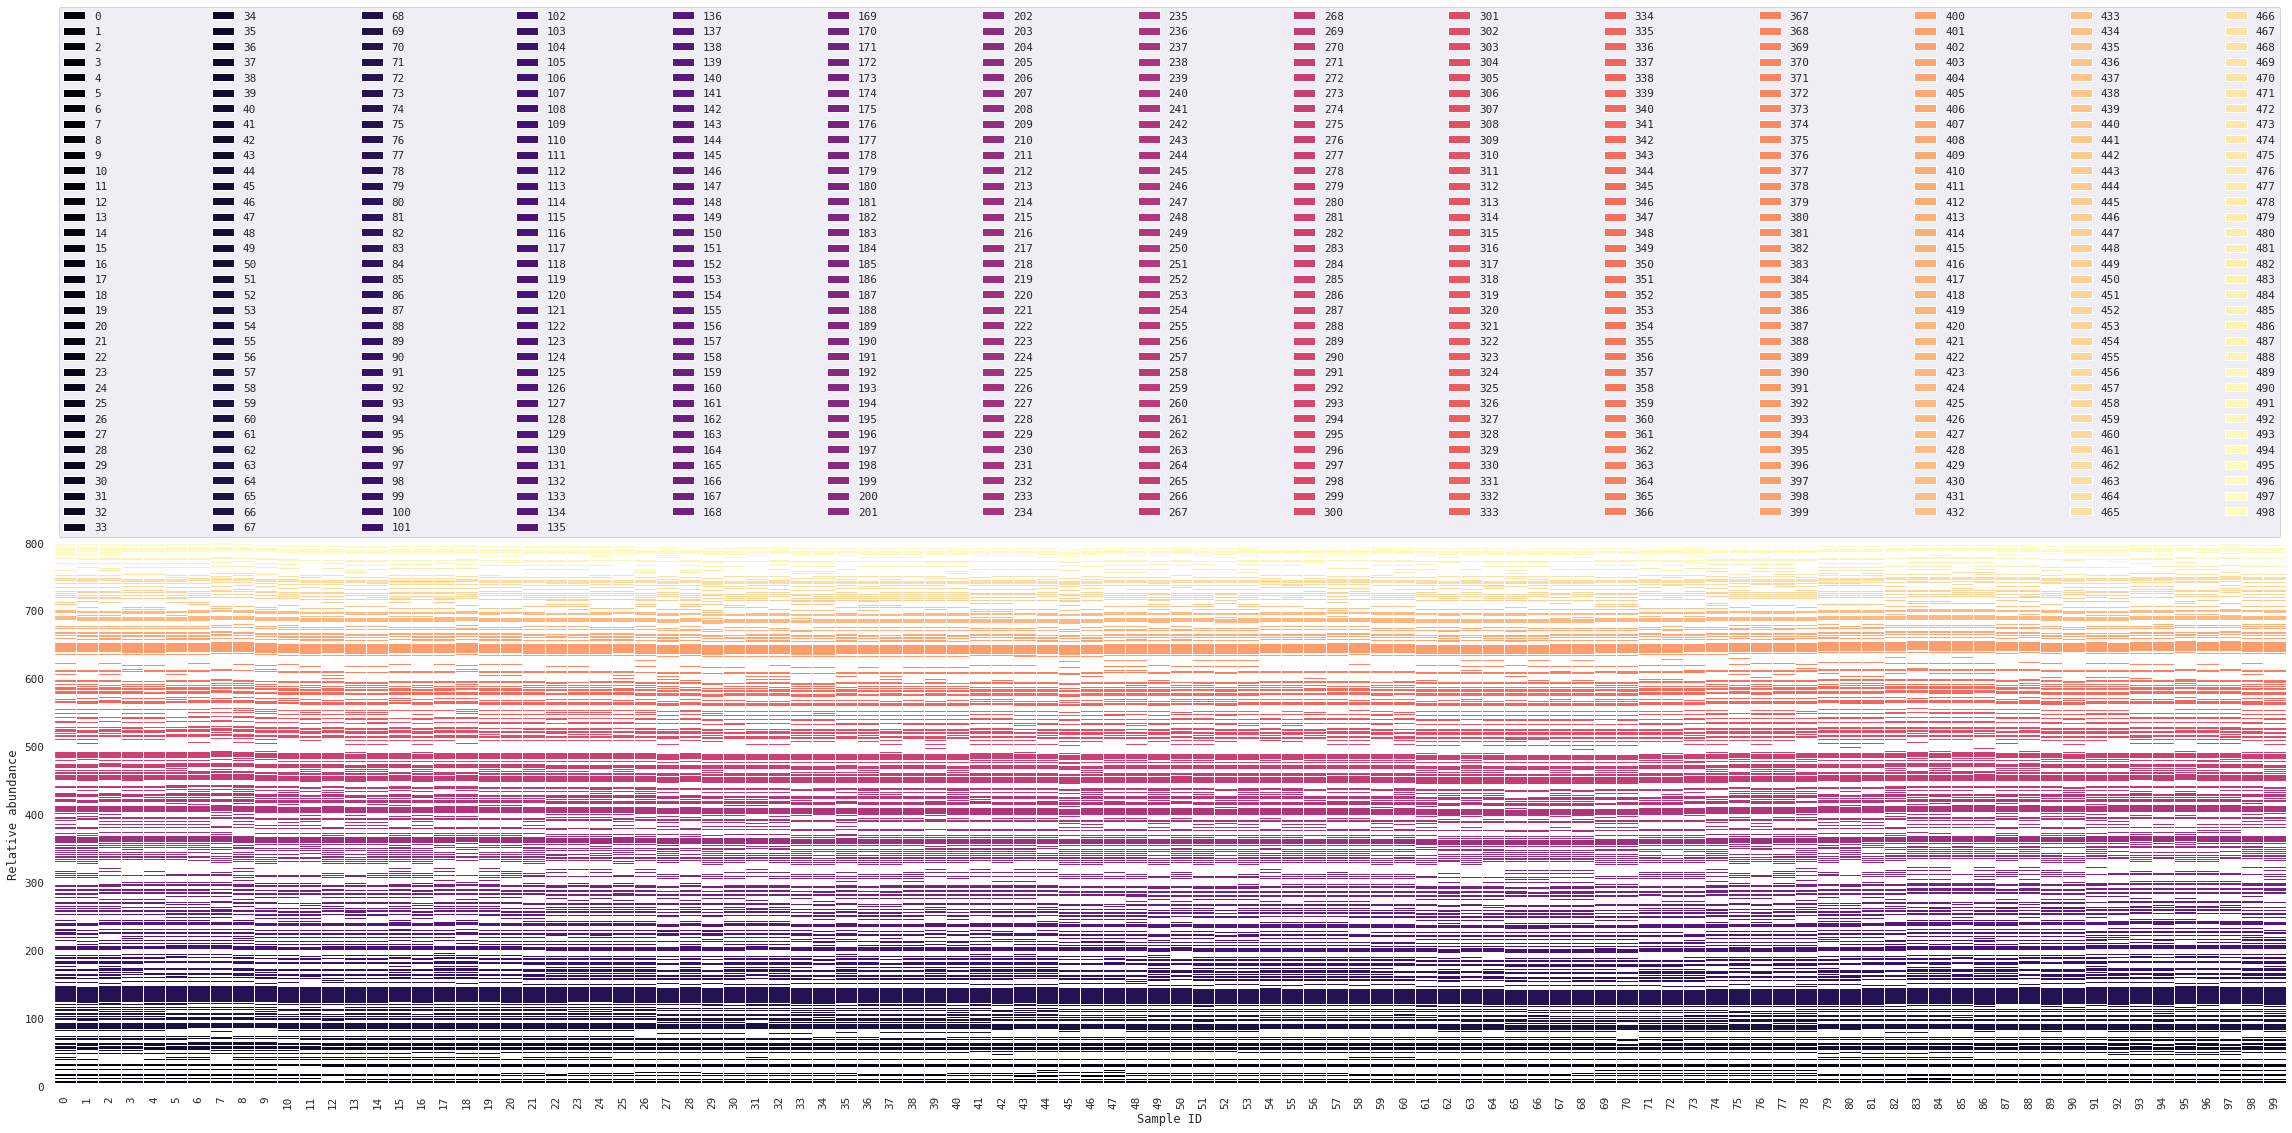

In [107]:
sample2 = simulation(len(nodes2), interactionMatrix2, 0.00001, 'z')

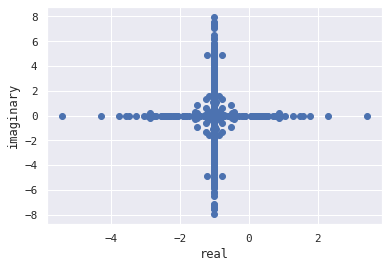

In [51]:
# Eigen value:
eigenValVecoter(interactionMatrix2)

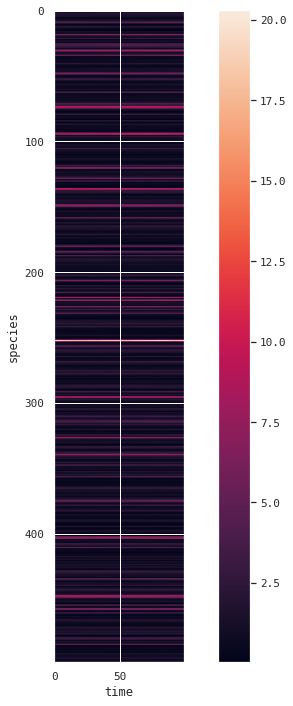

In [52]:
plot_interaction(sample2)

0.0

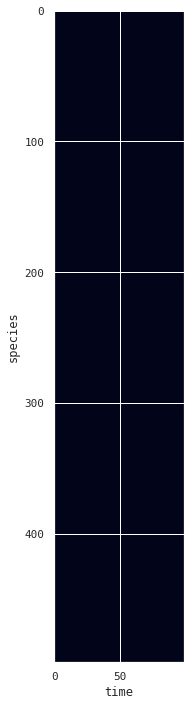

In [53]:
plot_dieout(sample2)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:49

<ipython-input-30-0506df2a79e1>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,12))


Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:49

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:499
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:499    0:49

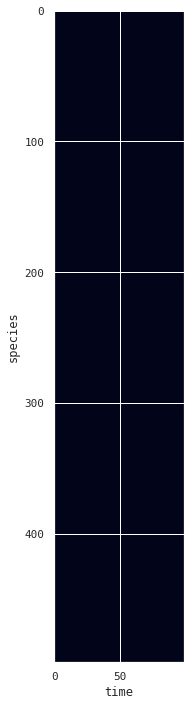

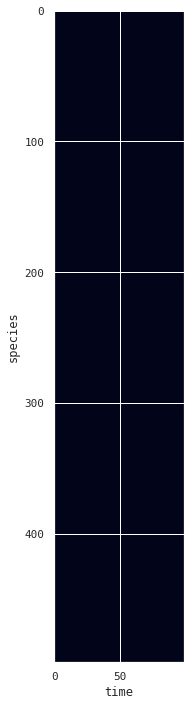

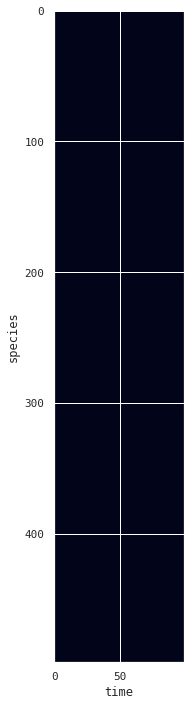

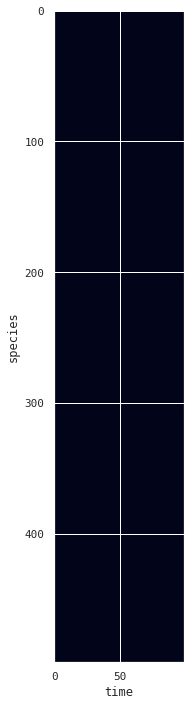

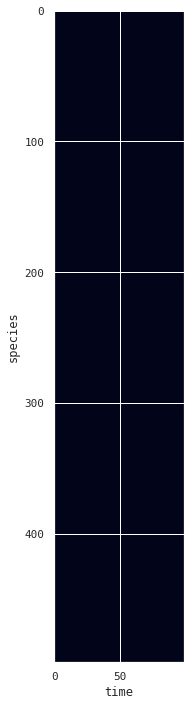

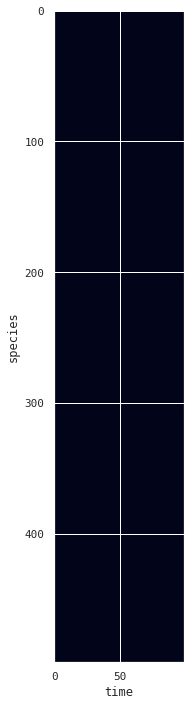

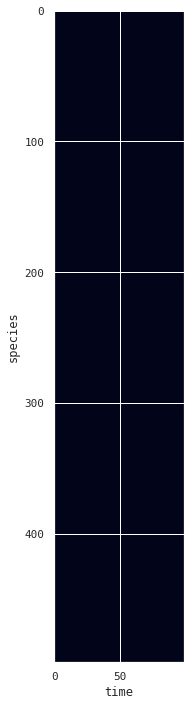

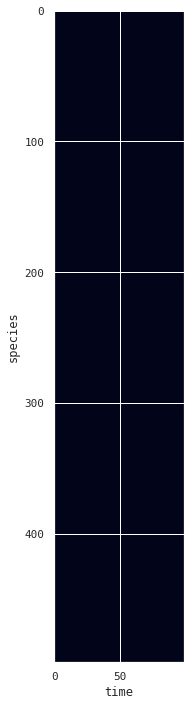

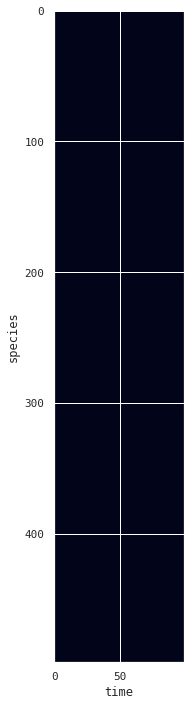

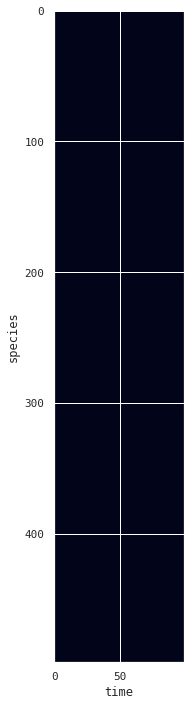

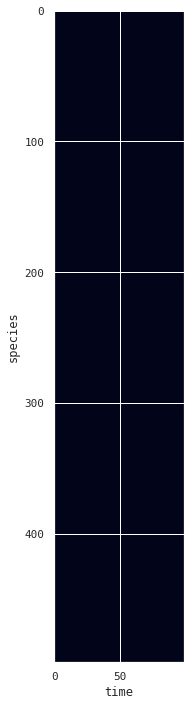

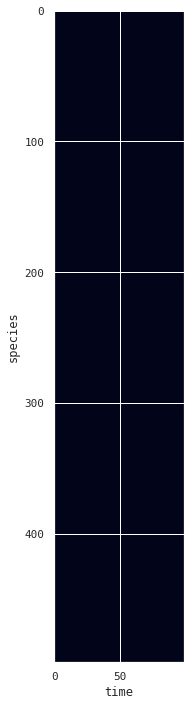

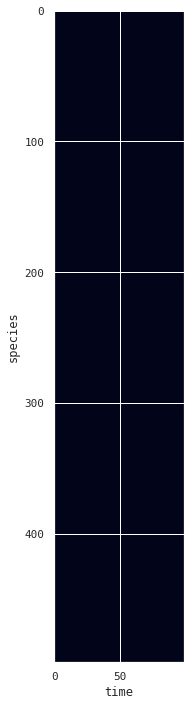

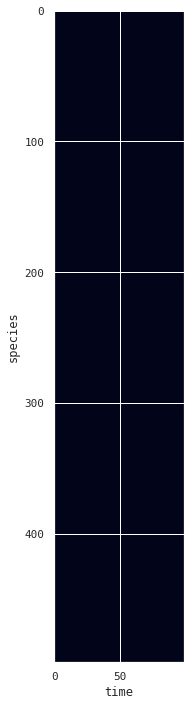

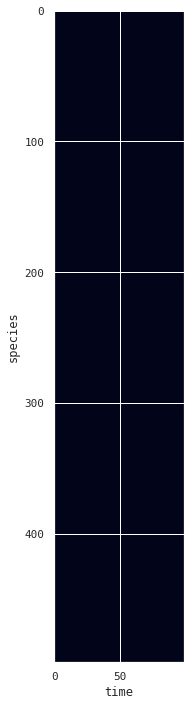

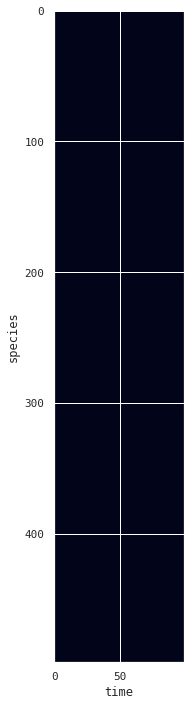

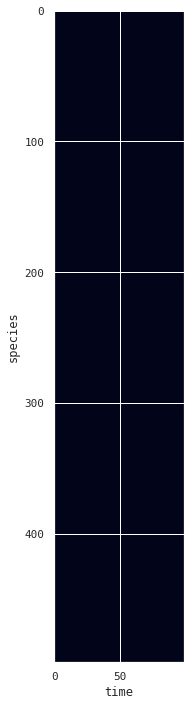

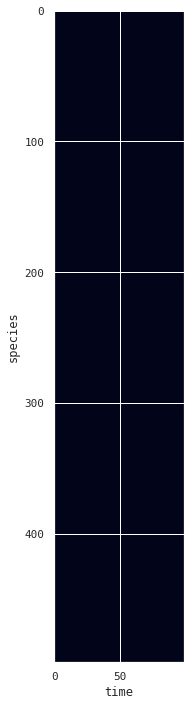

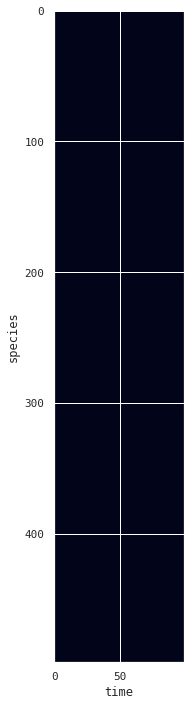

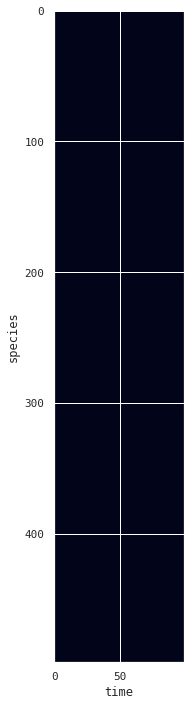

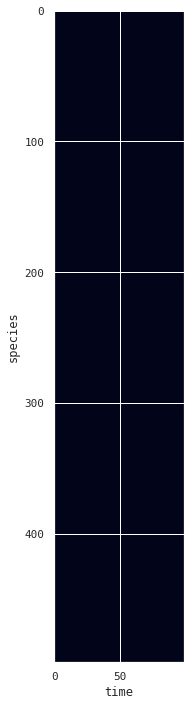

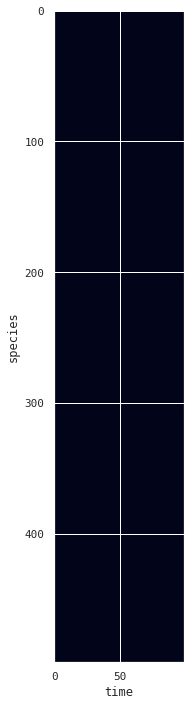

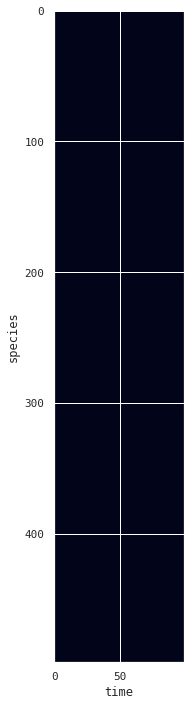

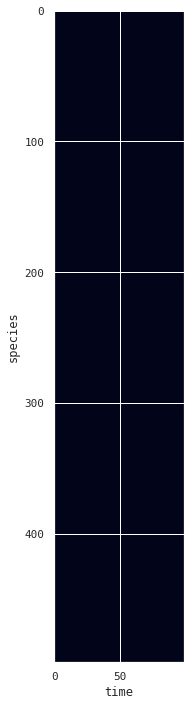

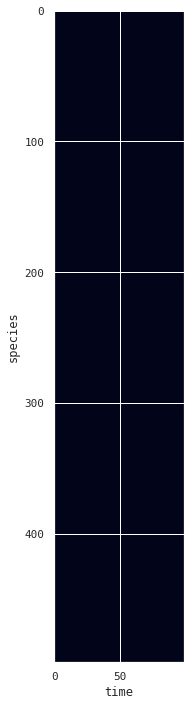

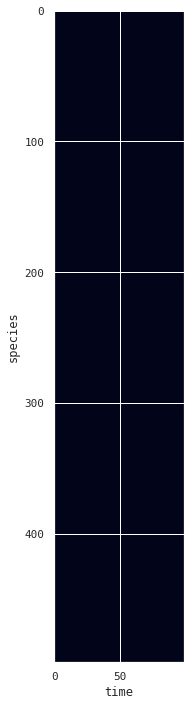

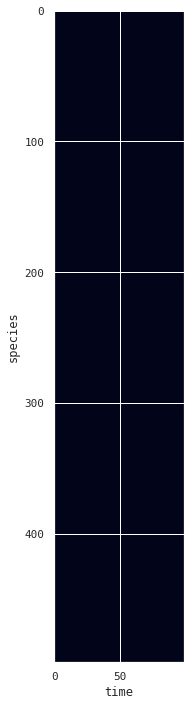

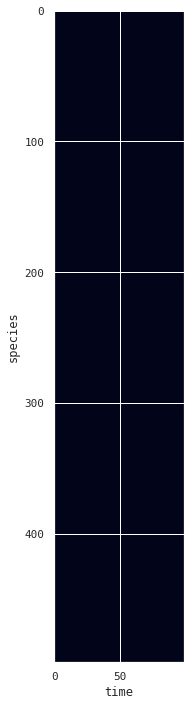

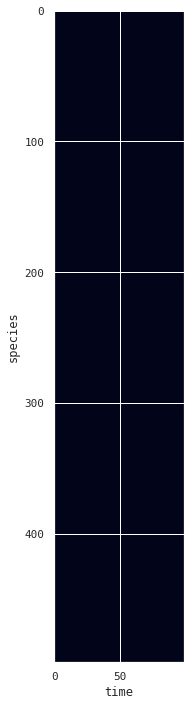

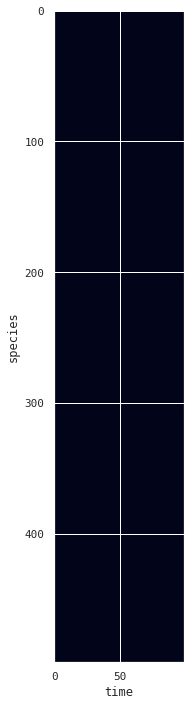

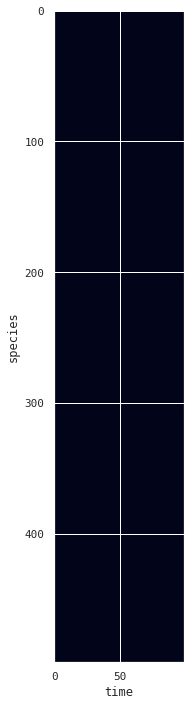

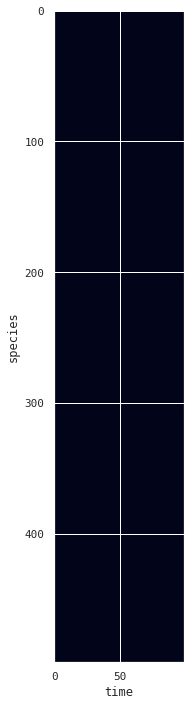

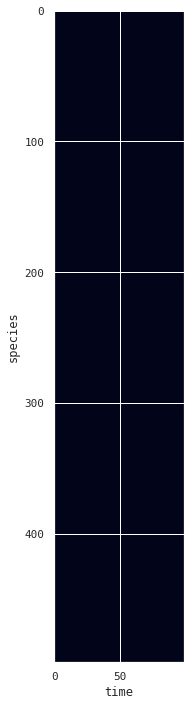

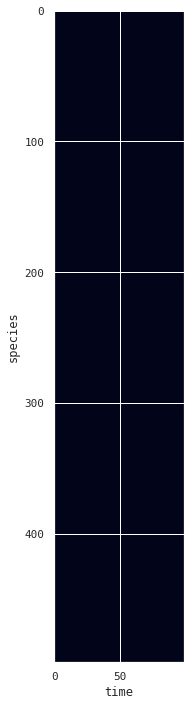

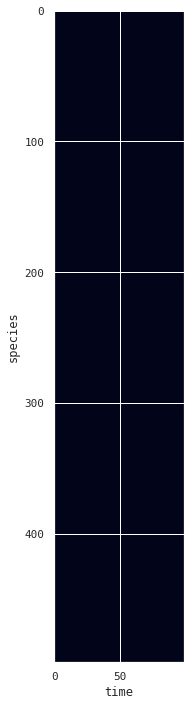

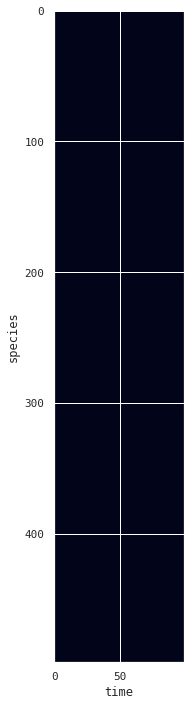

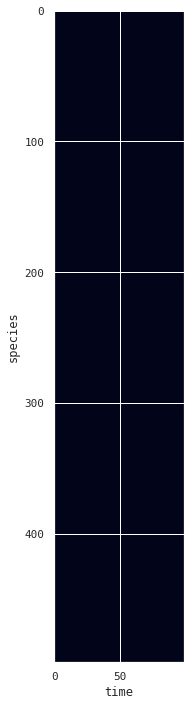

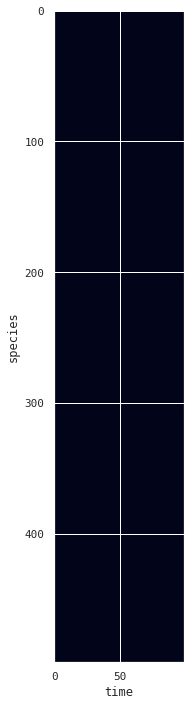

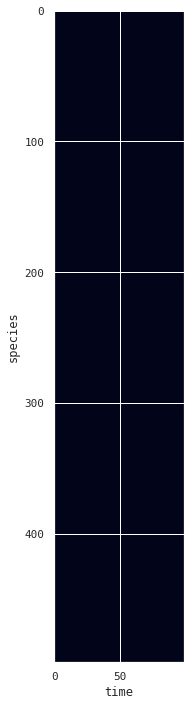

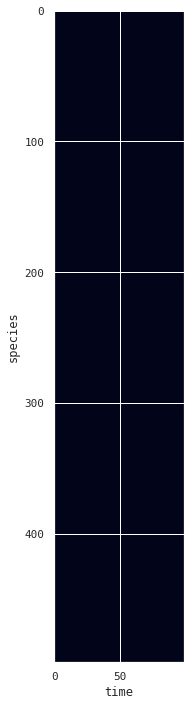

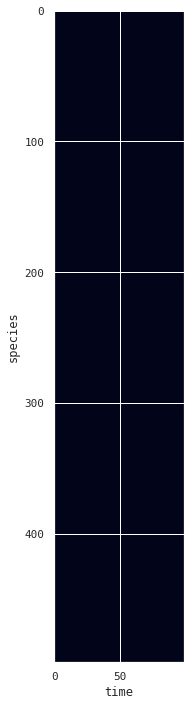

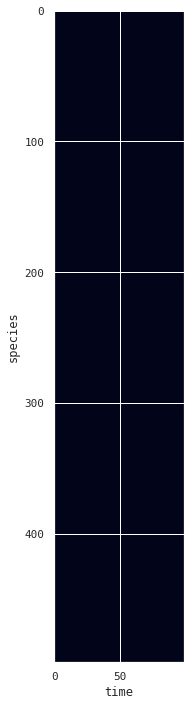

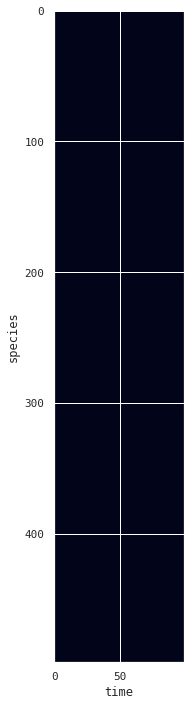

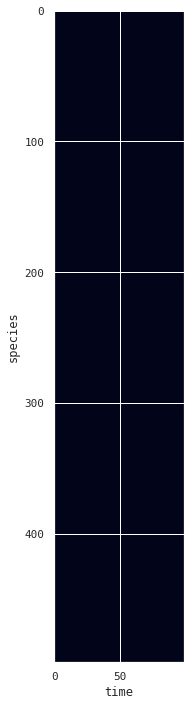

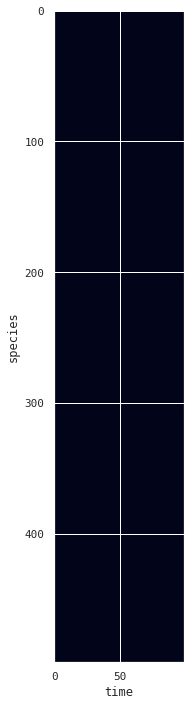

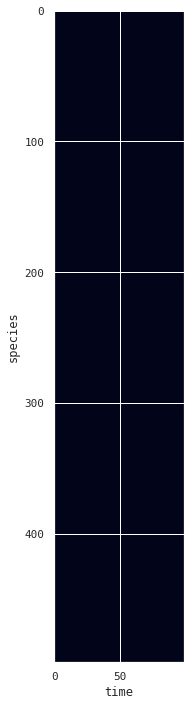

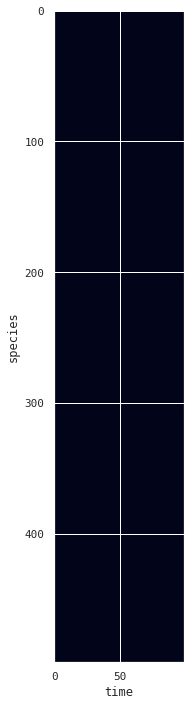

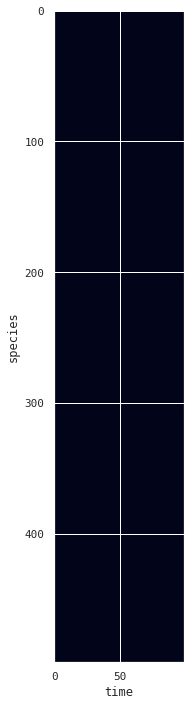

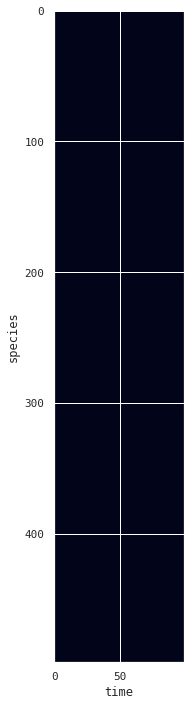

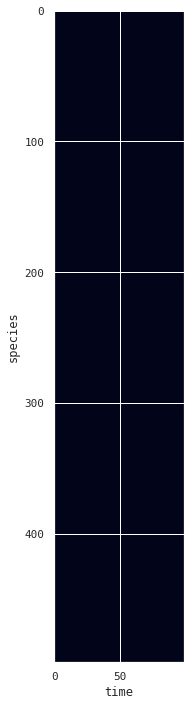

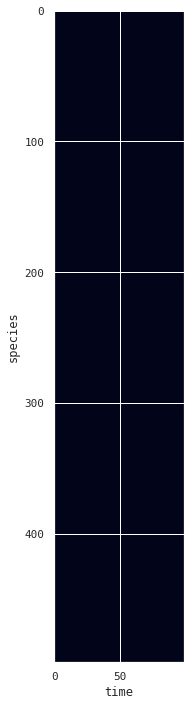

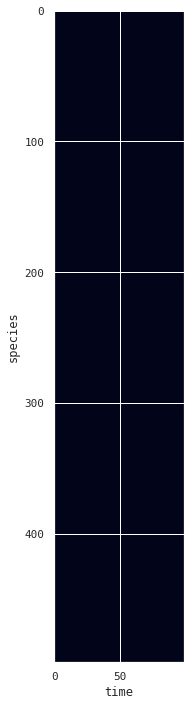

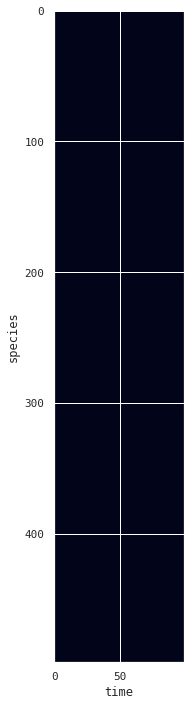

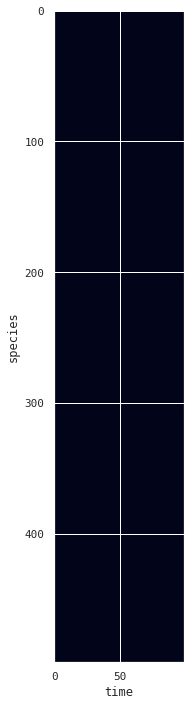

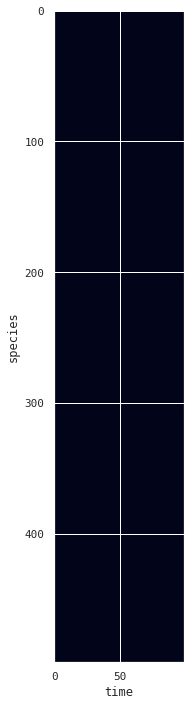

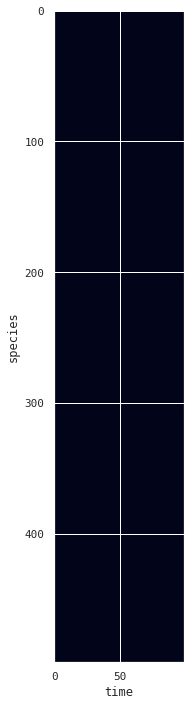

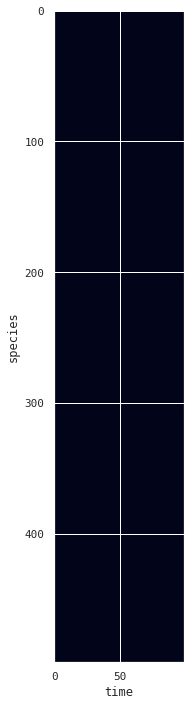

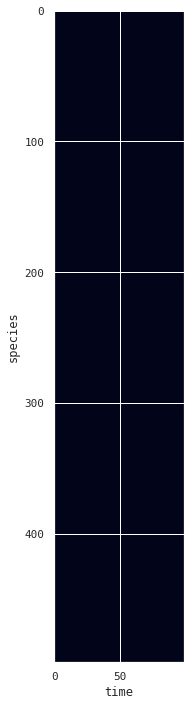

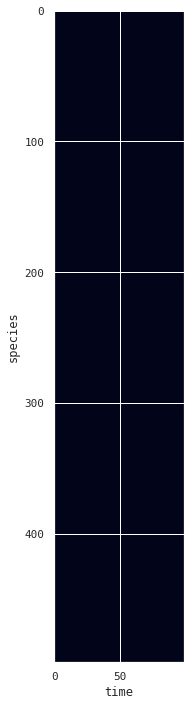

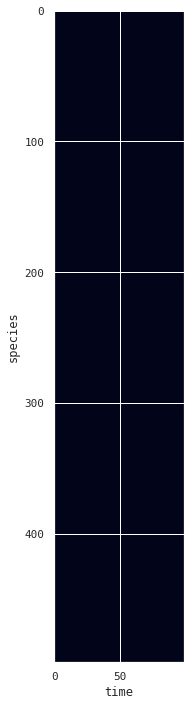

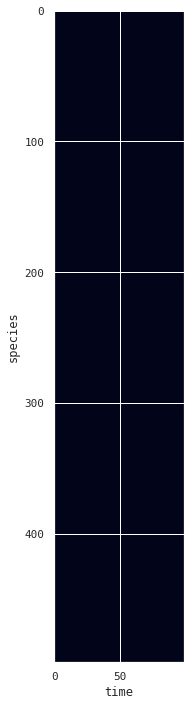

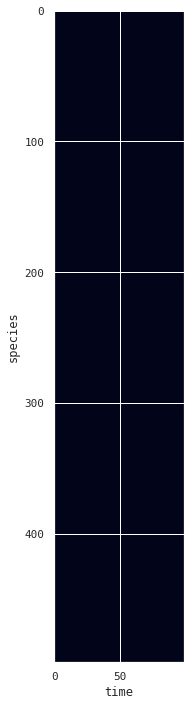

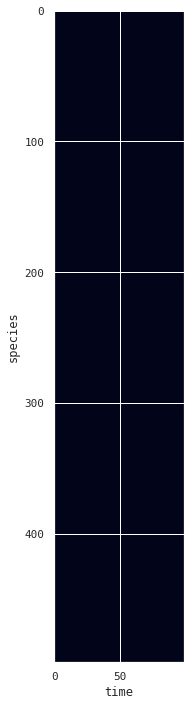

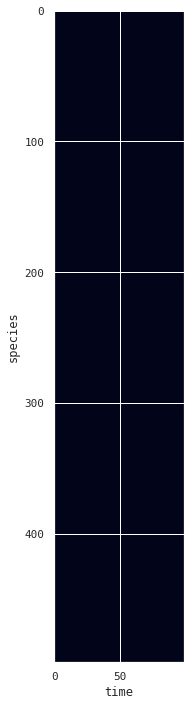

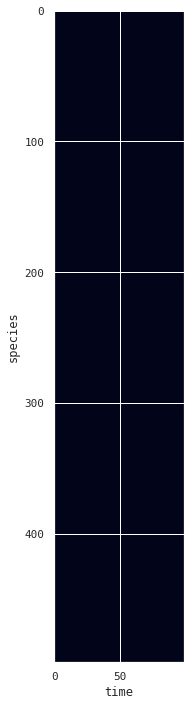

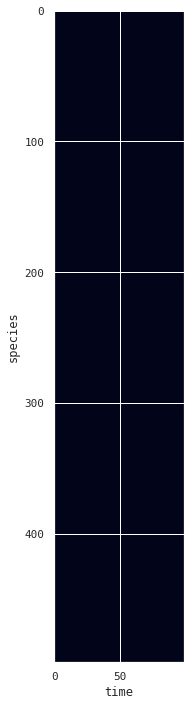

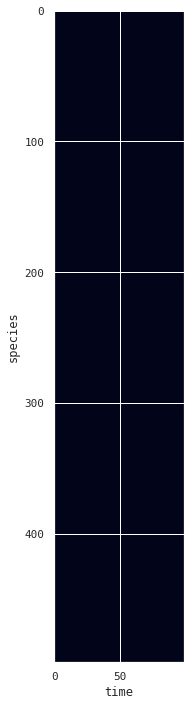

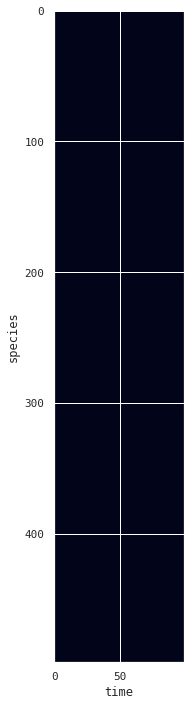

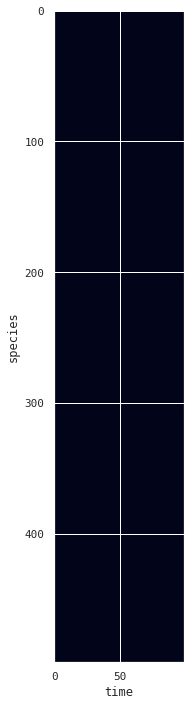

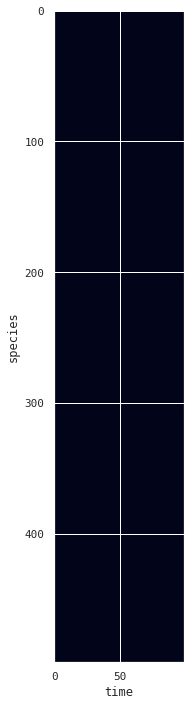

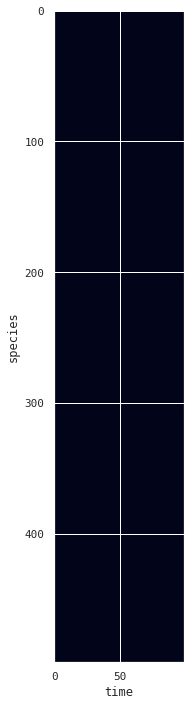

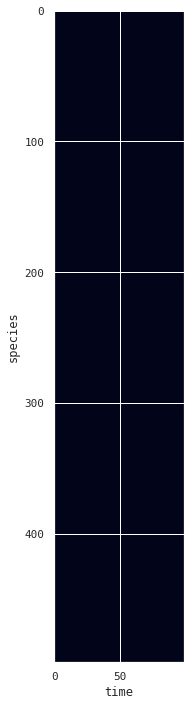

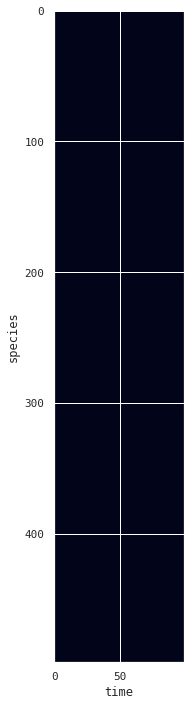

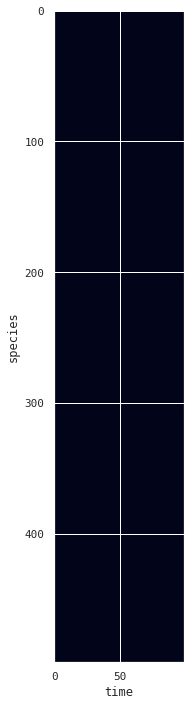

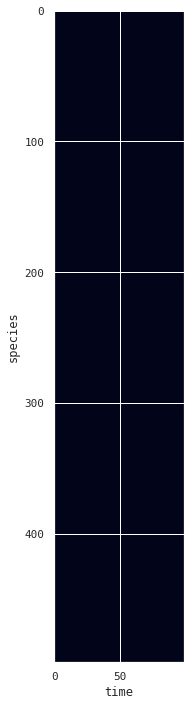

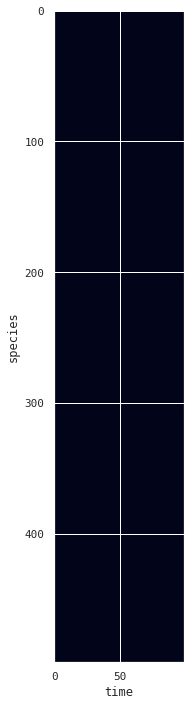

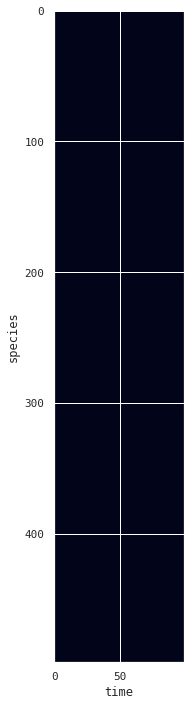

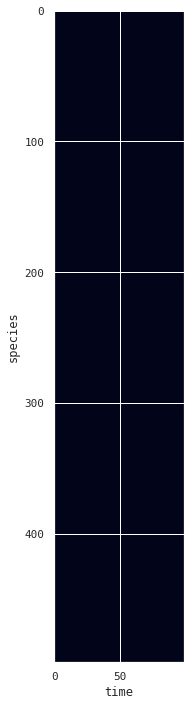

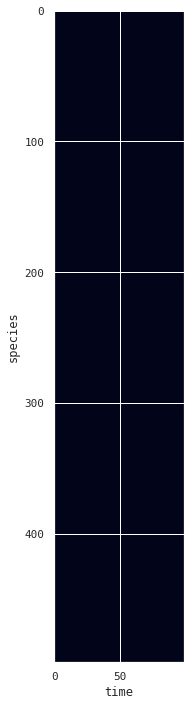

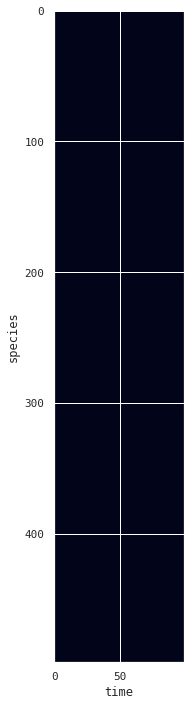

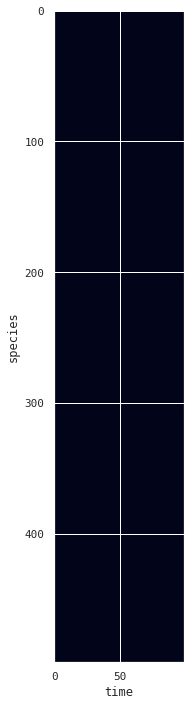

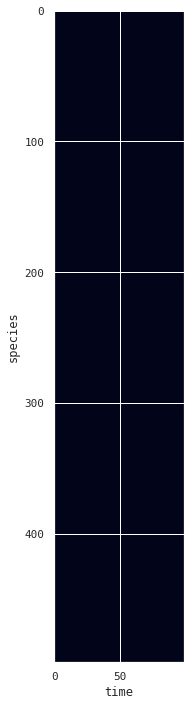

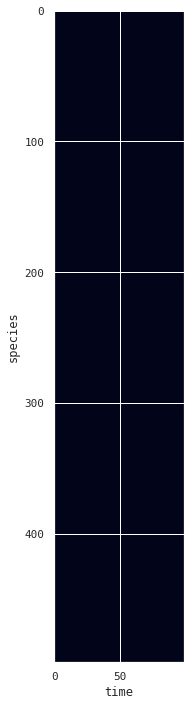

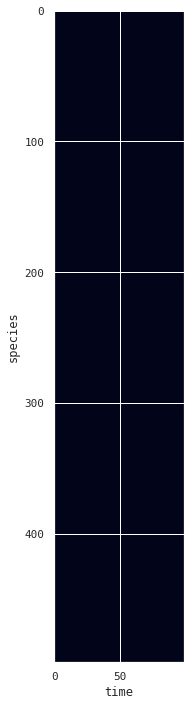

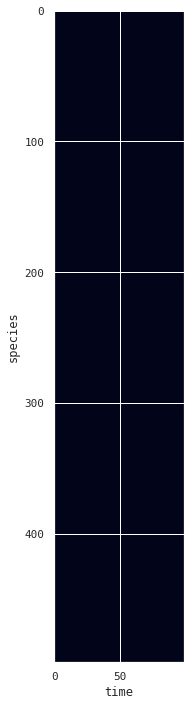

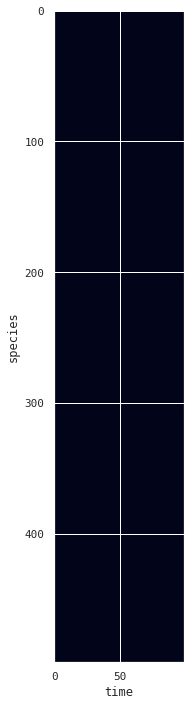

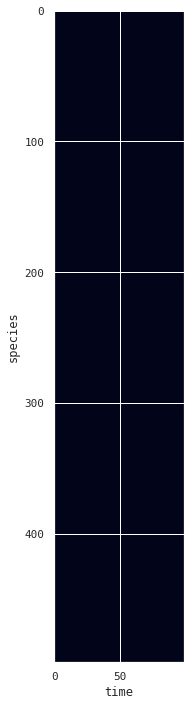

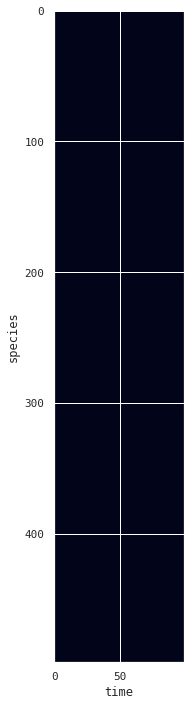

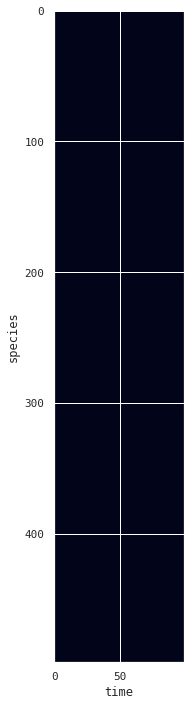

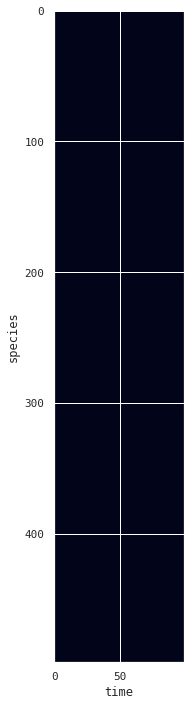

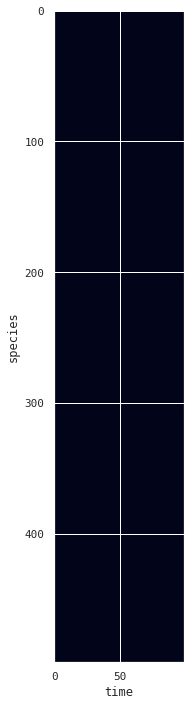

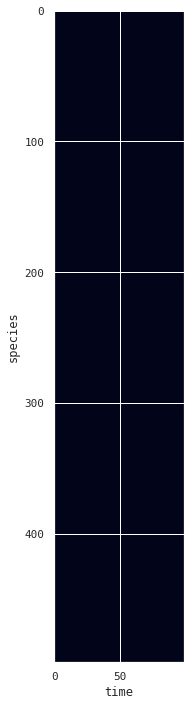

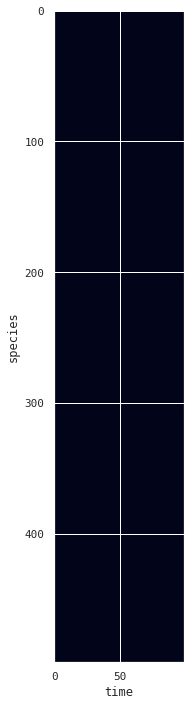

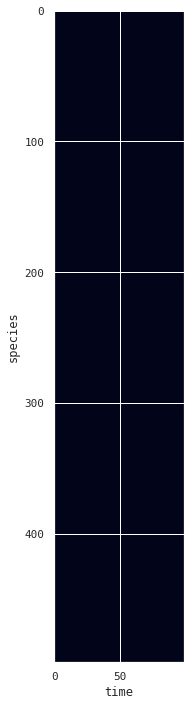

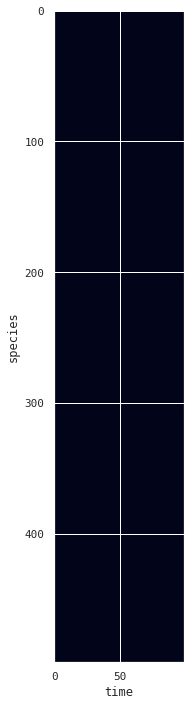

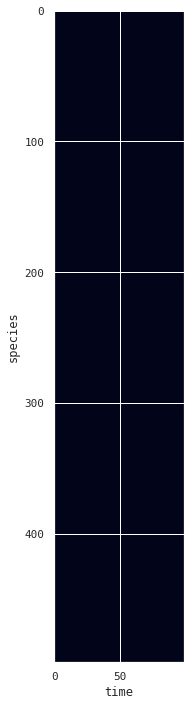

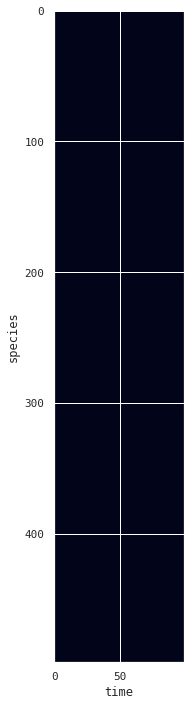

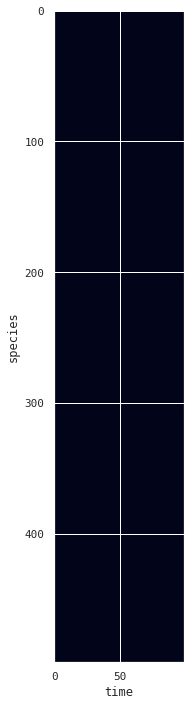

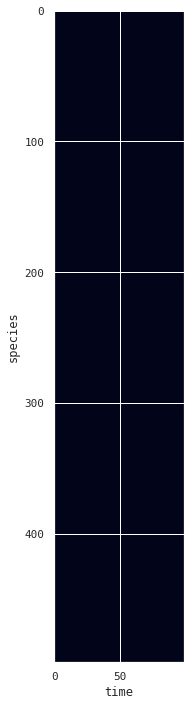

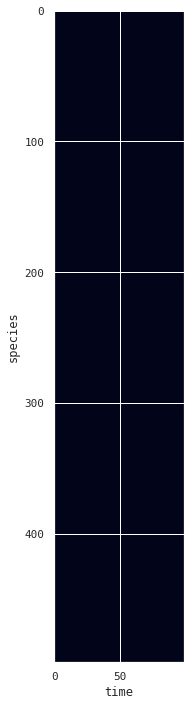

In [54]:
resultSave2 = []
for i in range(0, 100):
    interactionMatrix2, nodes2 = Hypothesis2(C_tree, Constant, remain_distance, rho)
    sample2 = simulation(len(nodes2), interactionMatrix2, 0.00001, 'z')
    resultSave2.append(plot_dieout(sample2))
print(resultSave2)

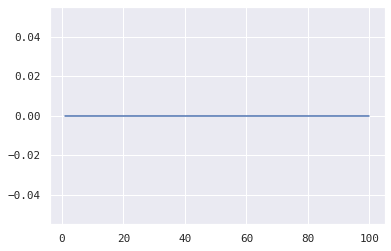

In [55]:
plt.plot([x for x in range(1,101)], resultSave2)

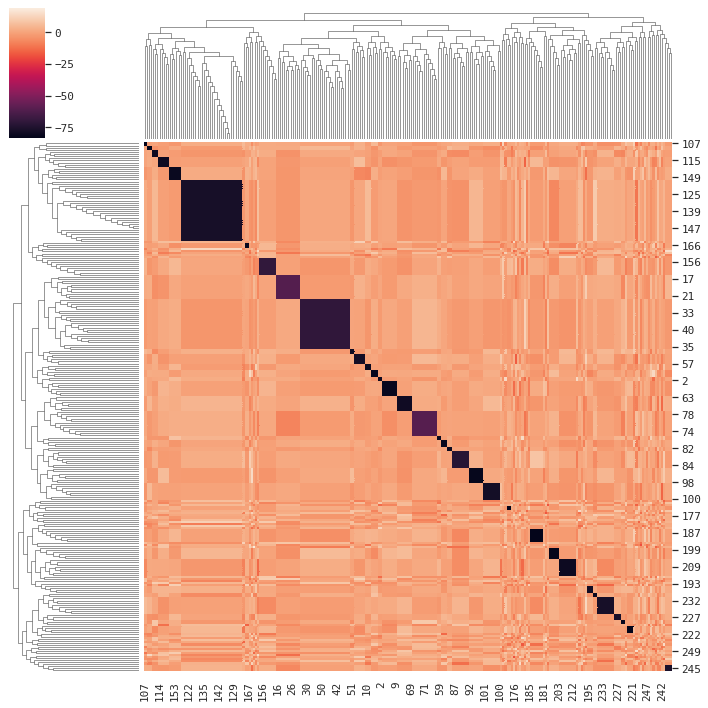

In [108]:
# Hypothesis 3
interactionMatrix3, nodes3= Hypothesis3(C_tree, 4.42, C, rho, rho, remain_distance, intra, remain_distance, inter, Constant)
seaborn_plot(interactionMatrix3, leaves, distMatrix)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized


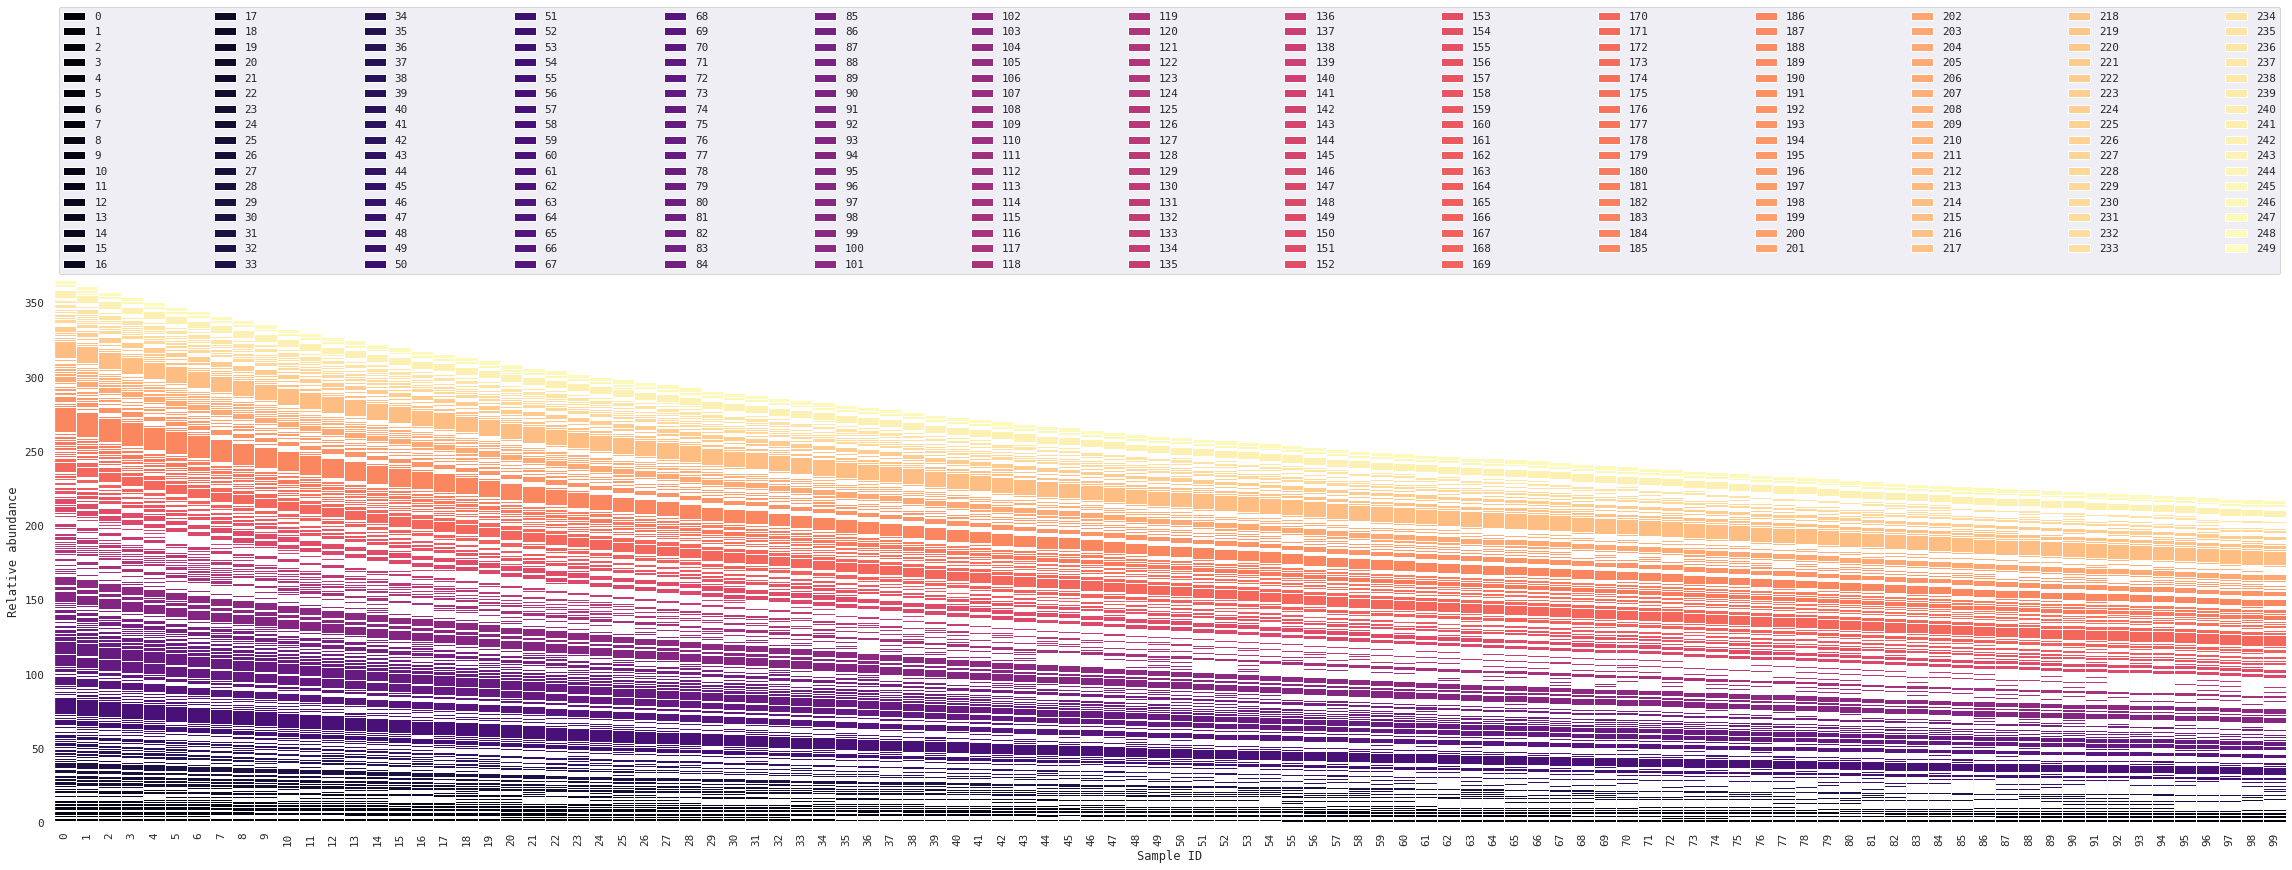

In [109]:
sample3 = simulation(len(leaves), interactionMatrix3, 0.00001, 'z')

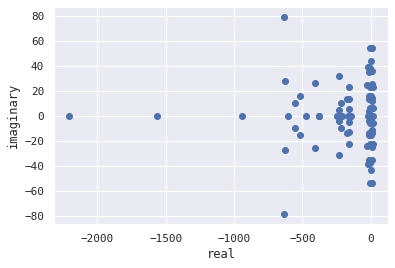

In [73]:
# Eigen value:
eigenValVecoter(interactionMatrix3)

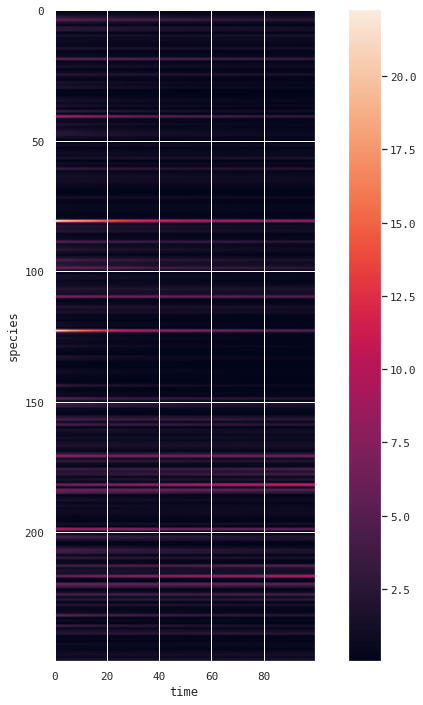

In [75]:
plot_interaction(sample3)

0.0

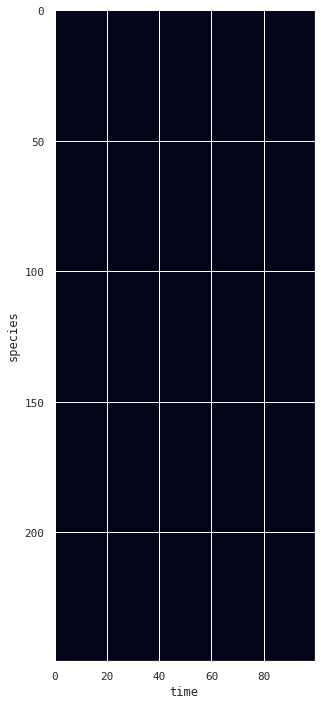

In [76]:
plot_dieout(sample3)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:25

<ipython-input-30-0506df2a79e1>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,12))


Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:25

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:25

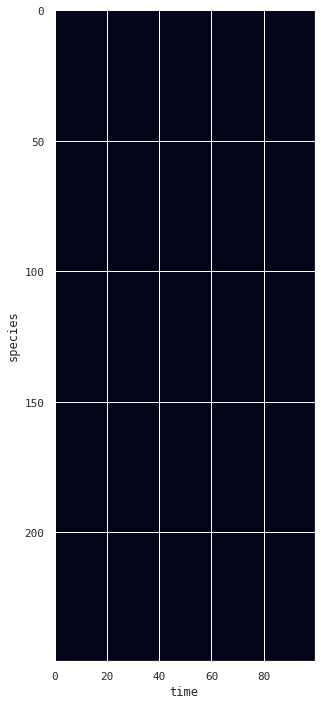

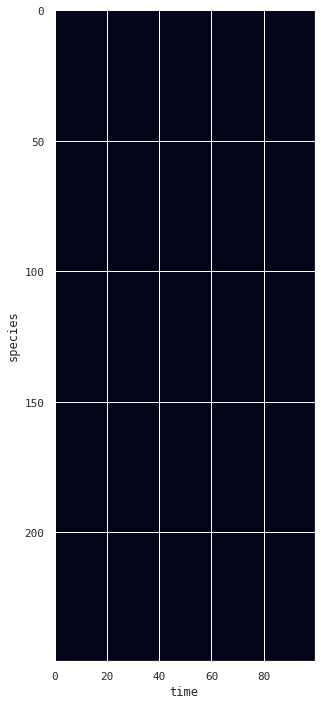

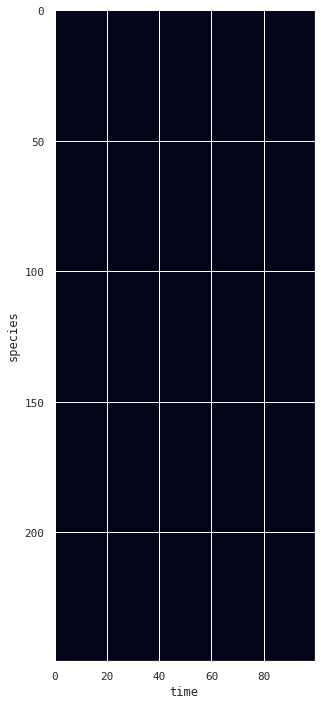

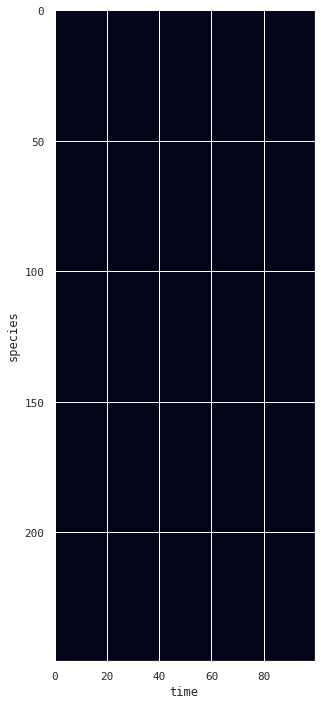

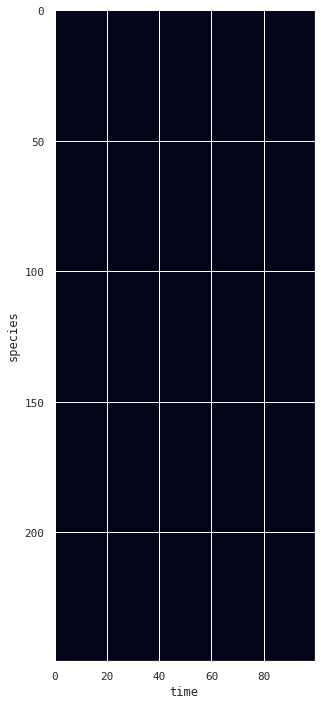

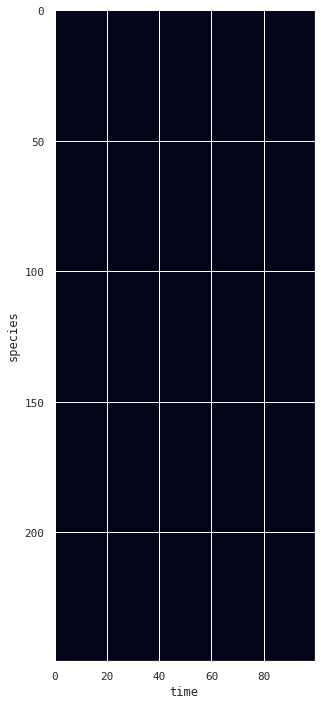

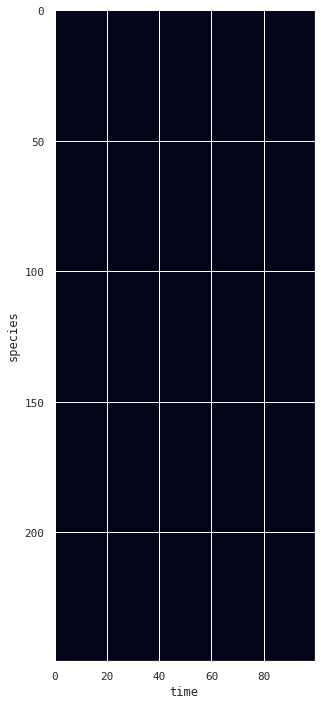

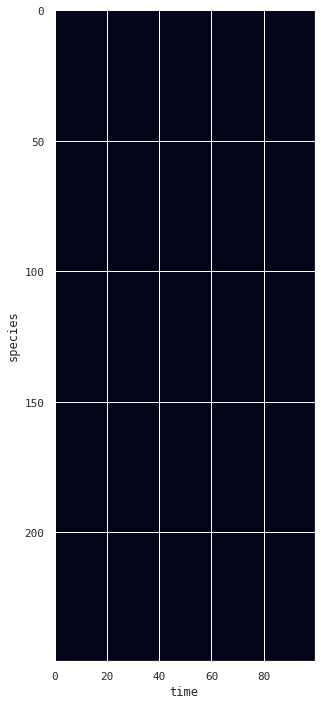

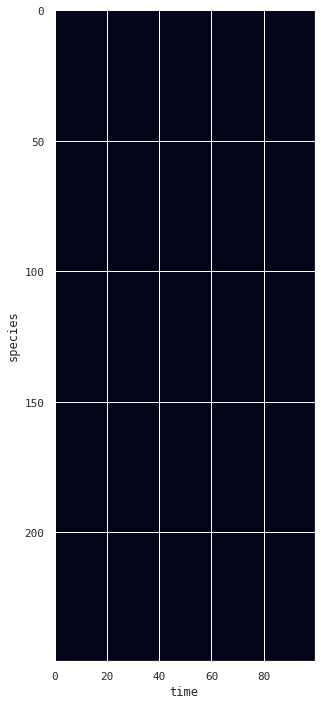

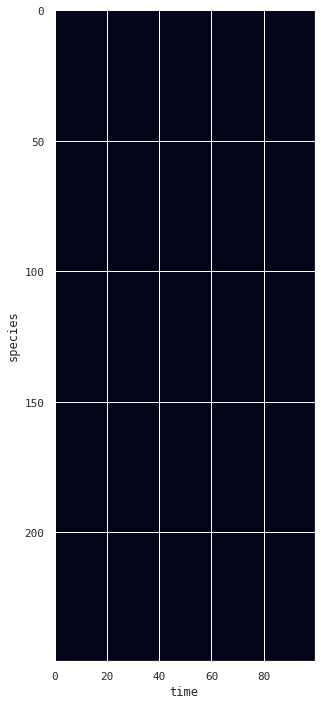

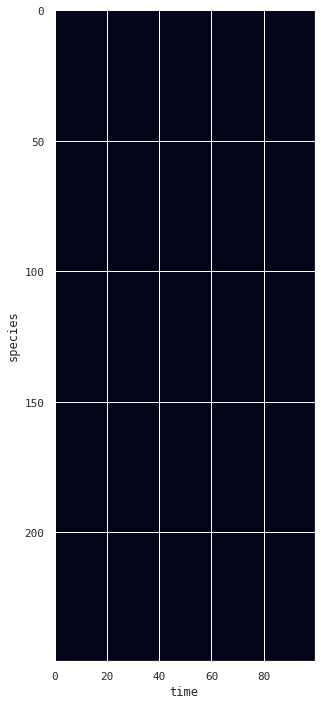

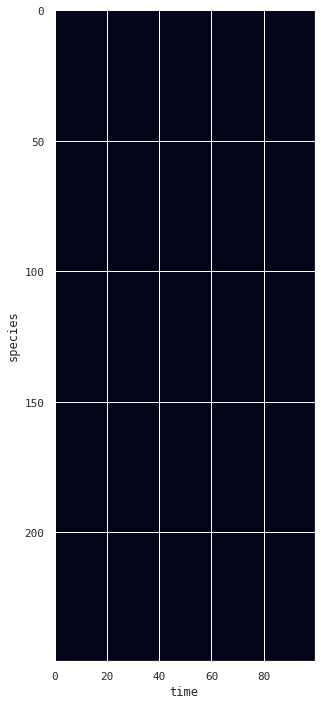

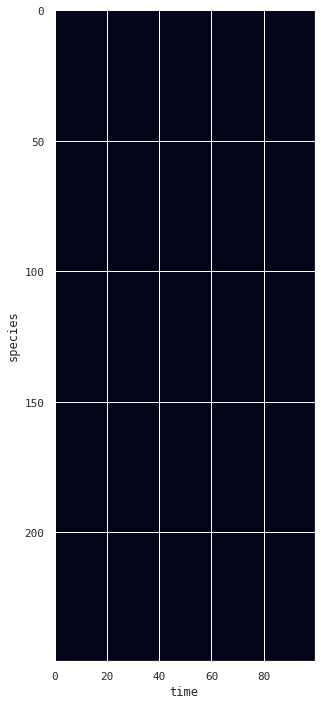

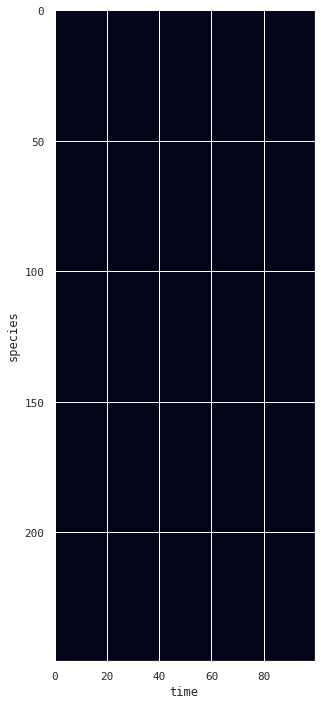

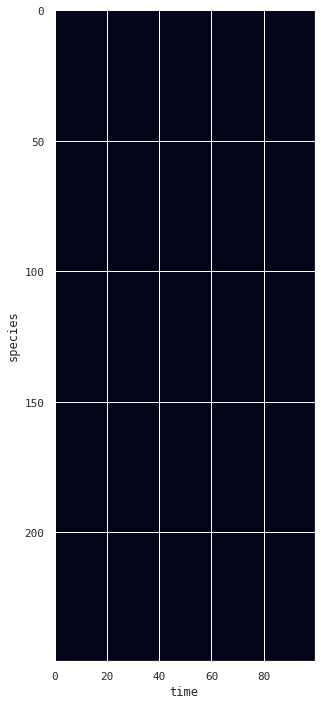

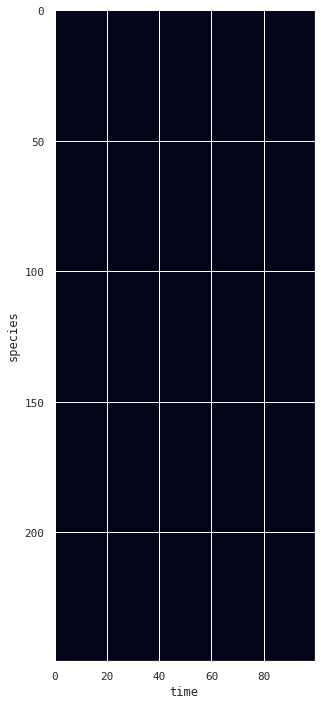

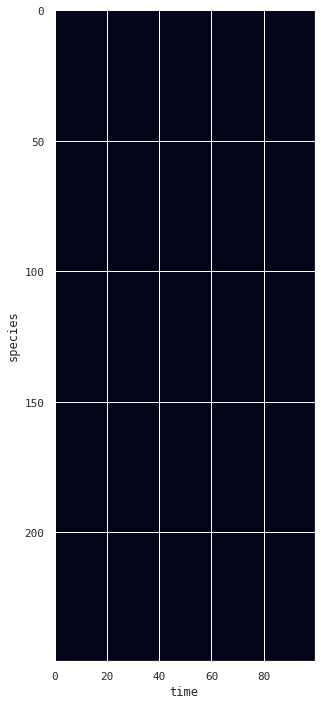

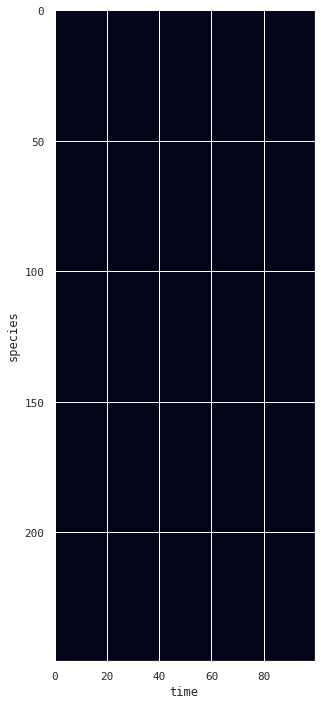

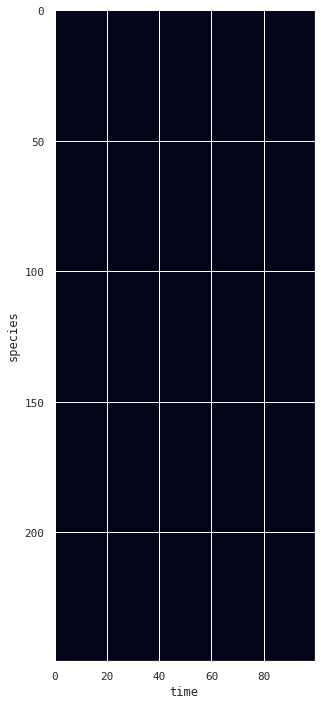

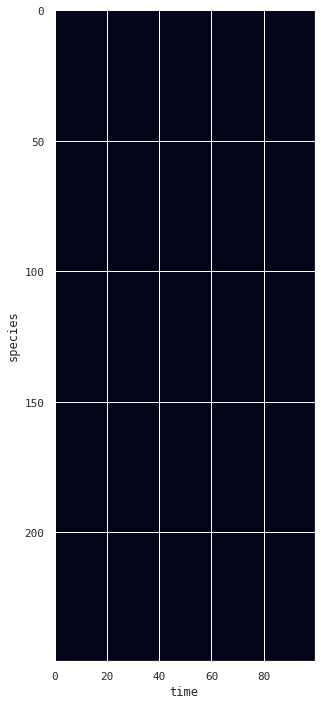

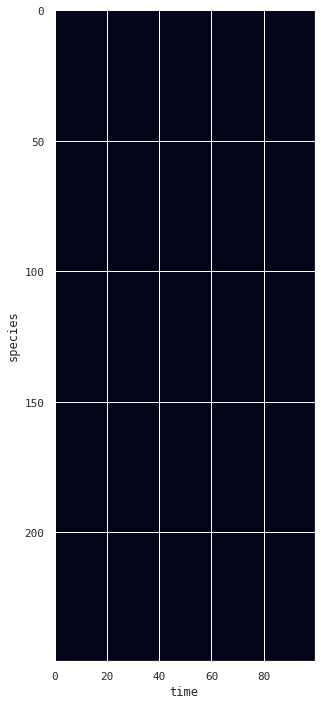

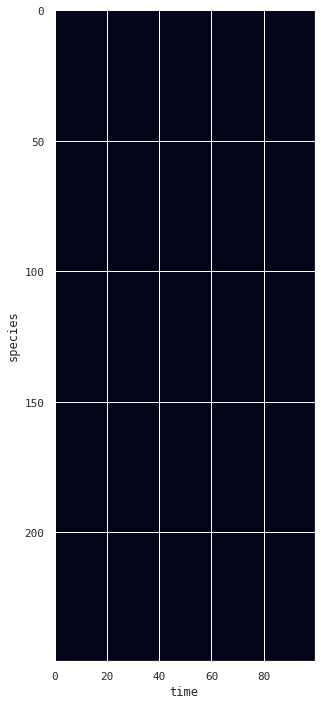

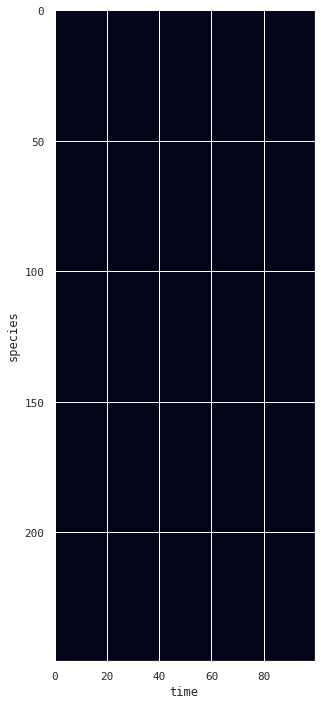

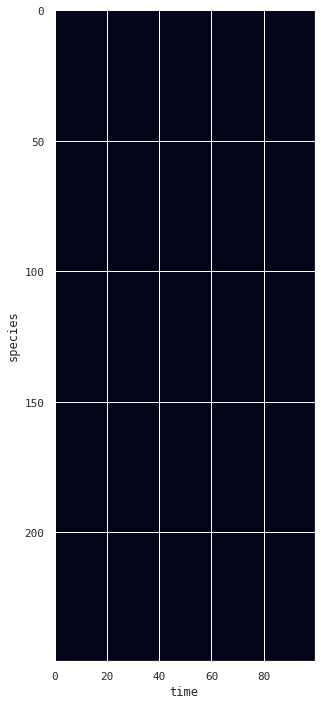

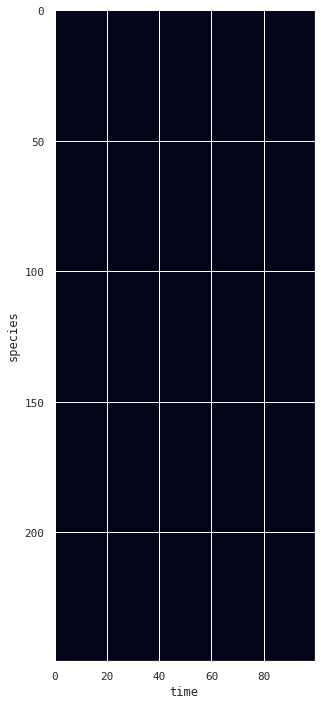

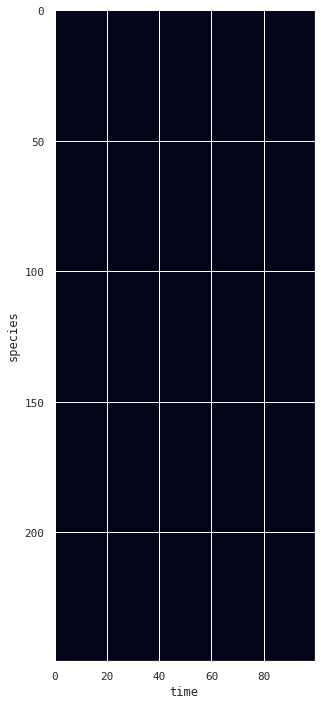

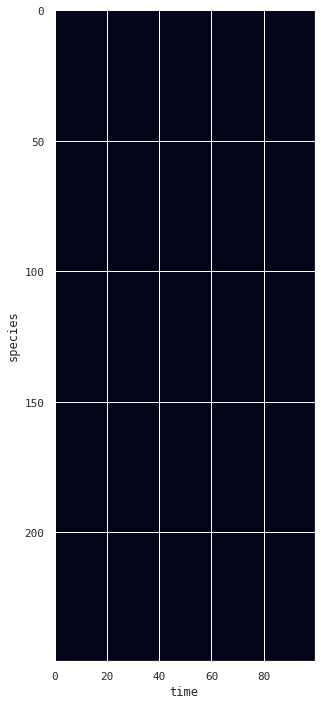

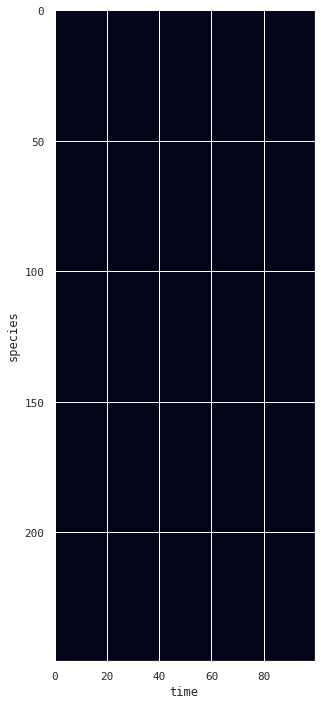

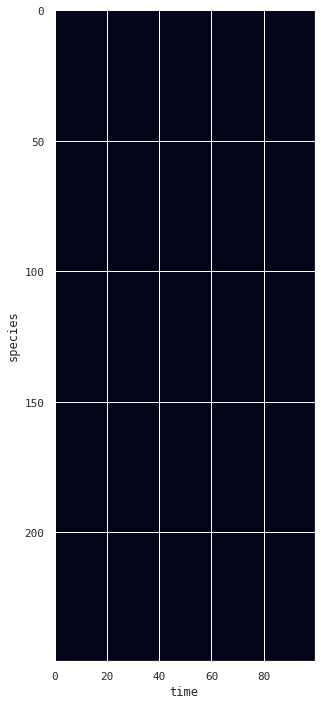

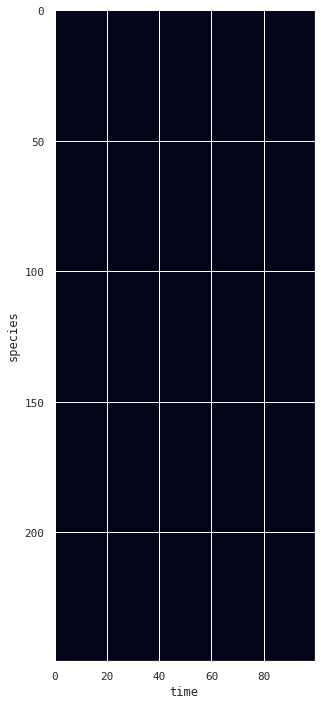

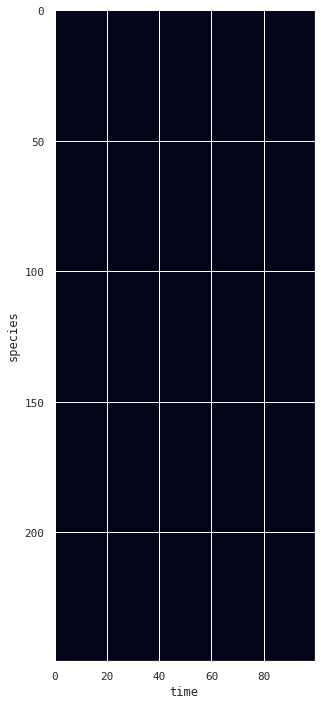

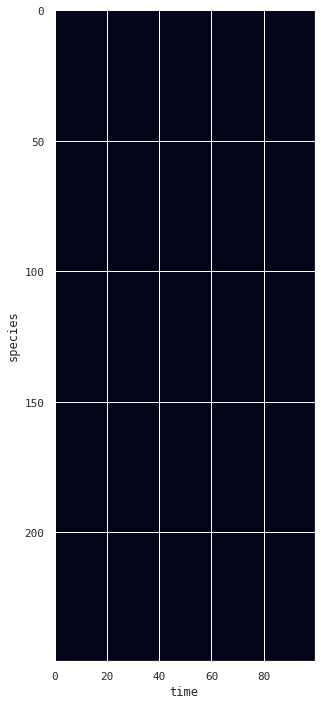

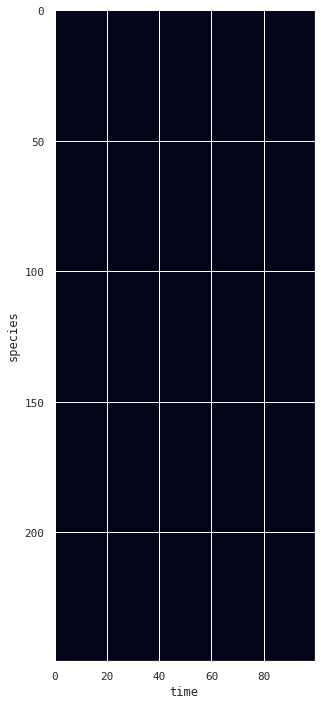

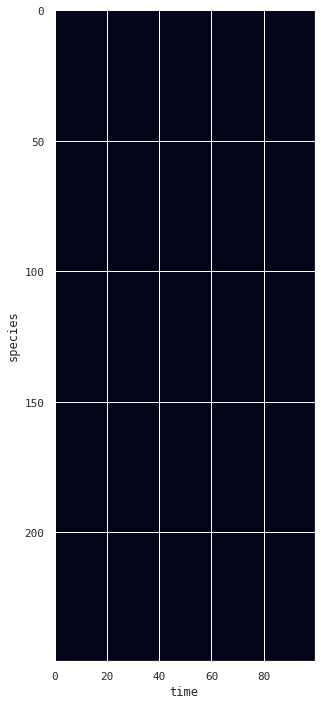

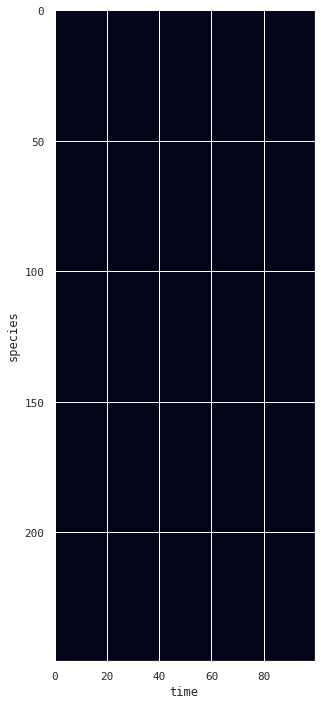

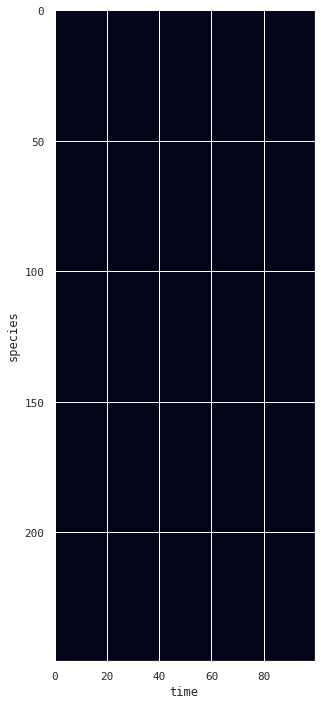

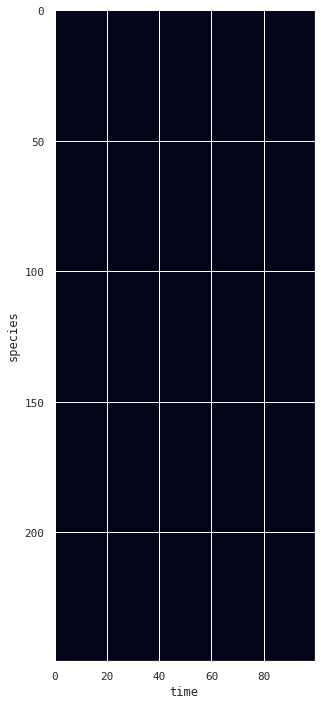

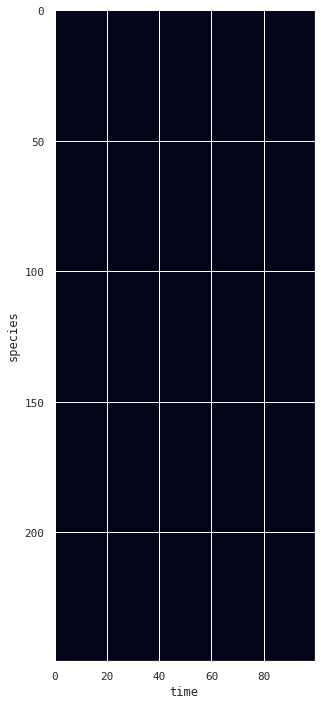

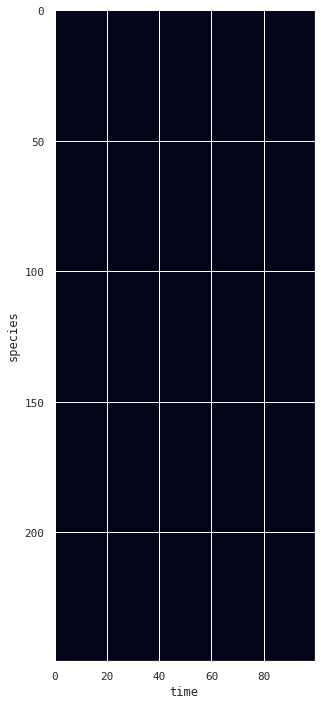

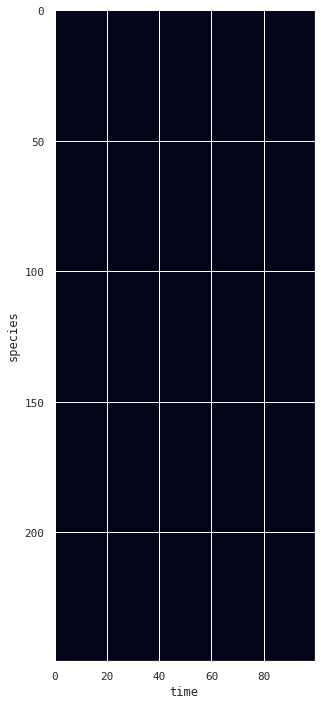

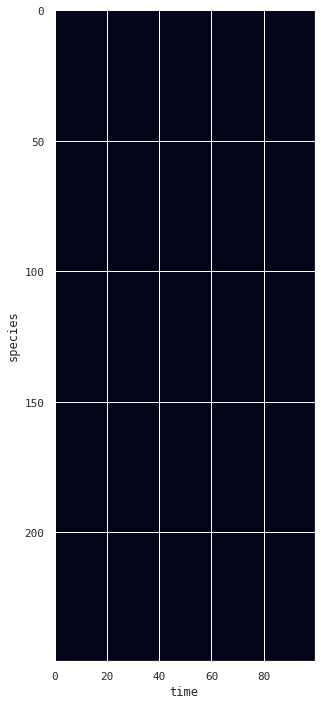

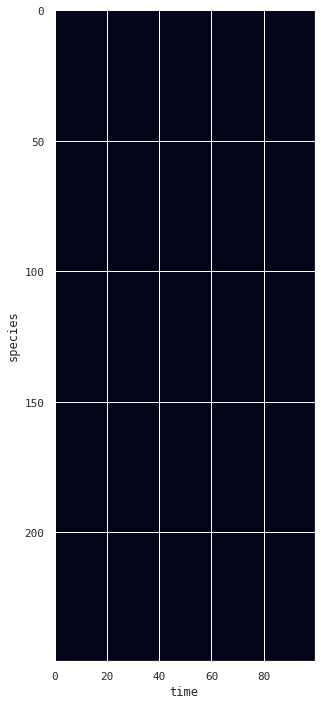

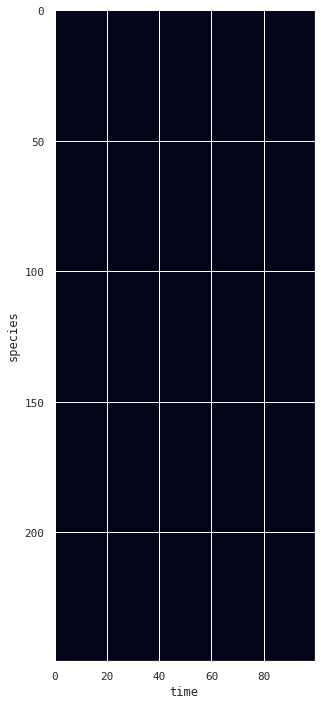

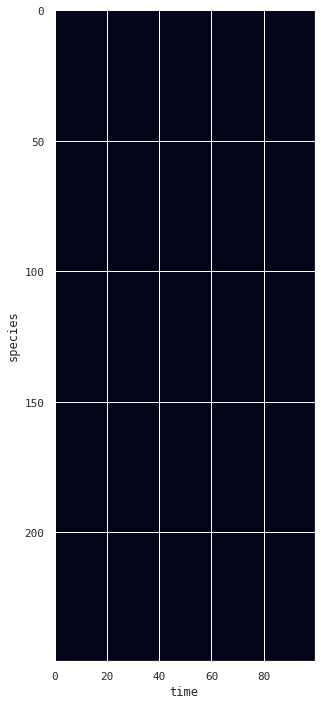

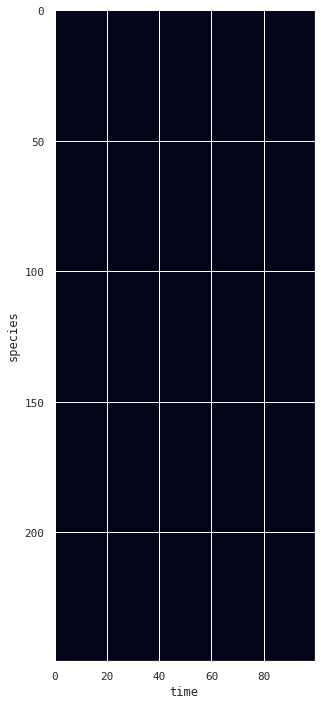

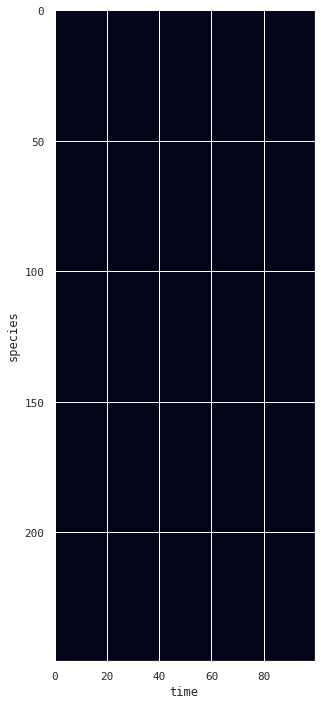

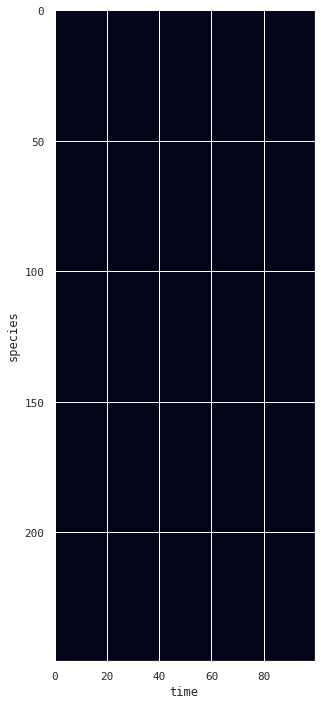

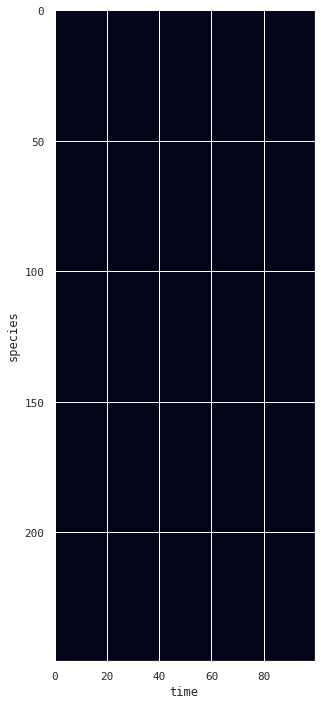

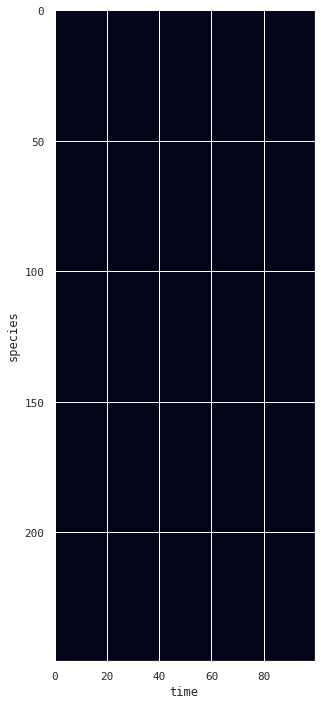

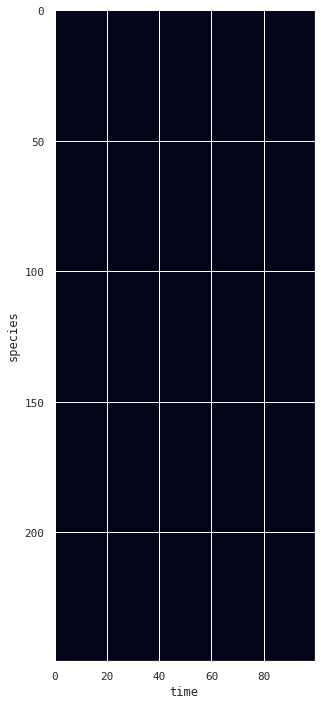

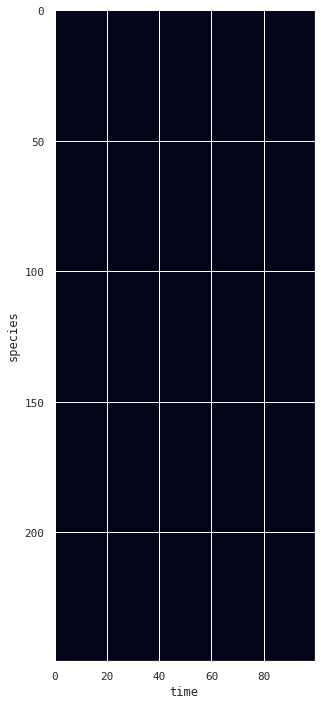

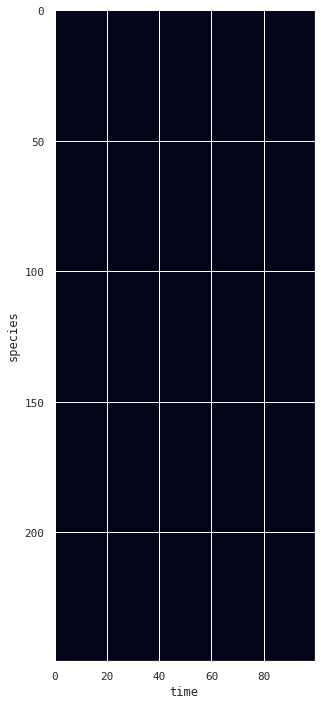

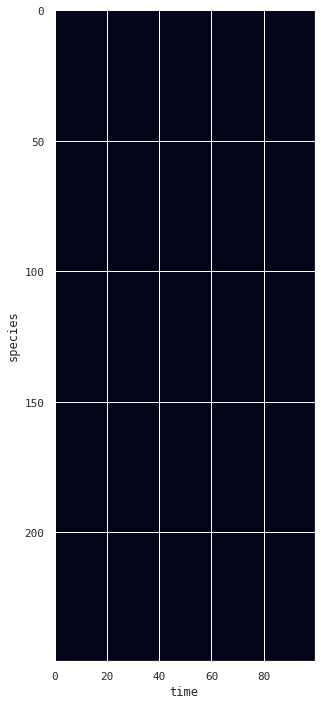

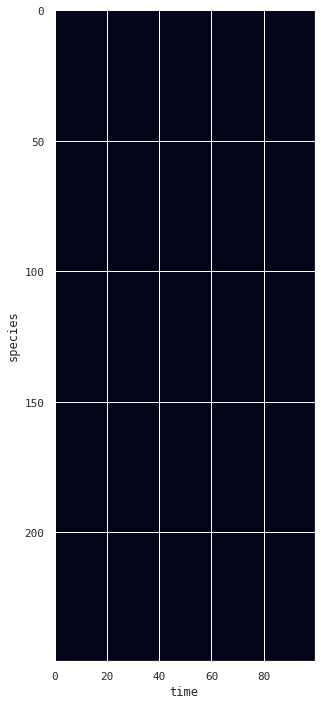

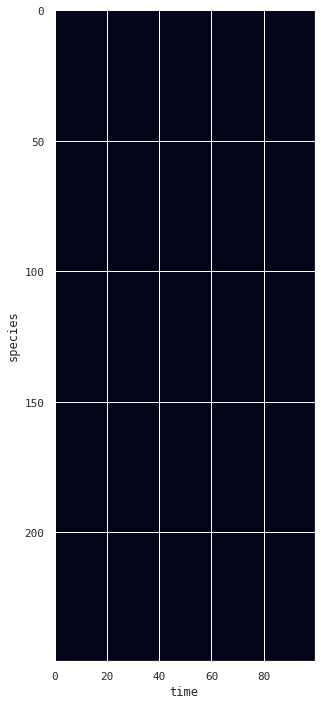

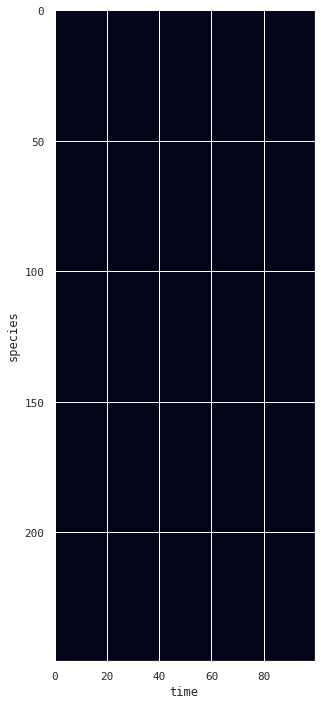

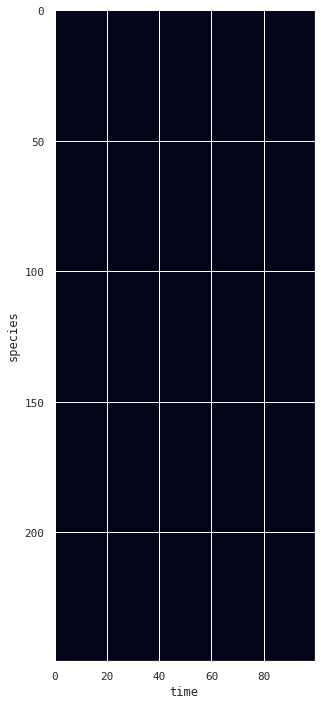

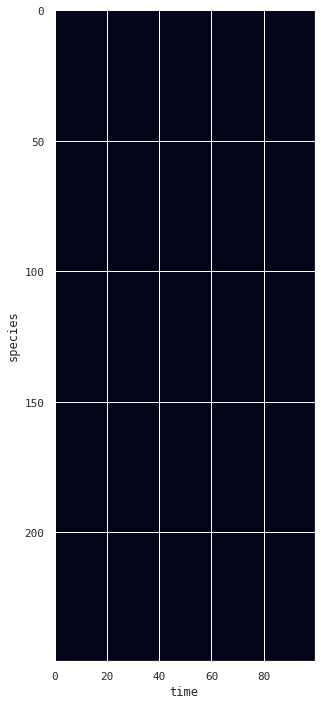

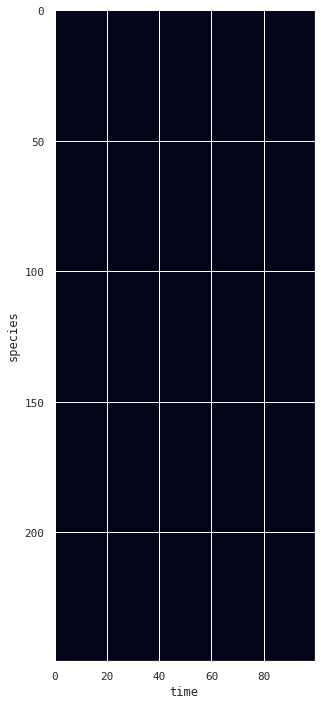

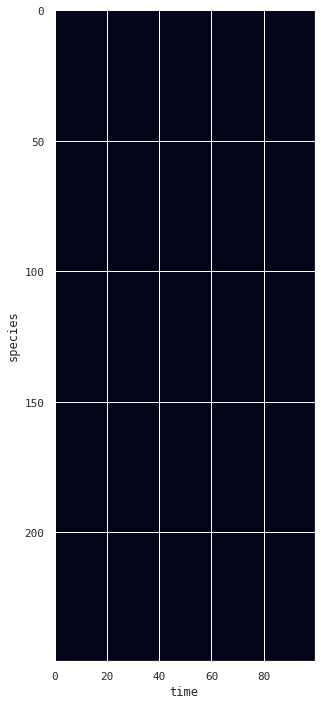

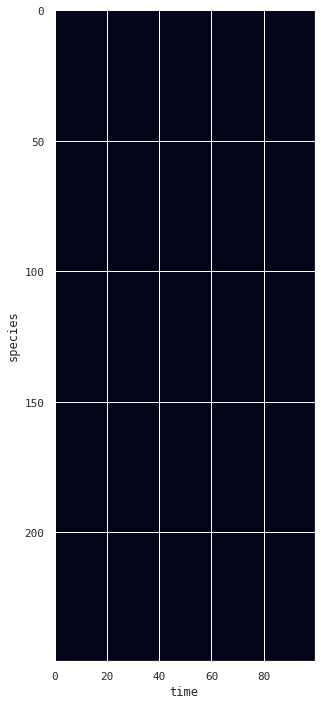

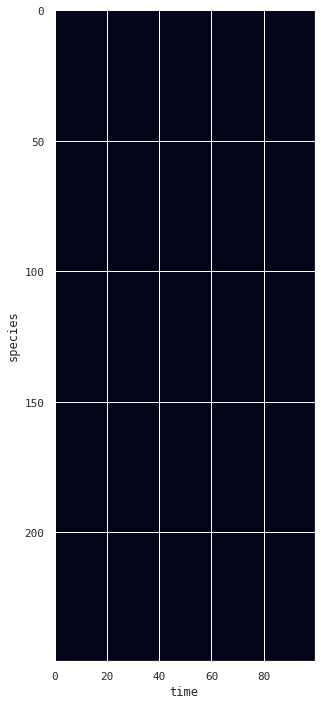

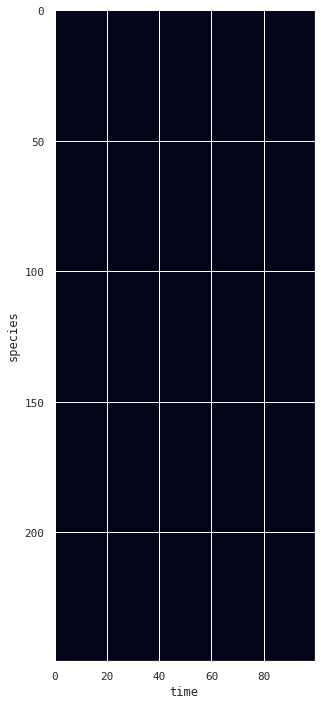

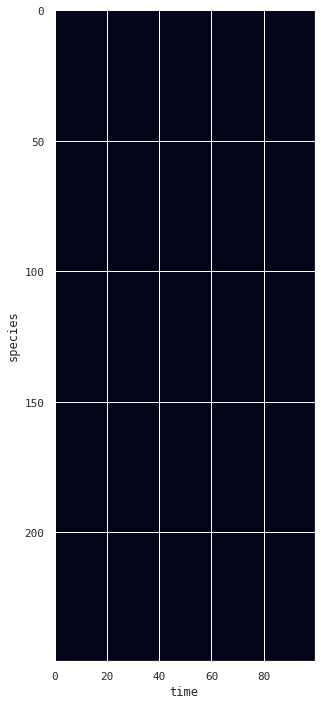

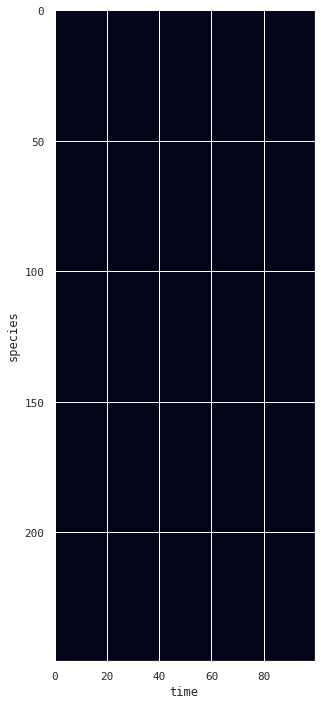

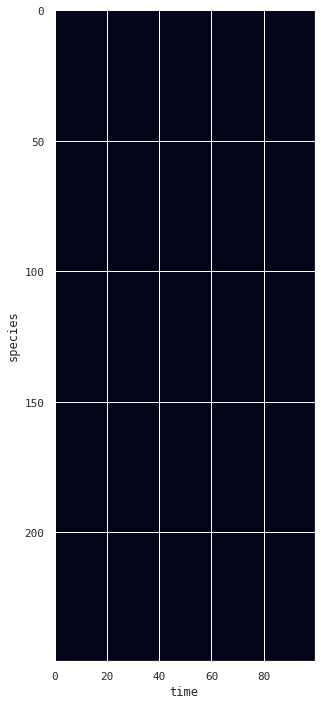

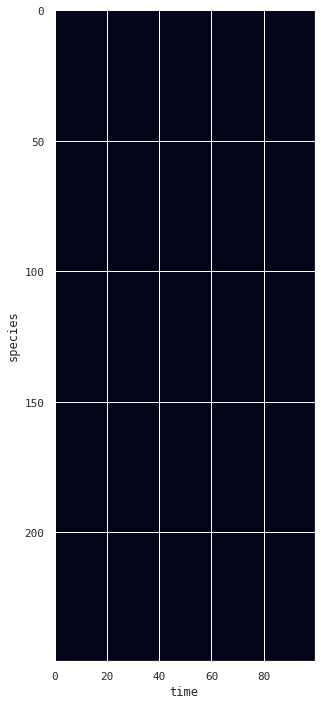

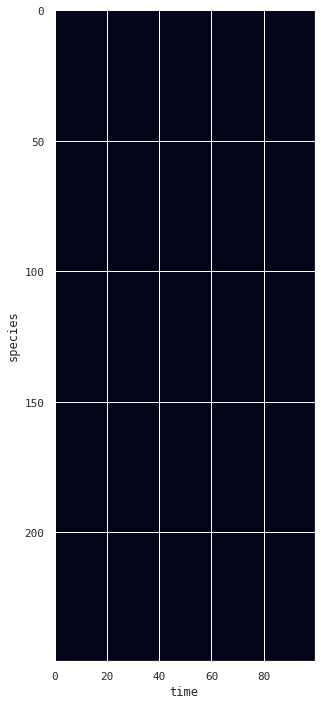

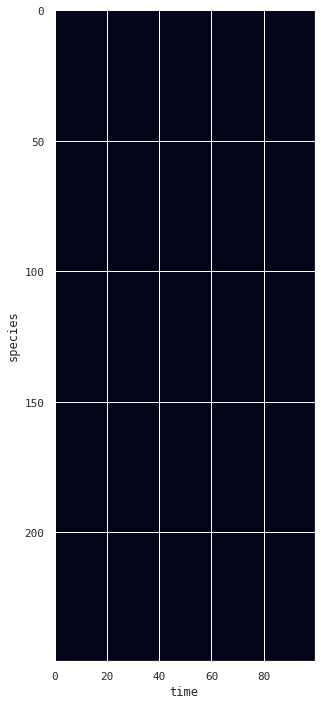

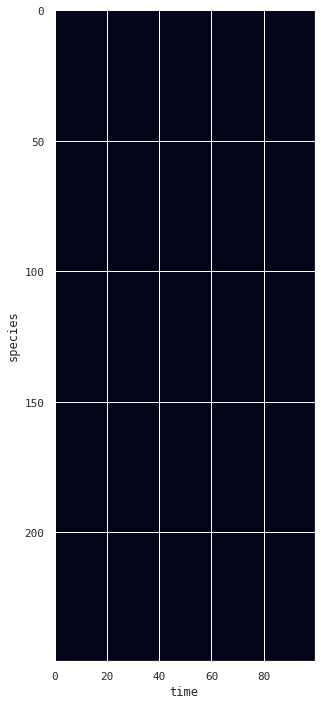

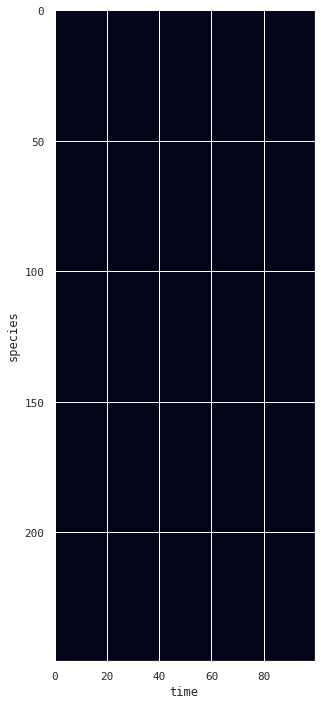

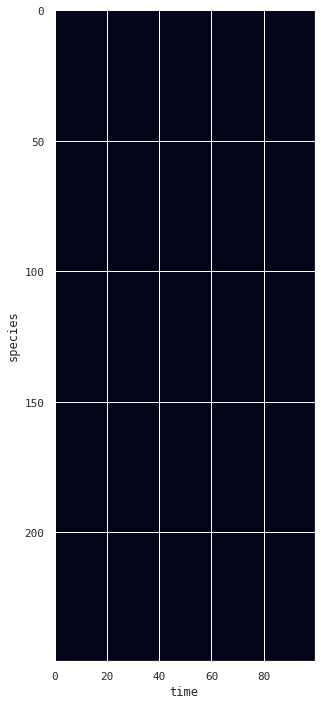

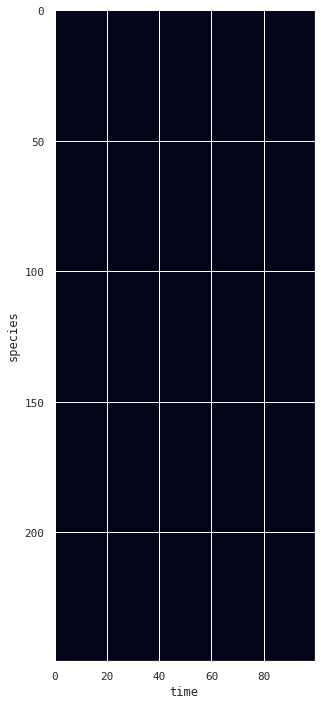

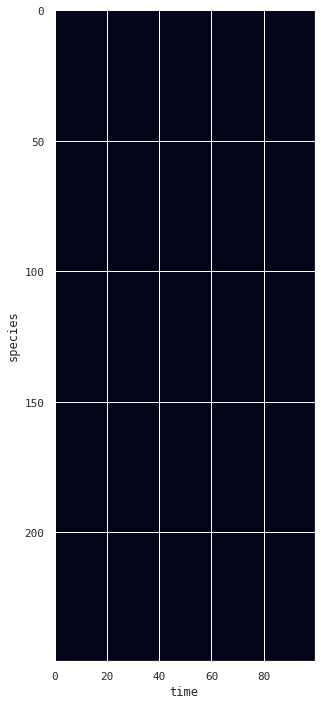

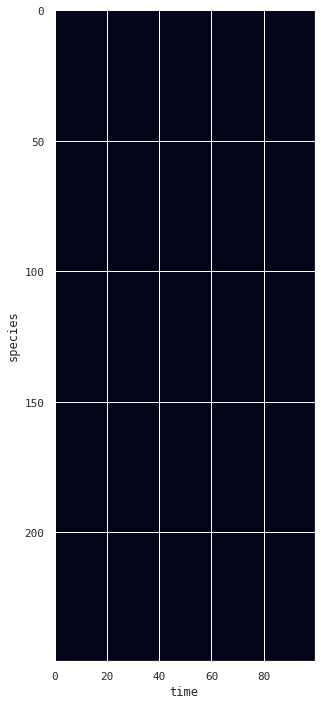

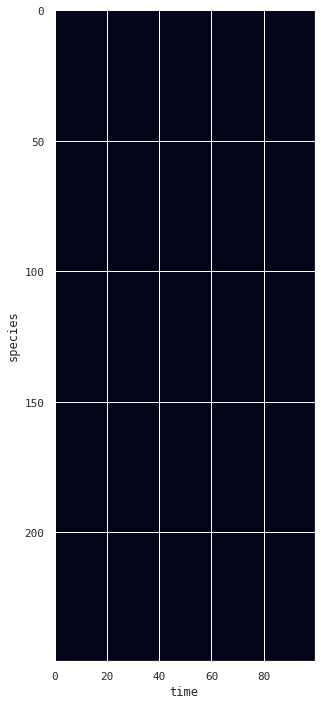

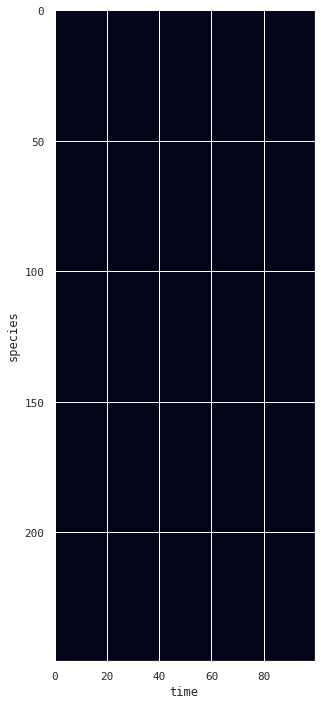

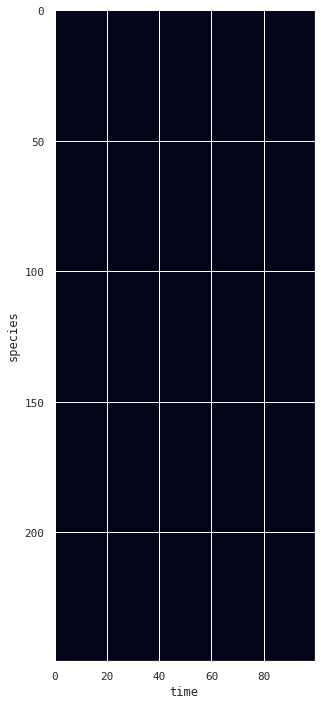

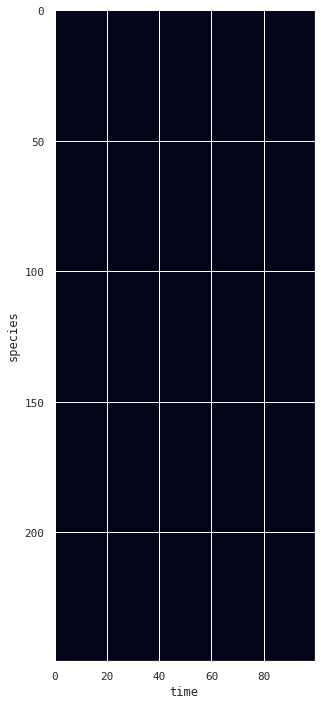

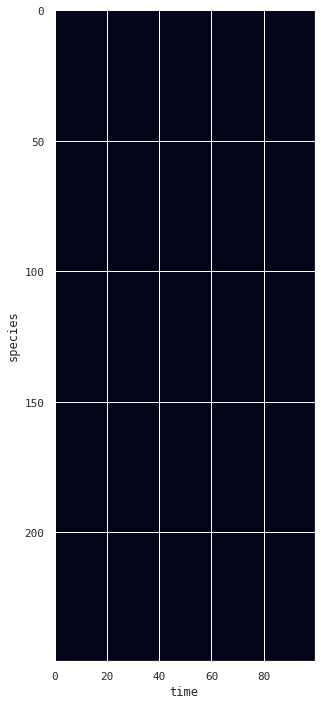

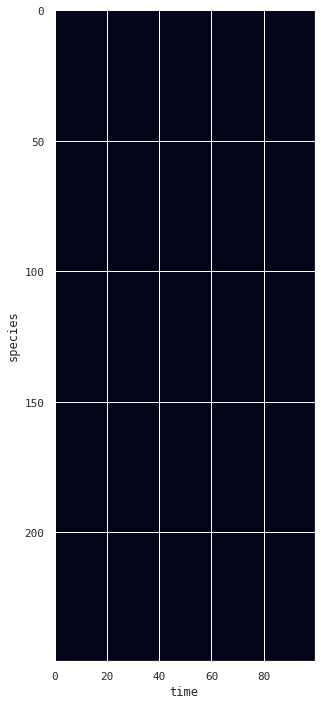

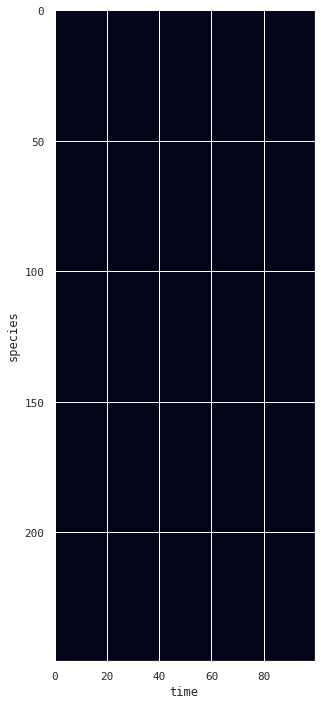

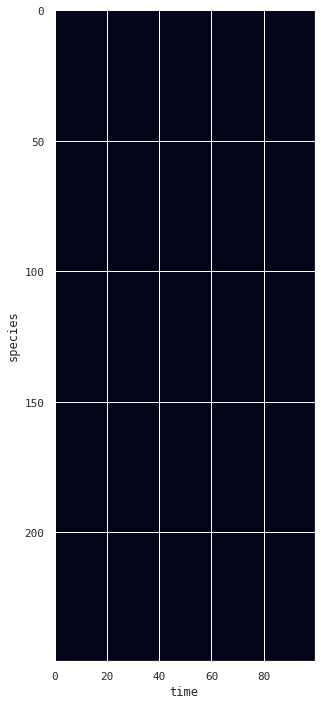

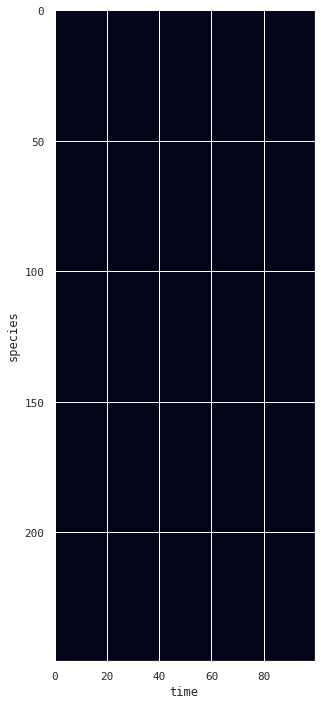

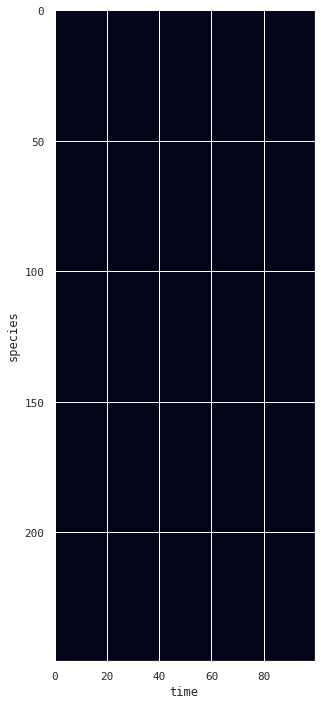

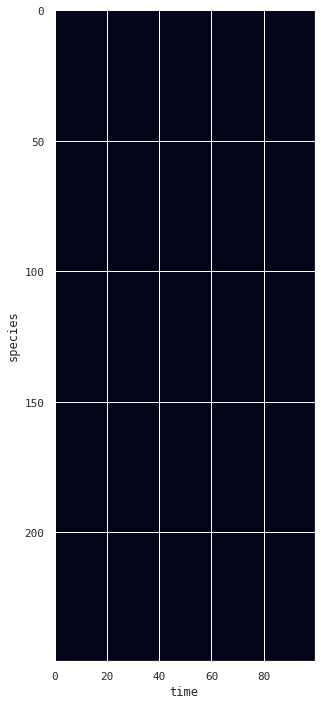

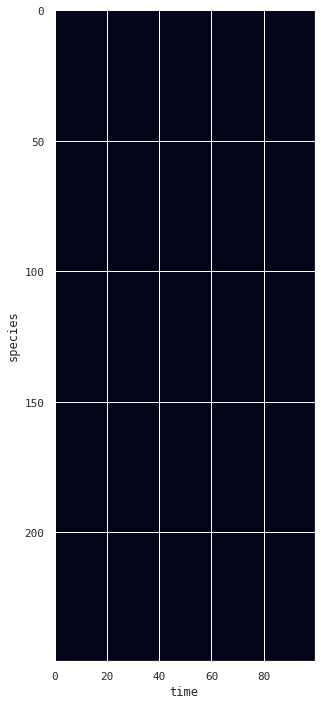

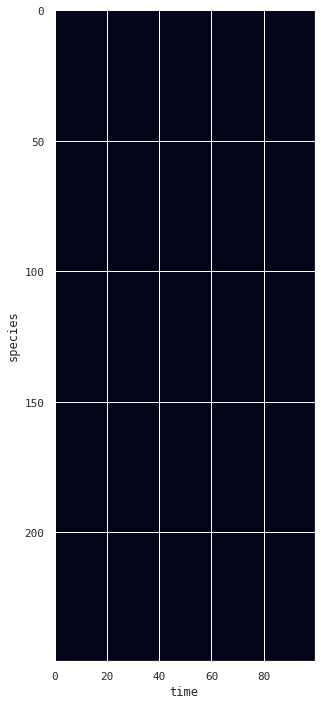

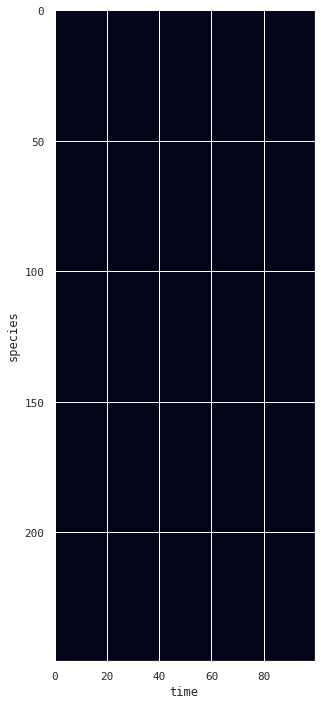

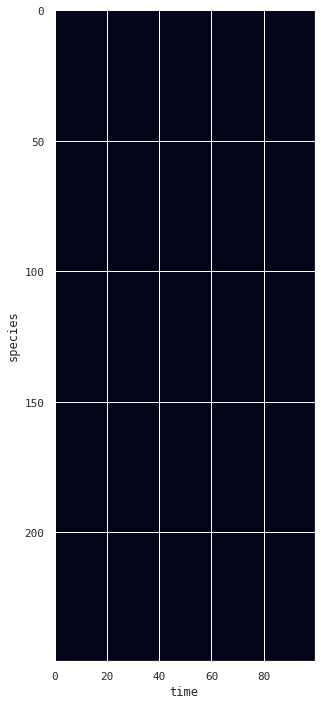

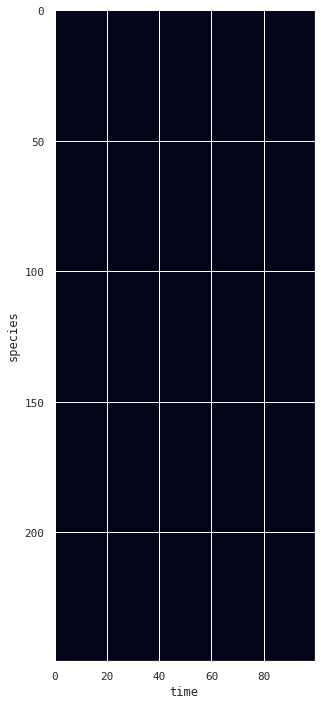

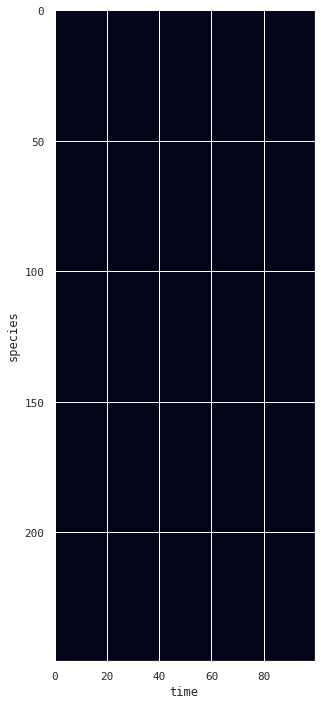

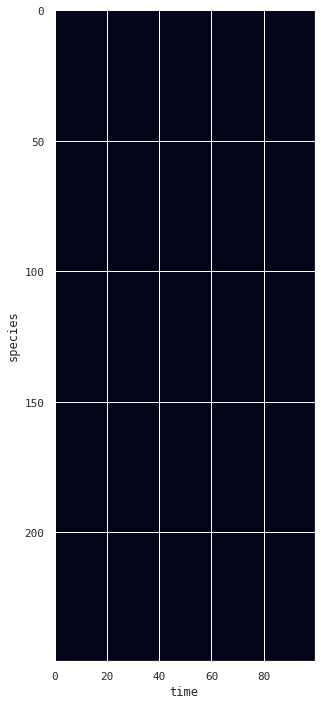

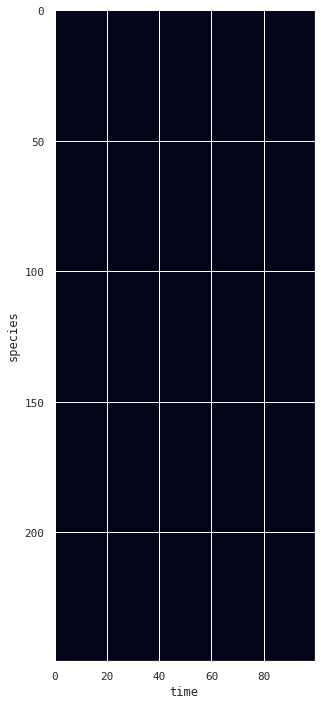

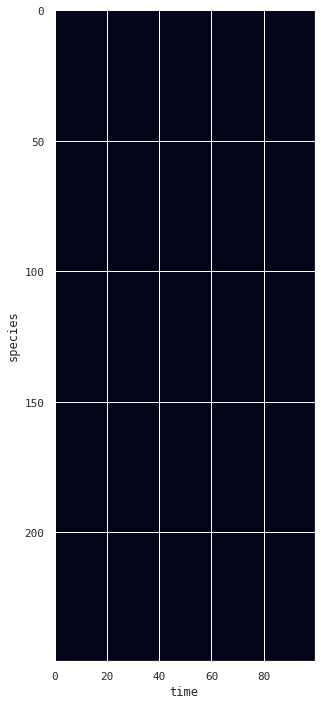

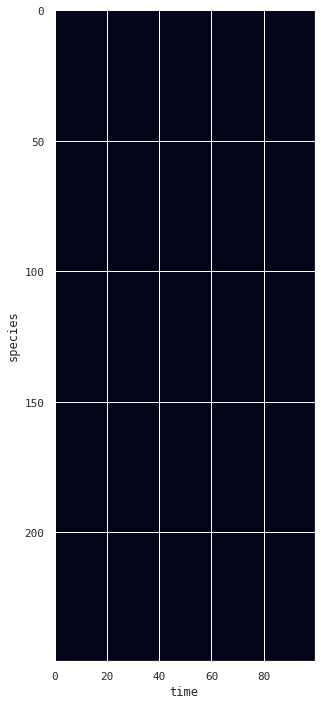

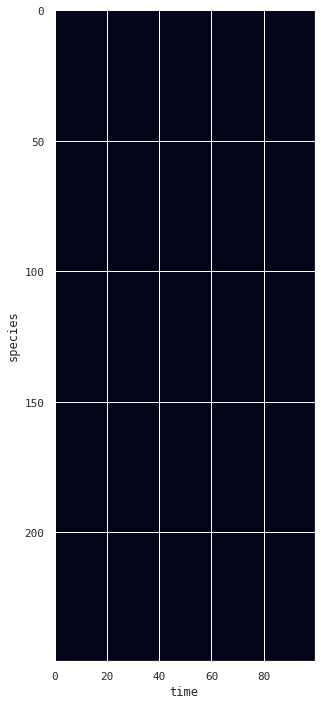

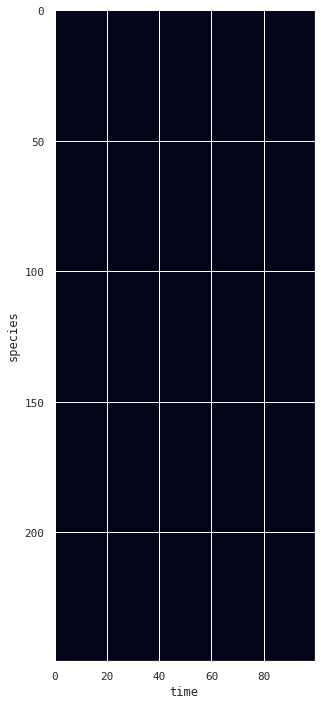

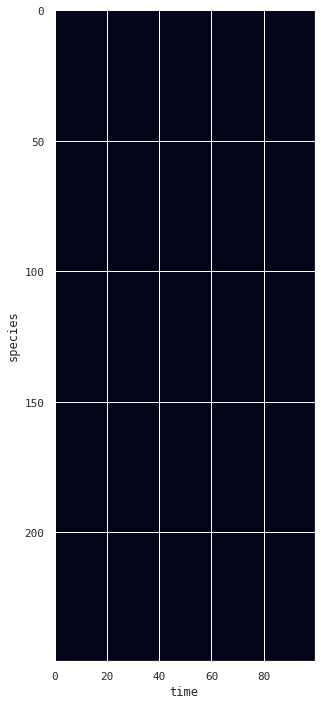

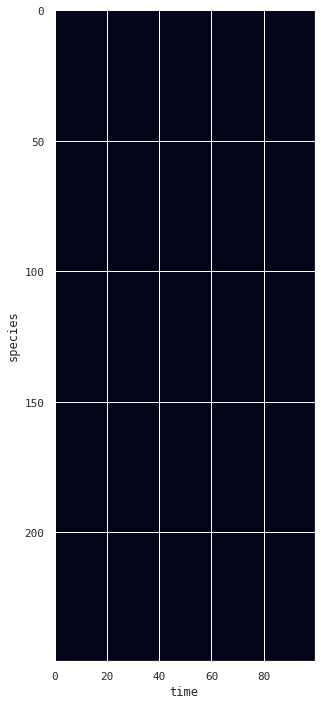

In [77]:
resultSave3 = []
for i in range(0, 100):
    interactionMatrix3, nodes3= Hypothesis3(C_tree, 4.42, C, rho, rho, remain_distance, intra, remain_distance, inter, Constant)
    sample3 = simulation(len(leaves), interactionMatrix3, 0.00001, 'z')
    resultSave3.append(plot_dieout(sample3))
print(resultSave3)

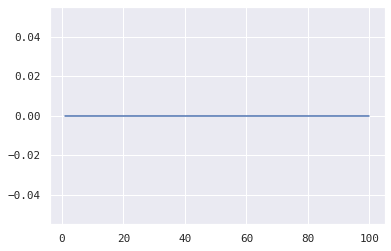

In [78]:
plt.plot([x for x in range(1,101)], resultSave3)

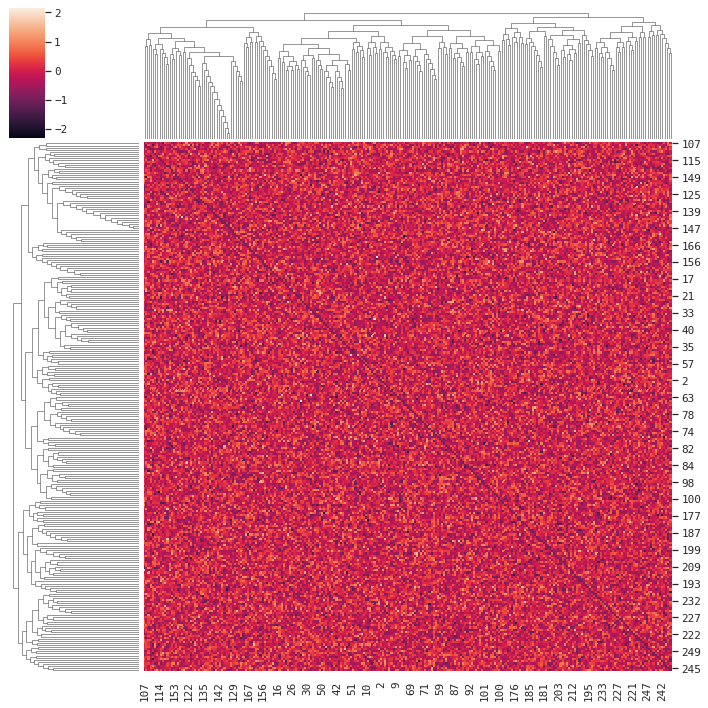

In [111]:
#Hypothesis 4
interactionMatrix4, leaves_name4 = Hypothesis4(C_tree, sigma_hp4, Constant)
seaborn_plot(interactionMatrix4, leaves, distMatrix)

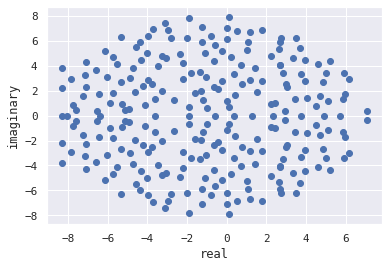

In [80]:
# Eigen value:
eigenValVecoter(interactionMatrix4)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized


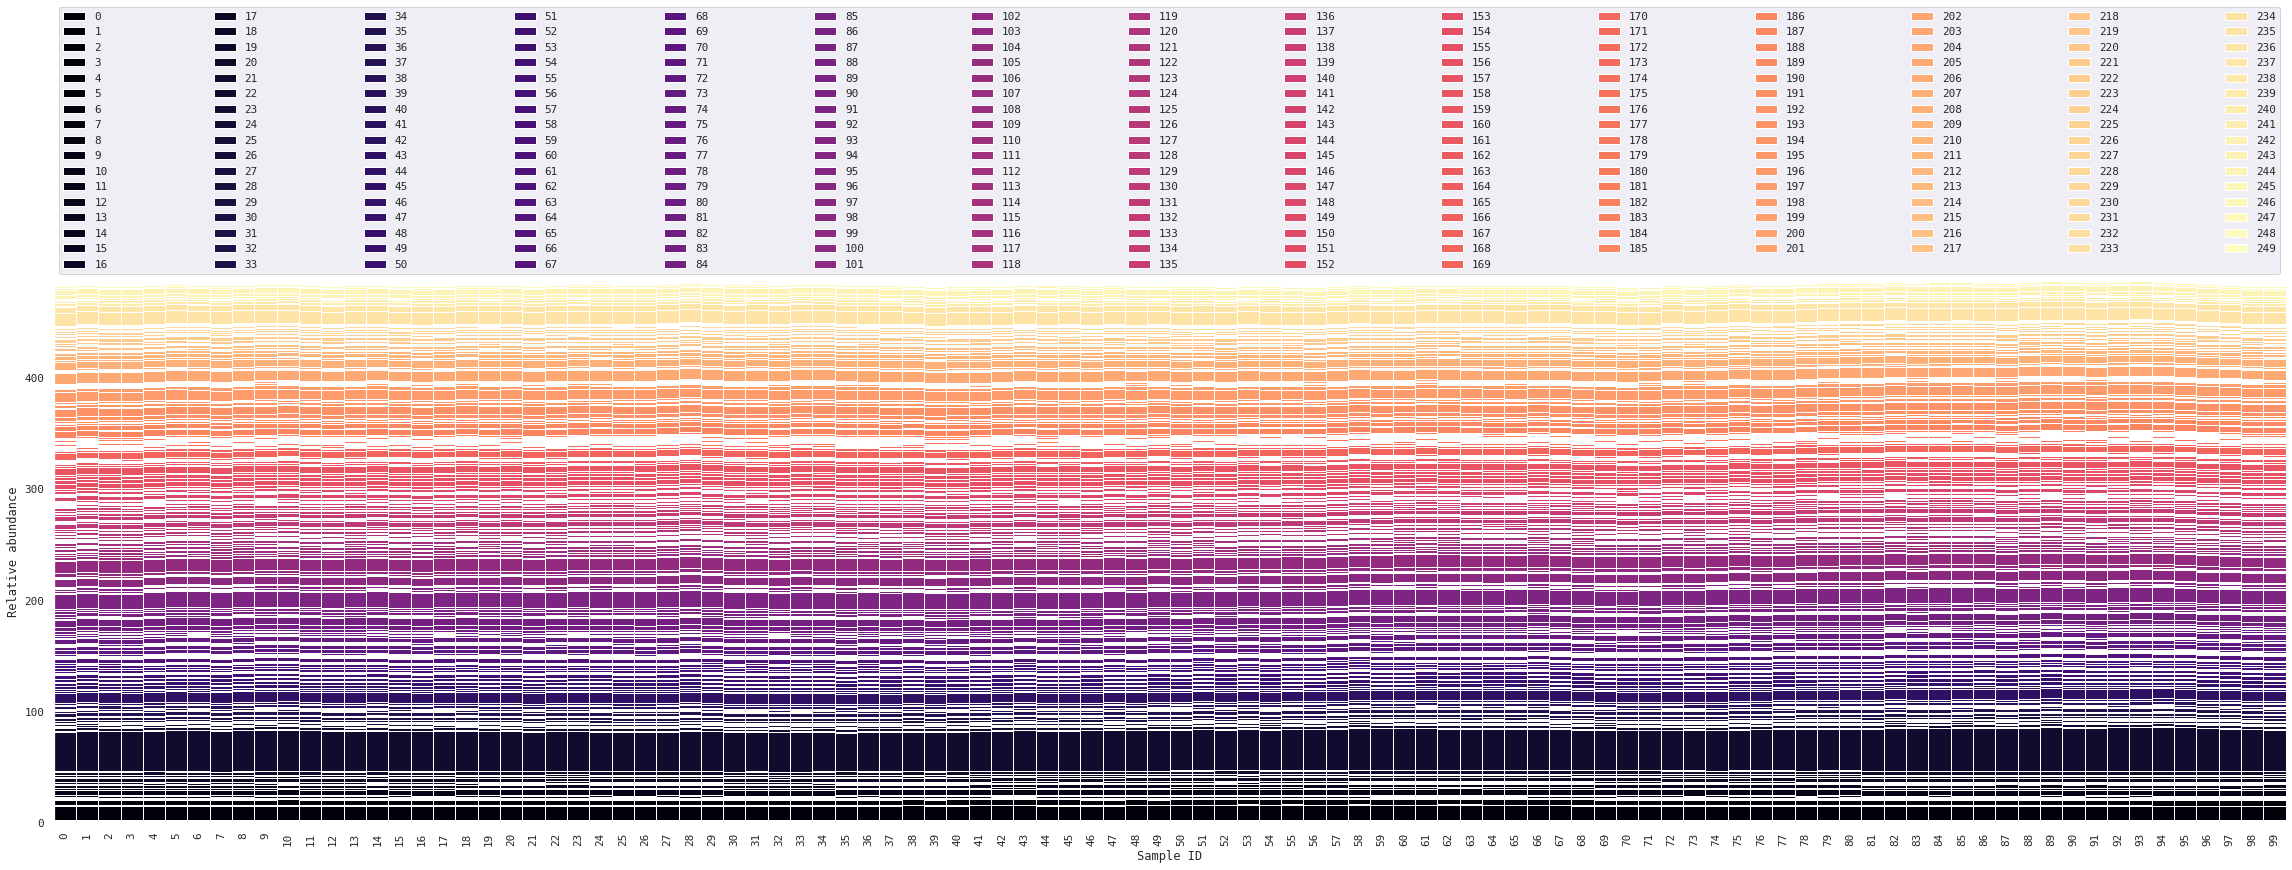

In [112]:
sample4 = simulation(len(leaves), interactionMatrix4, 0.00001, 'z')

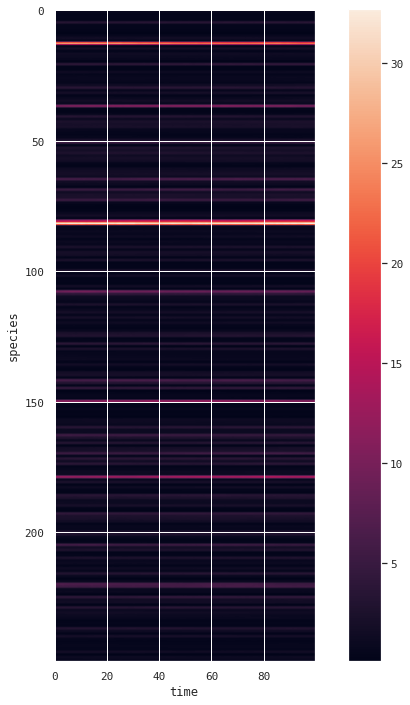

In [91]:
plot_interaction(sample4)

0.0

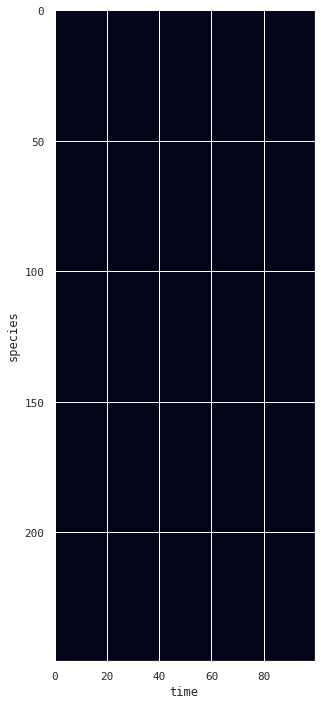

In [92]:
plot_dieout(sample4)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:25

<ipython-input-30-0506df2a79e1>:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,12))


Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:25

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized
Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:25

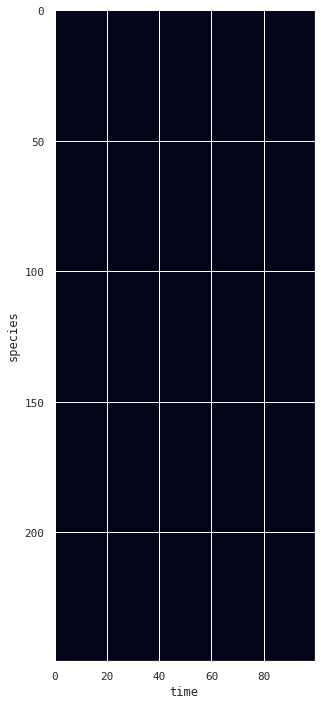

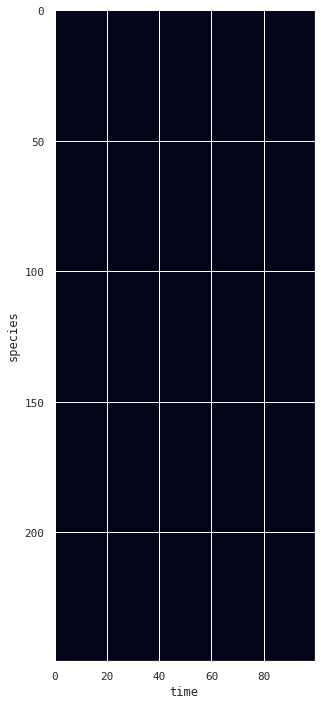

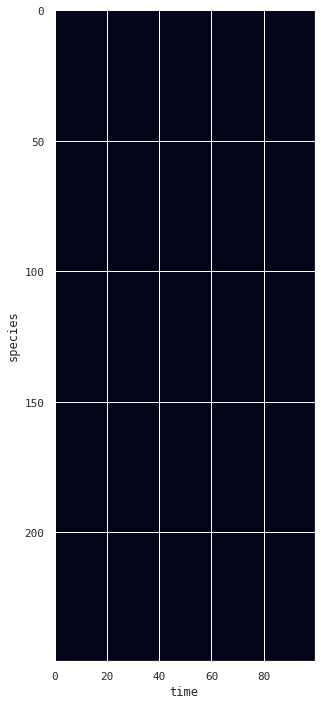

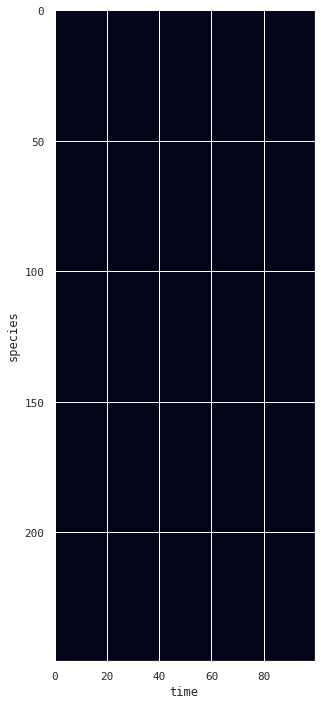

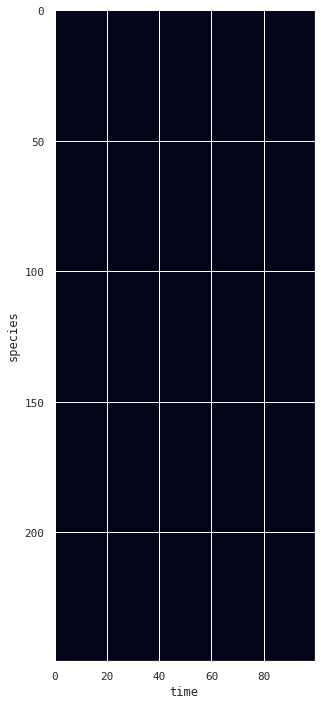

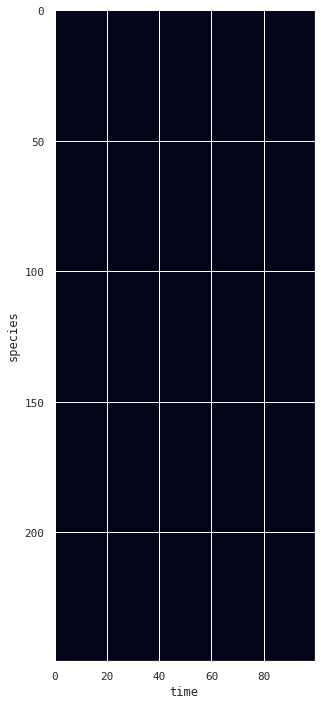

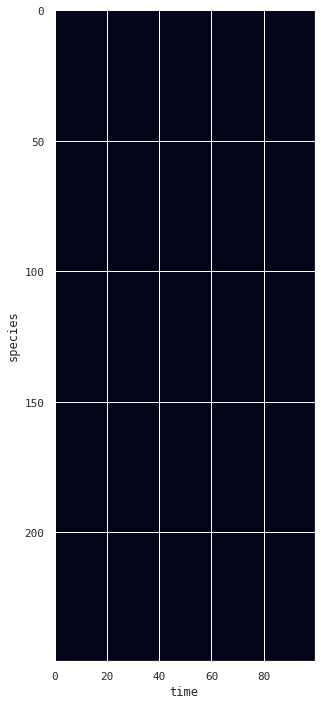

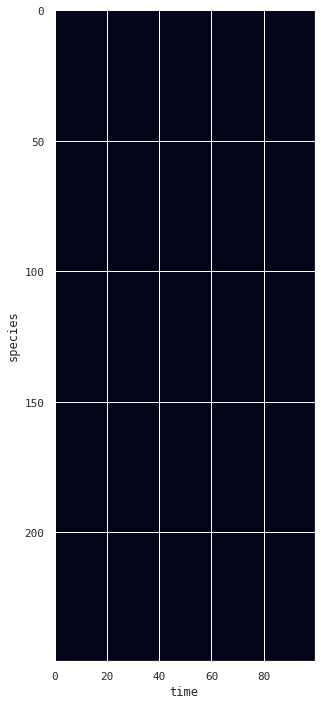

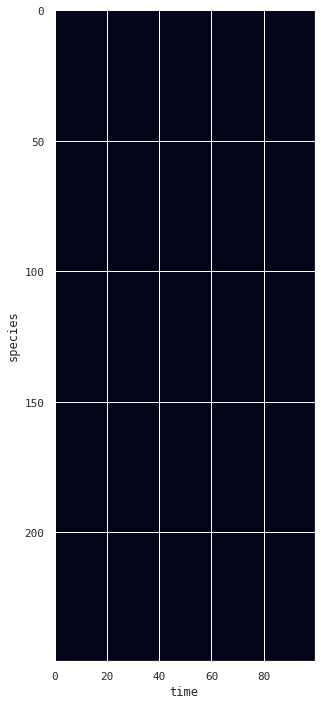

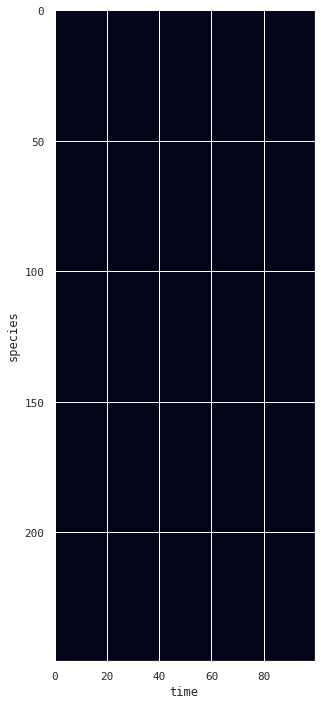

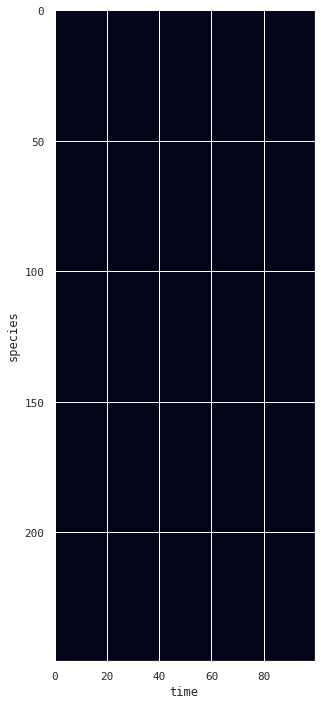

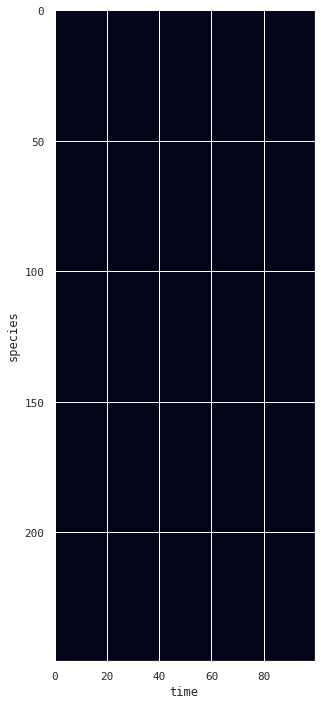

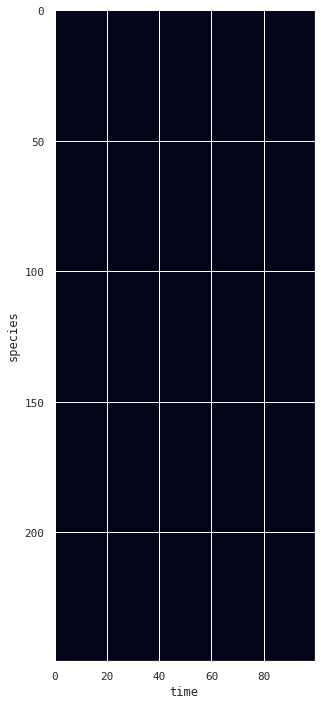

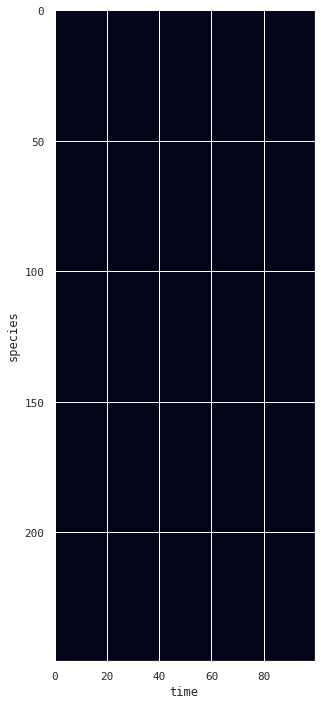

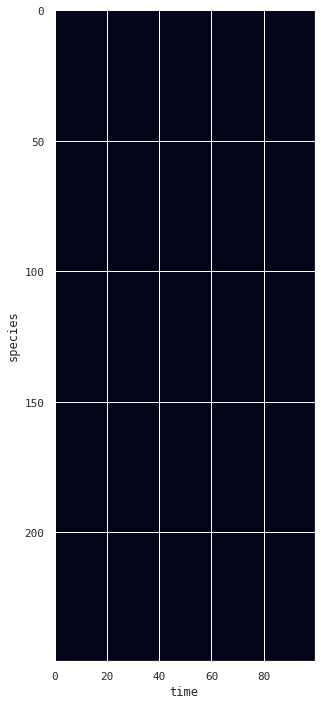

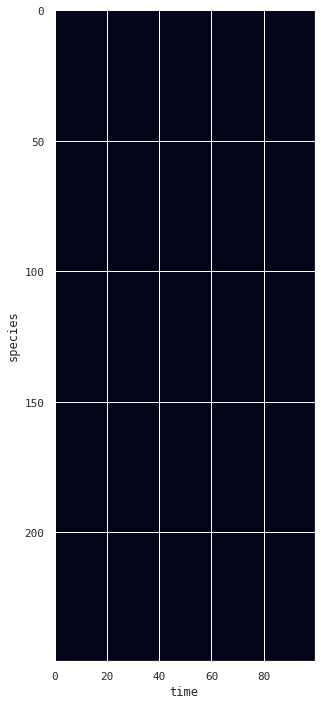

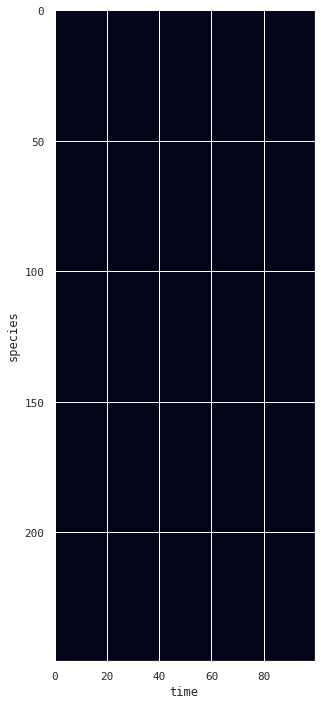

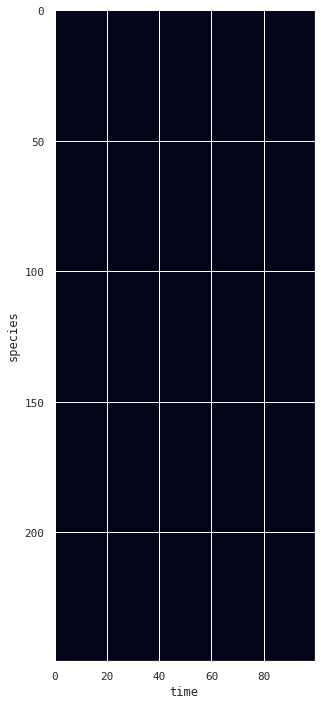

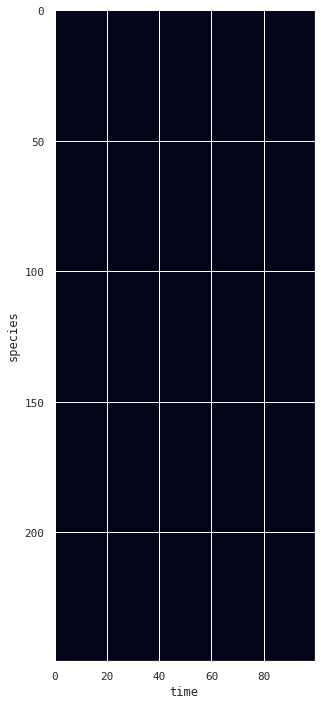

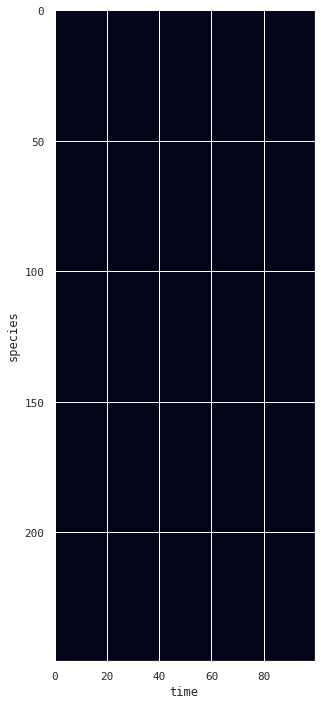

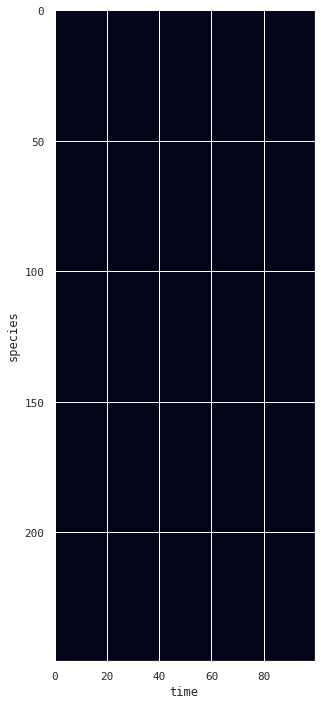

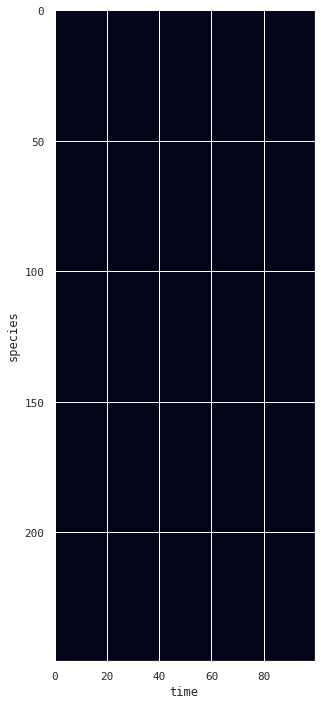

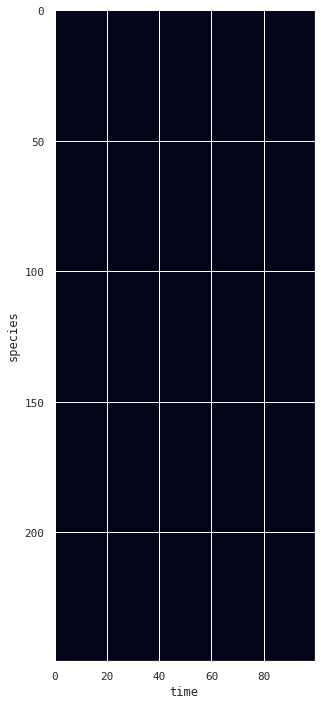

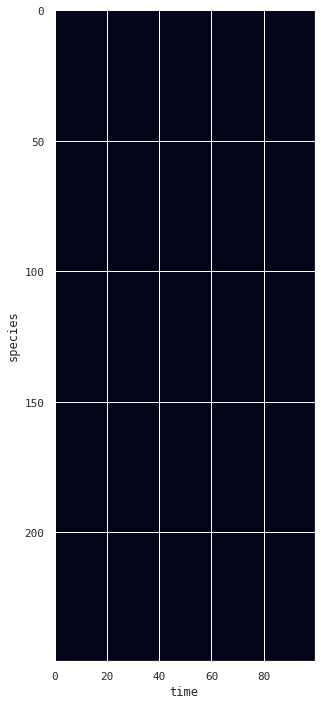

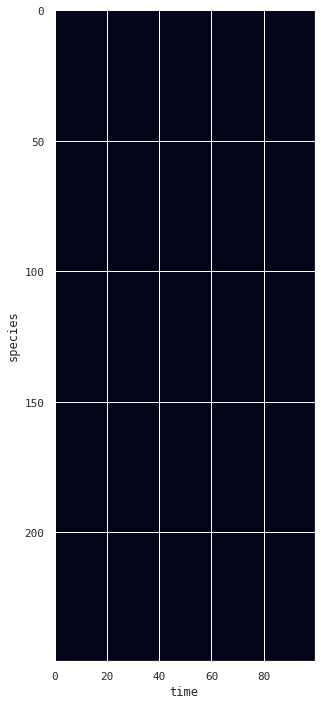

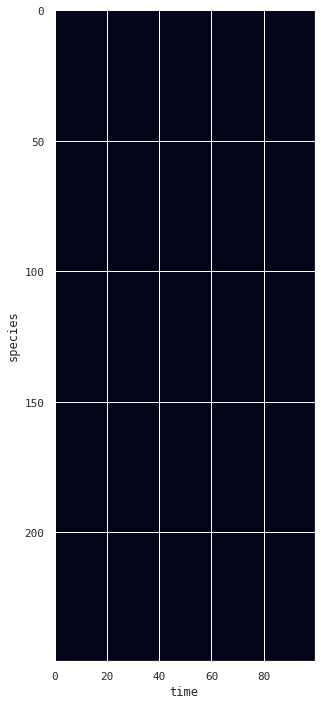

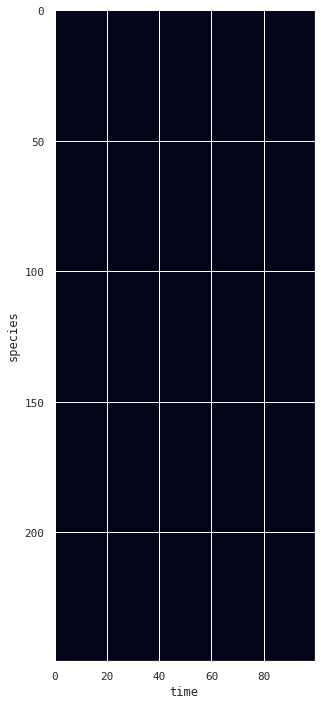

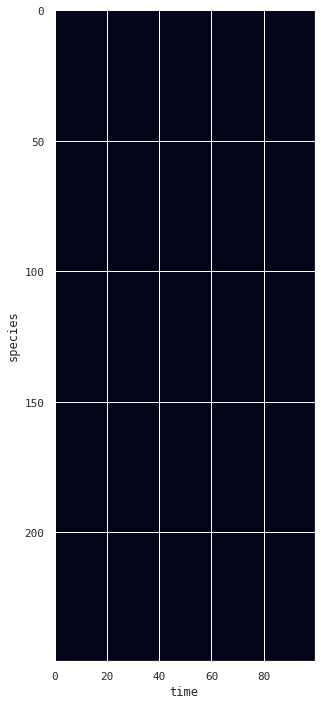

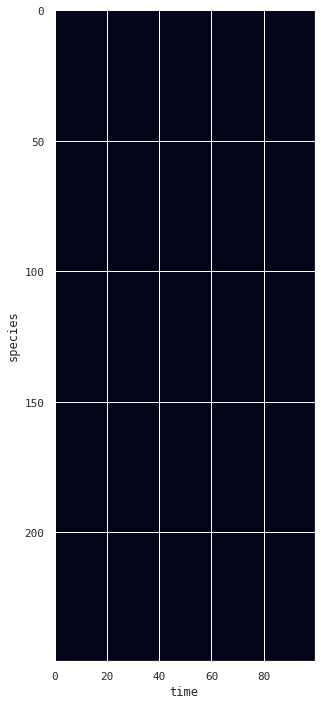

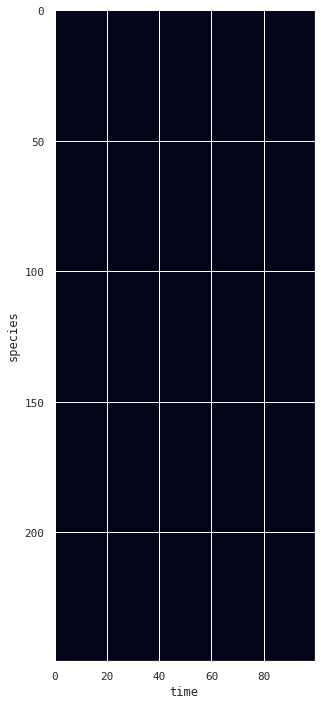

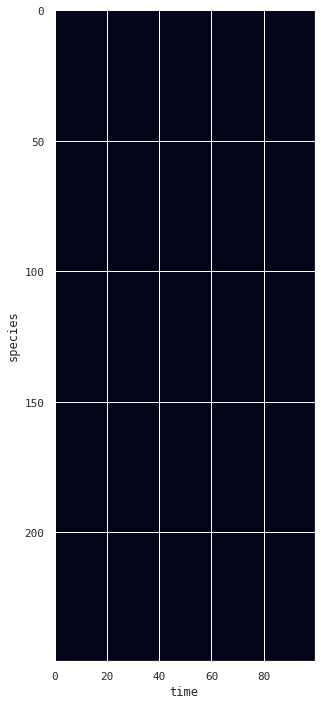

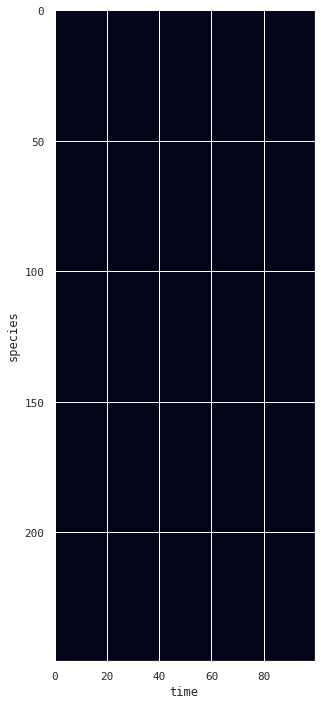

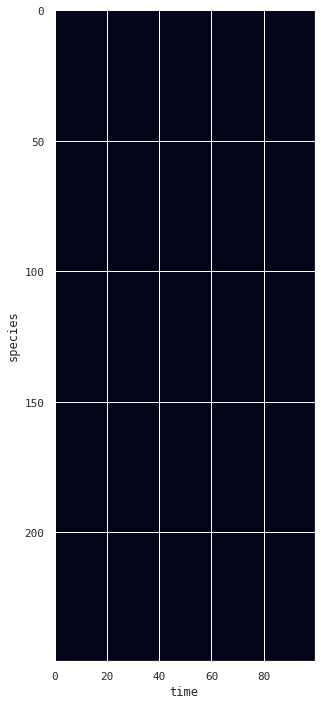

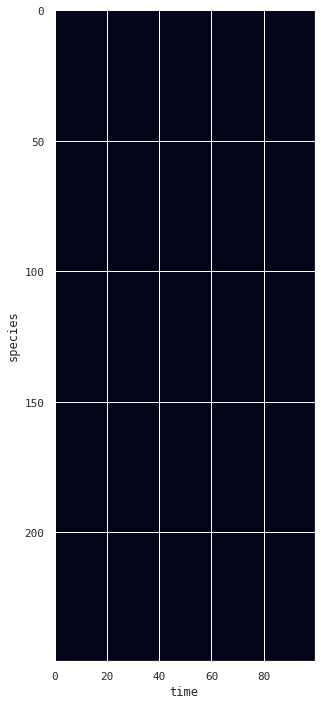

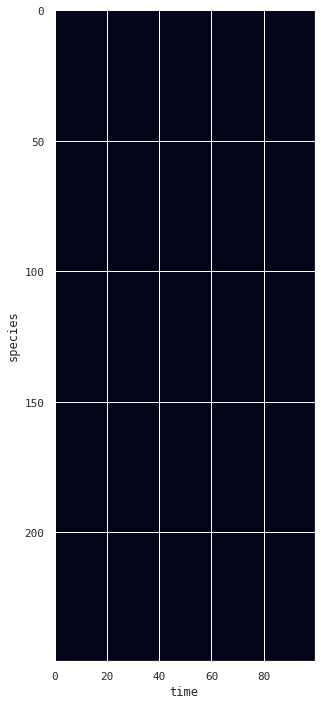

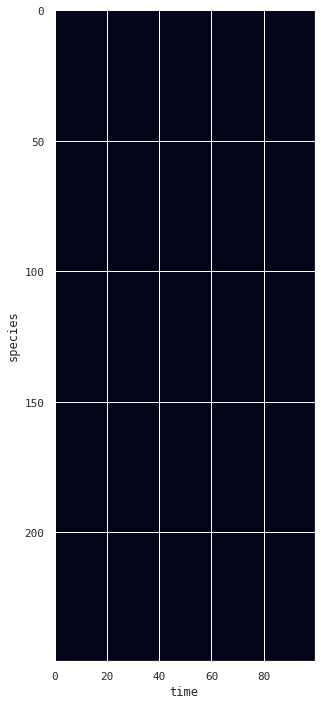

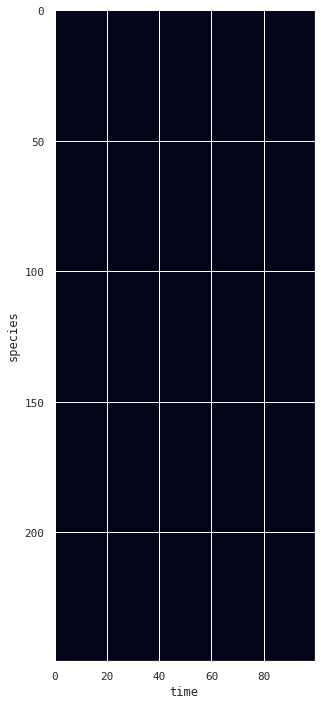

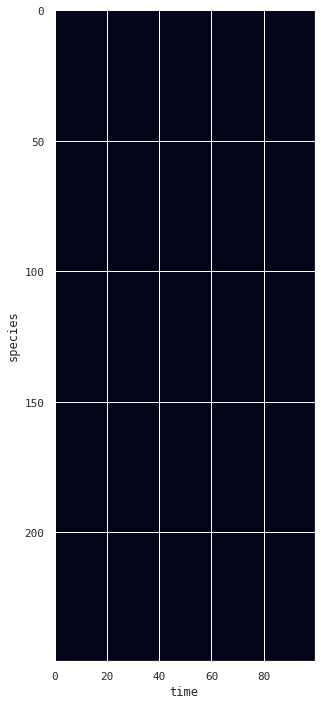

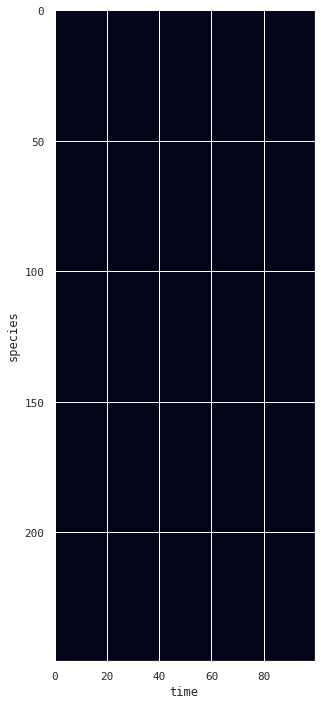

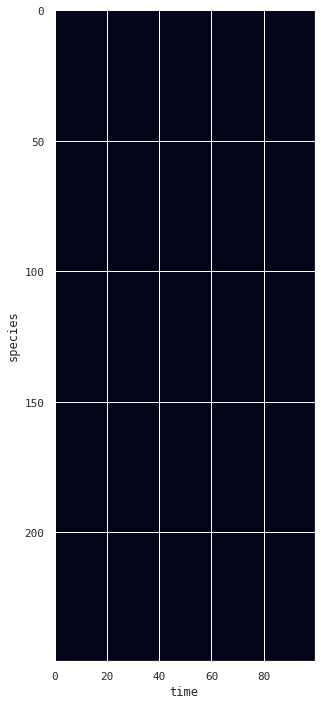

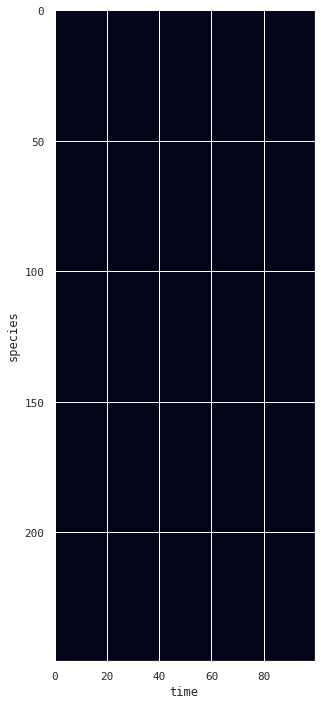

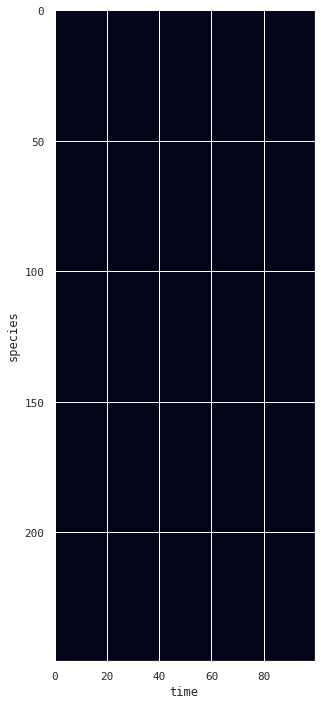

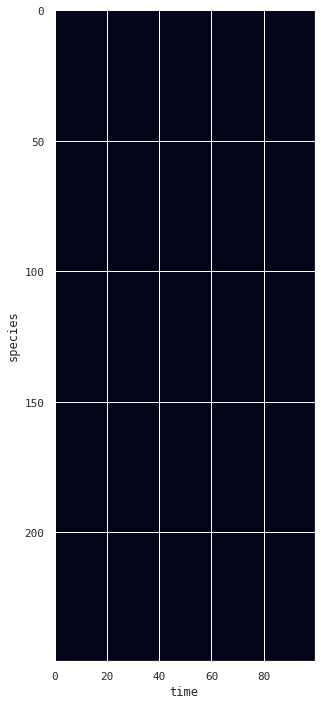

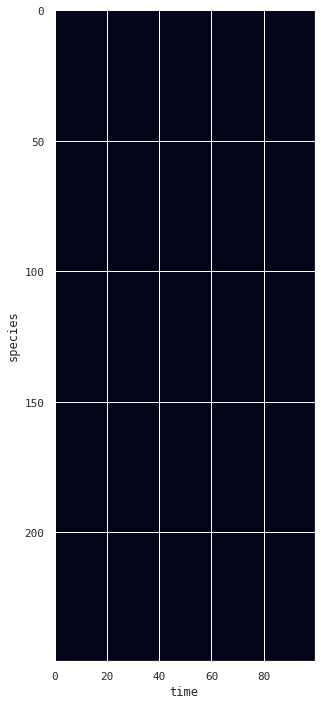

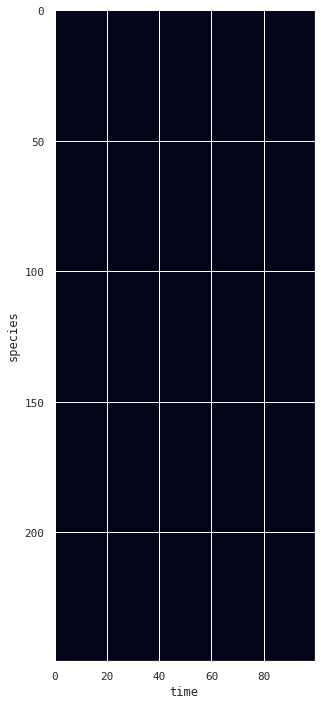

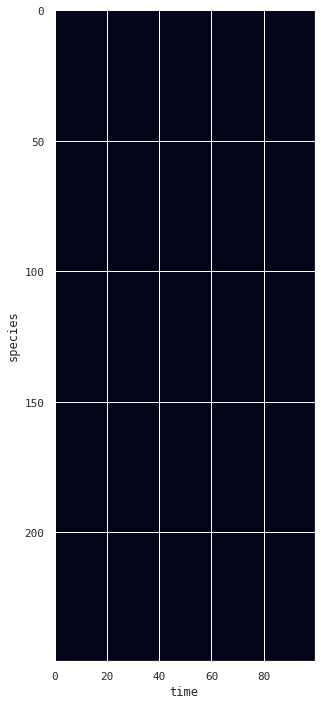

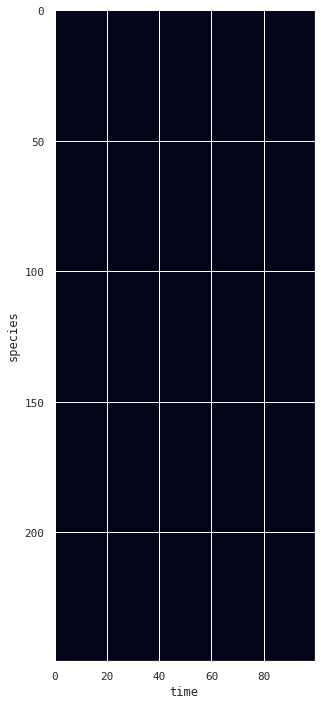

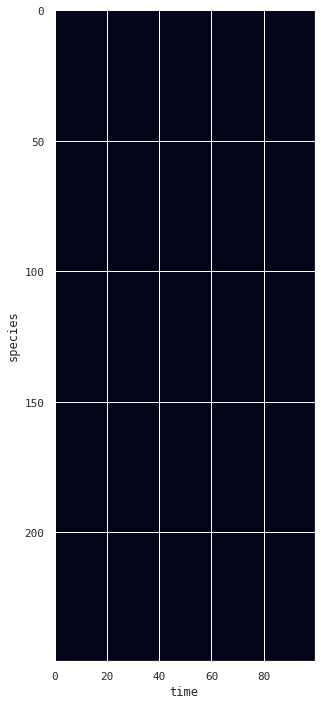

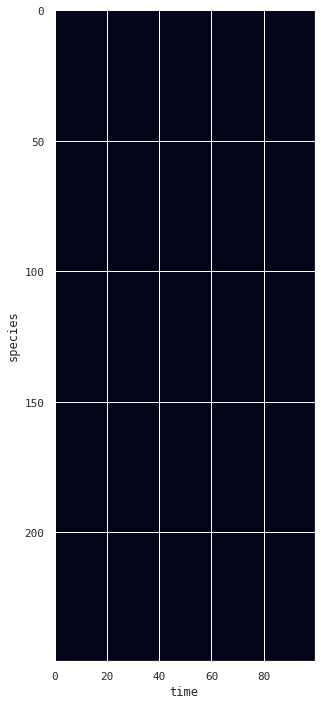

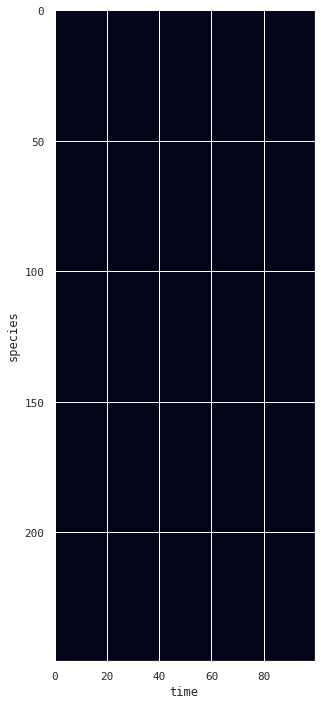

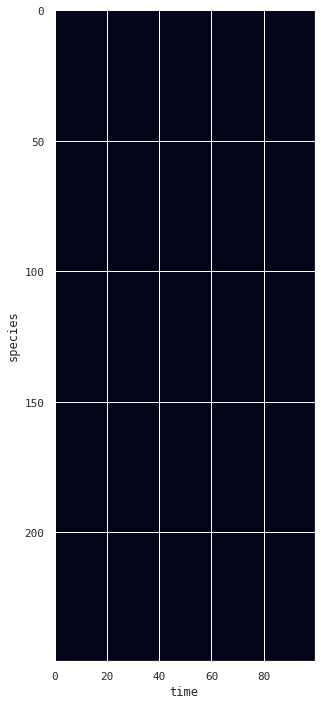

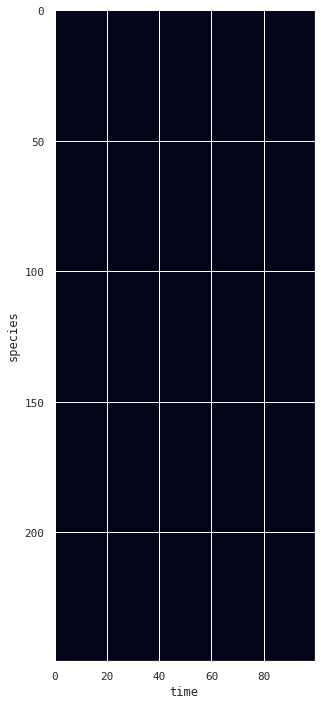

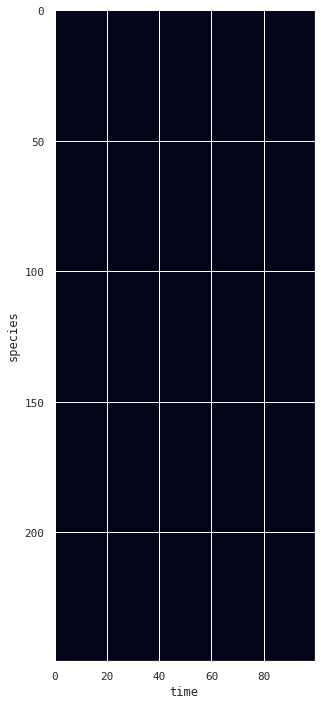

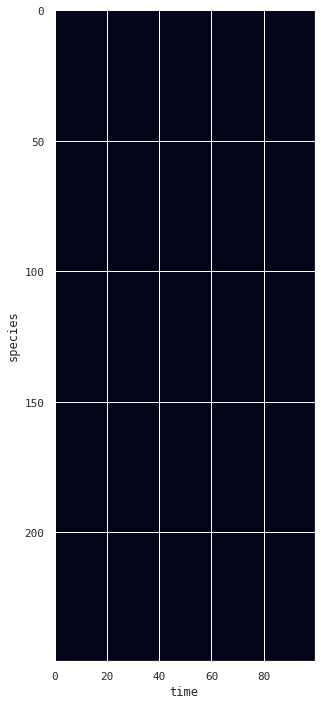

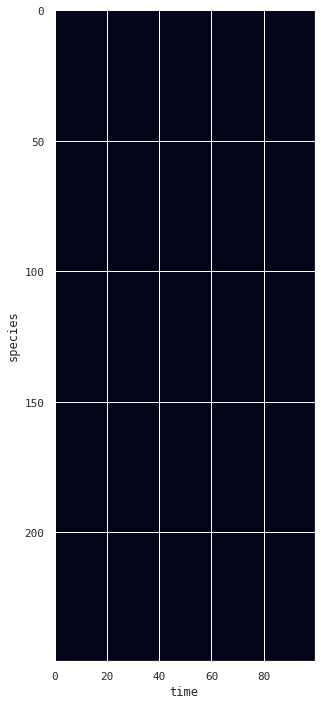

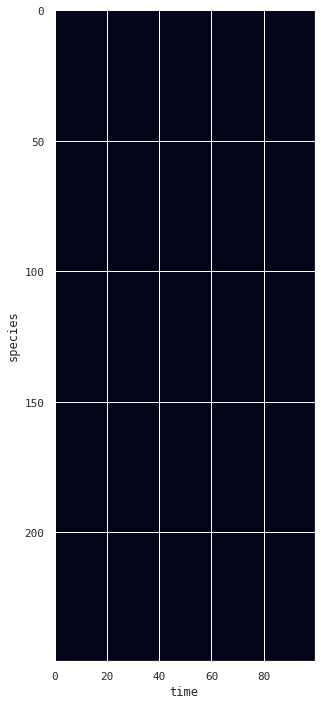

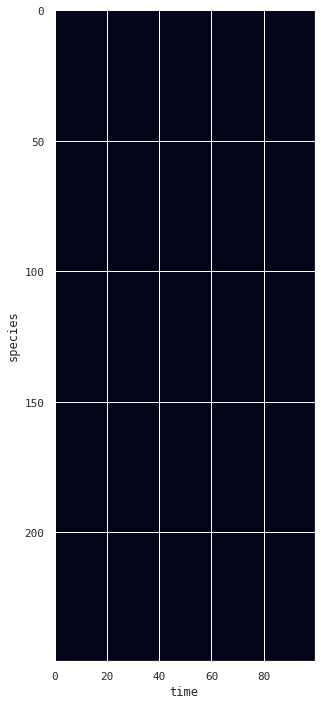

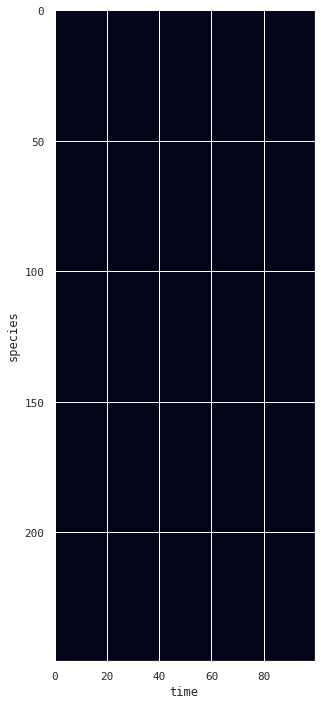

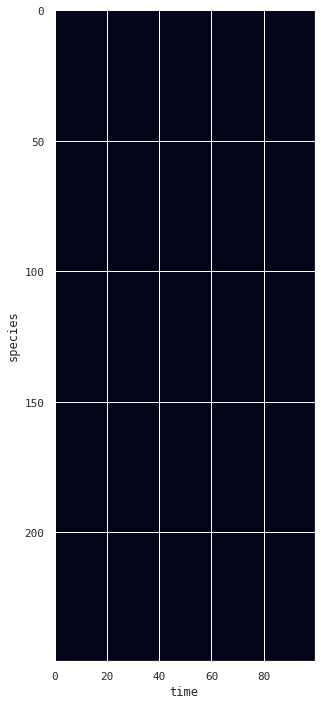

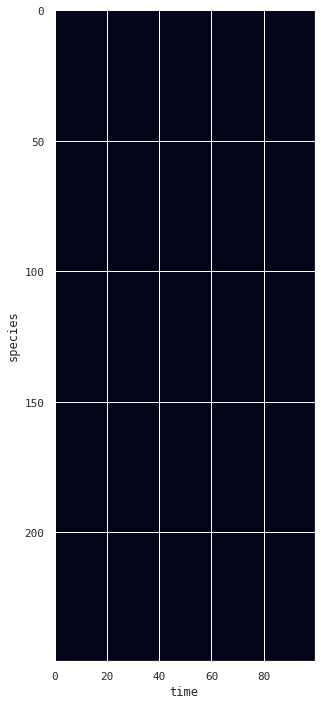

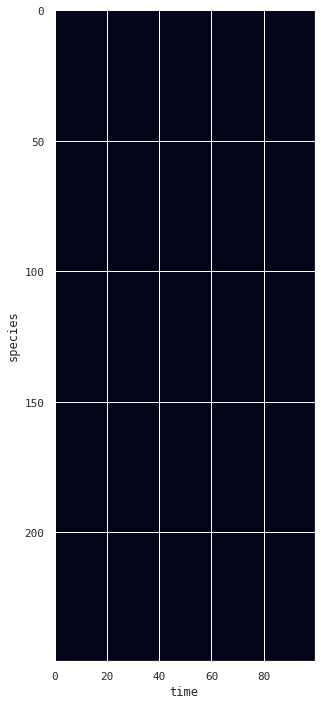

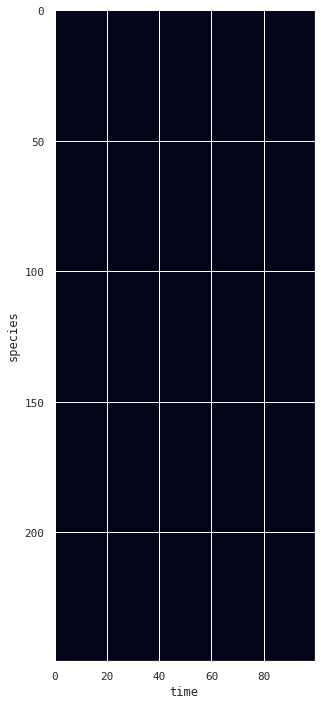

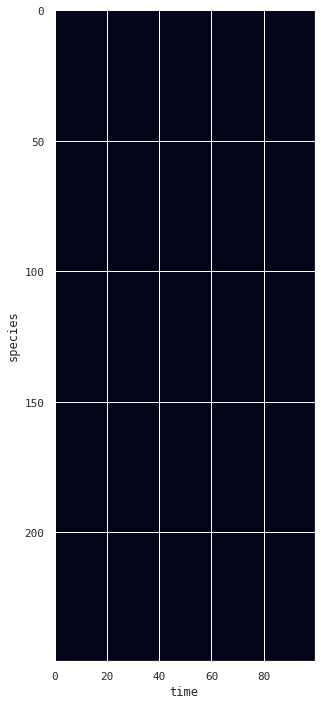

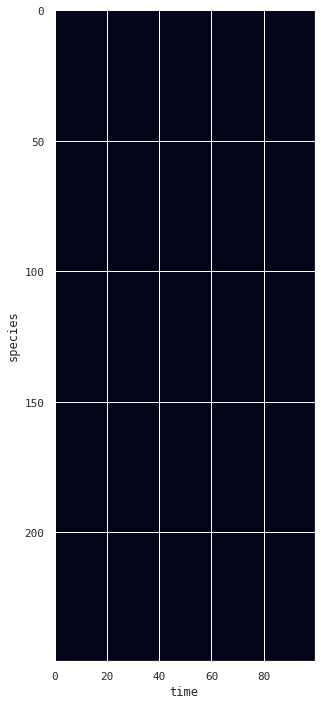

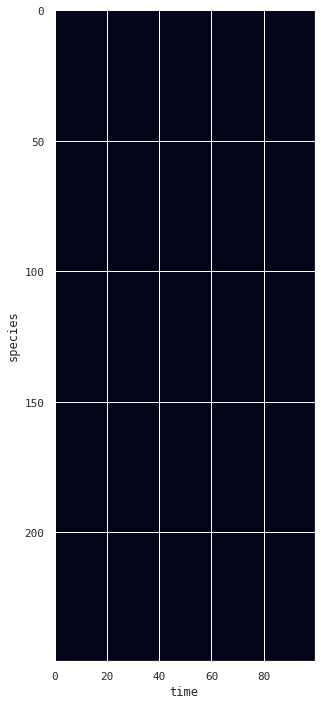

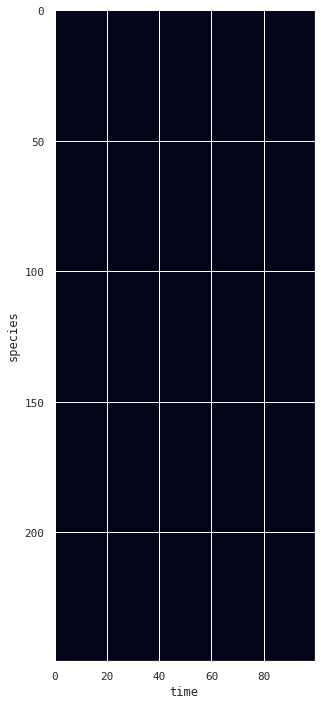

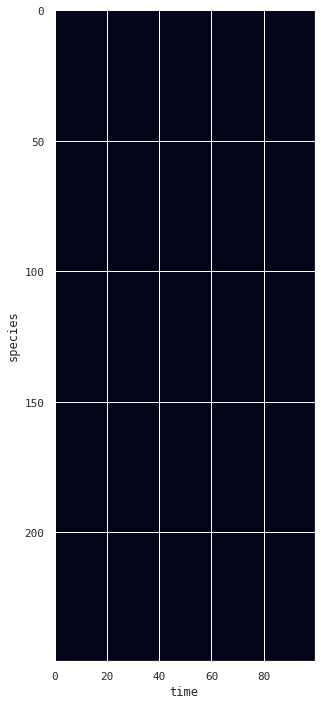

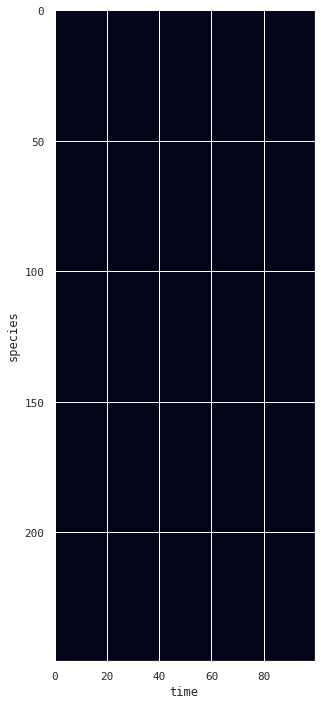

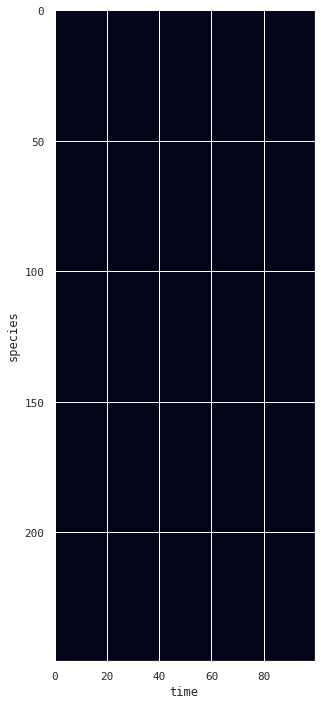

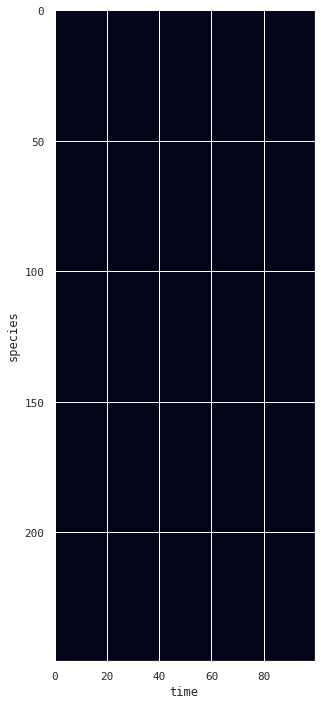

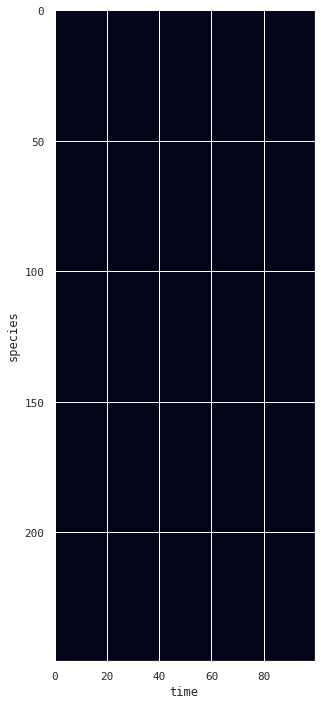

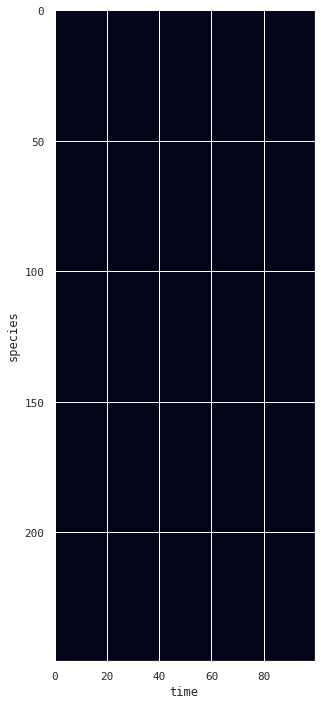

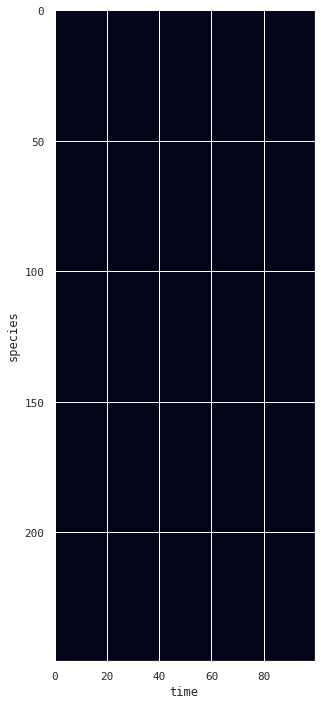

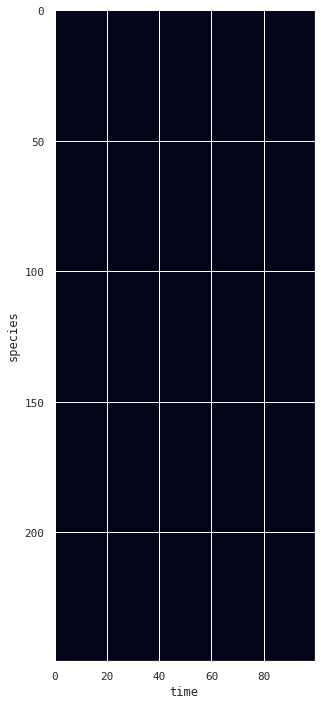

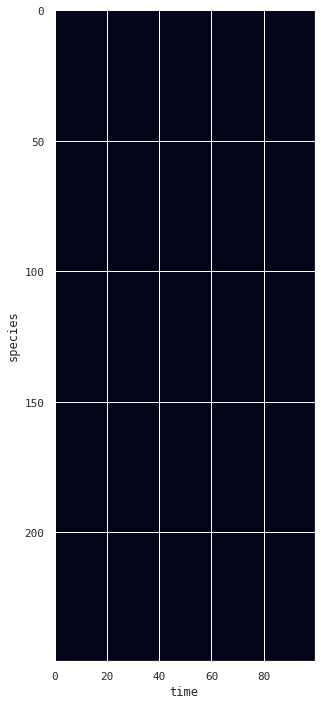

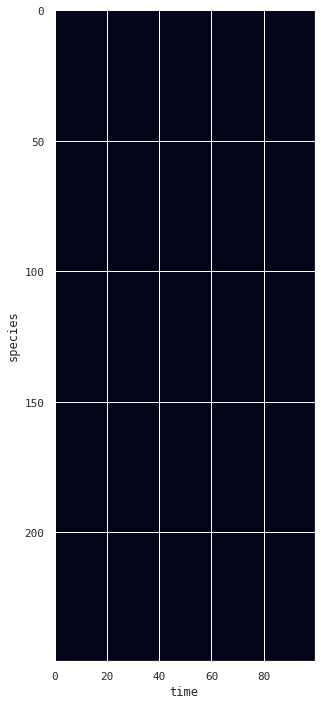

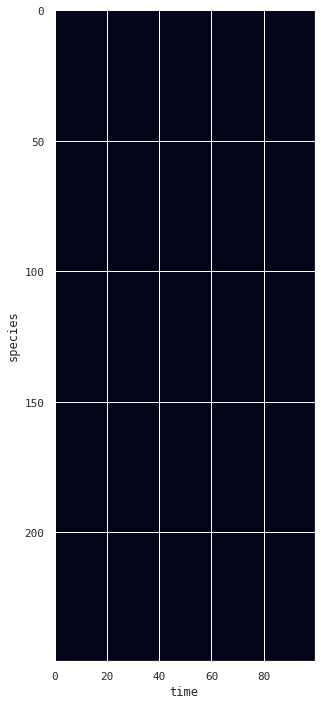

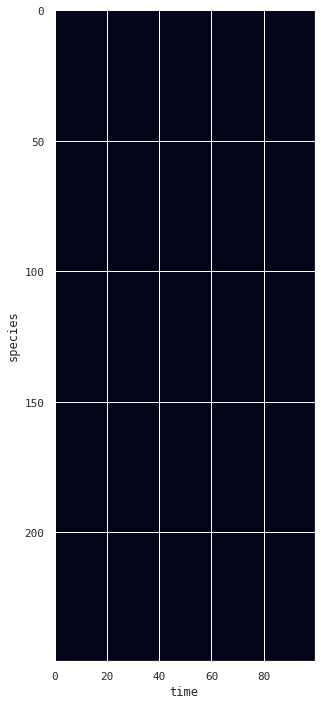

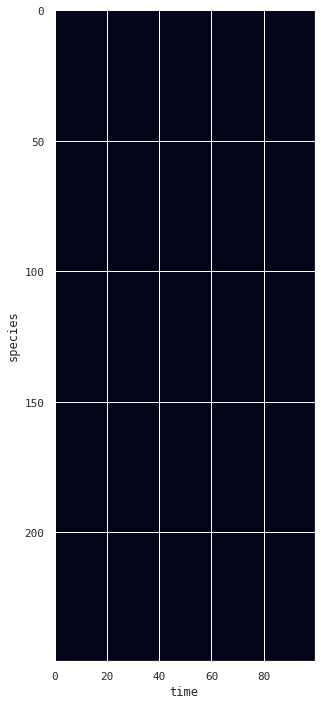

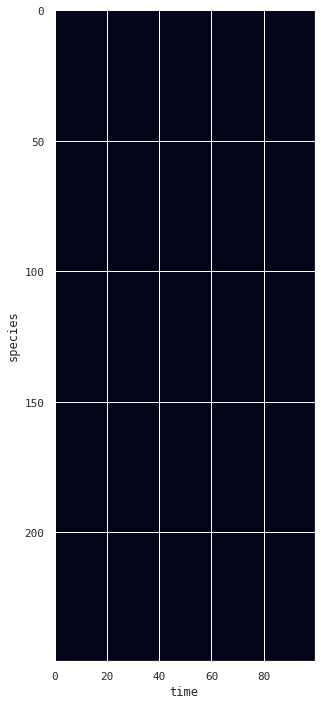

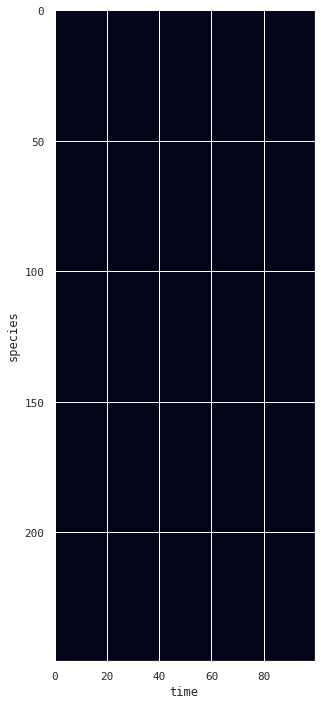

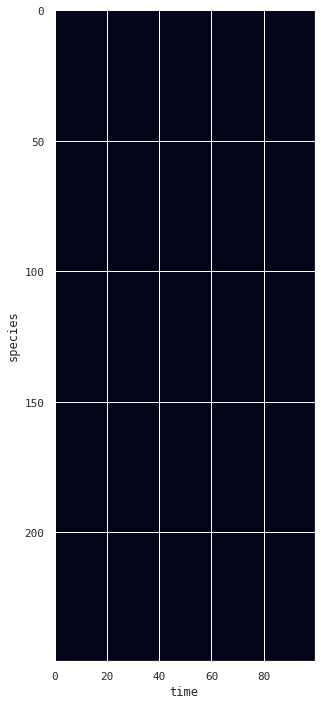

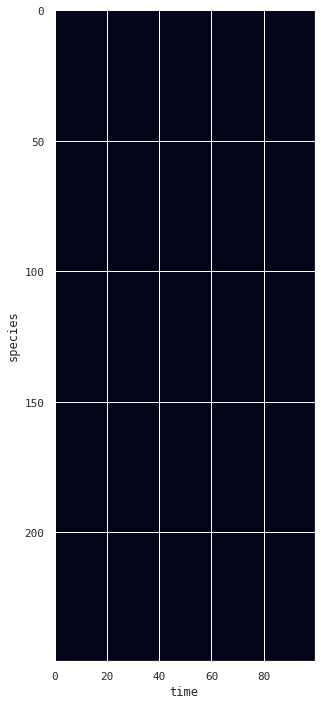

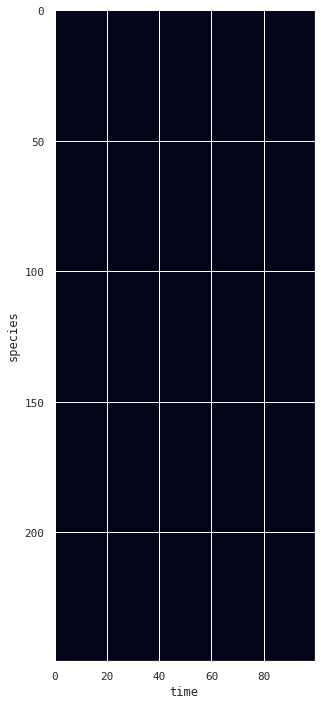

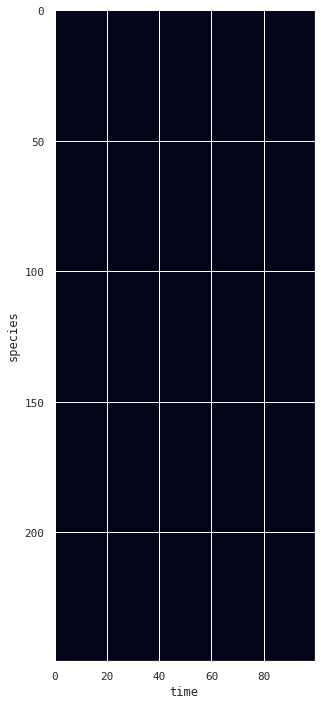

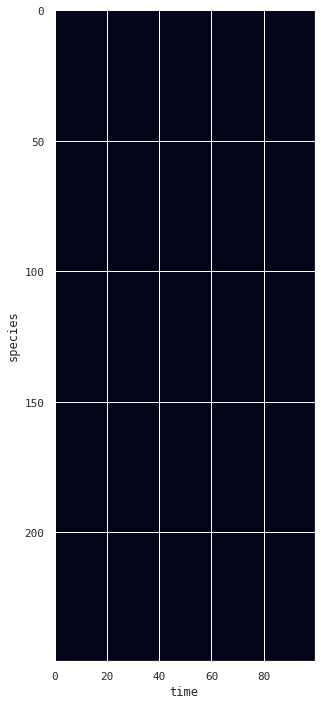

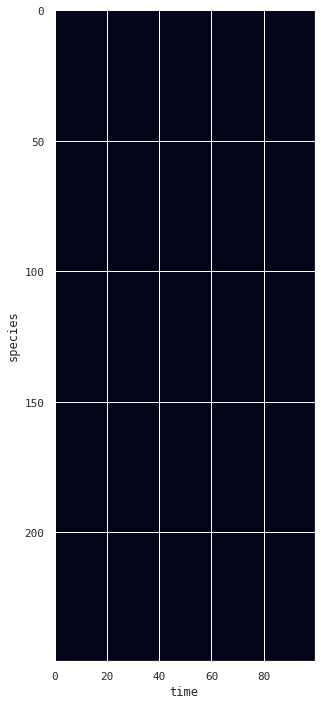

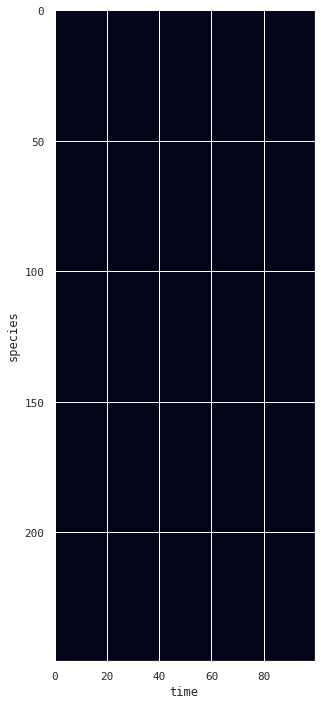

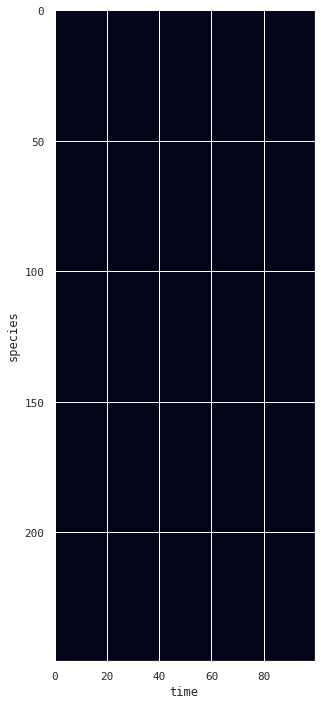

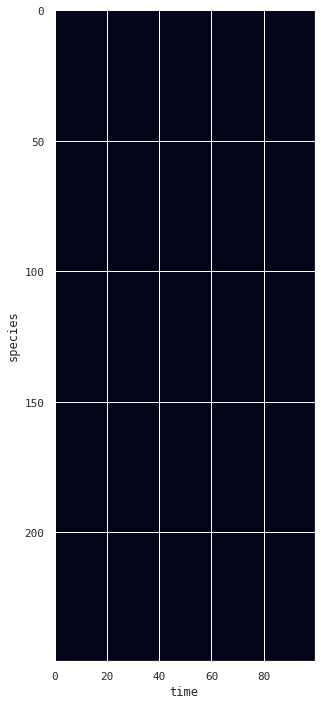

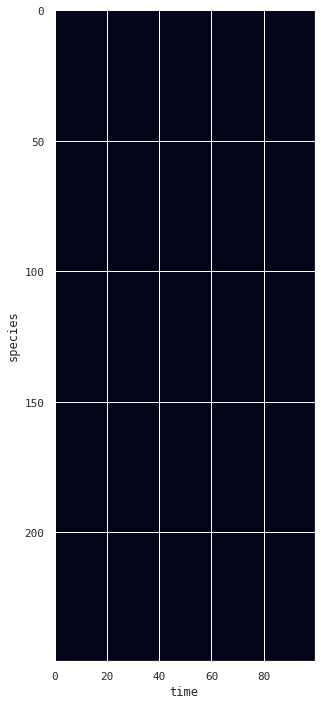

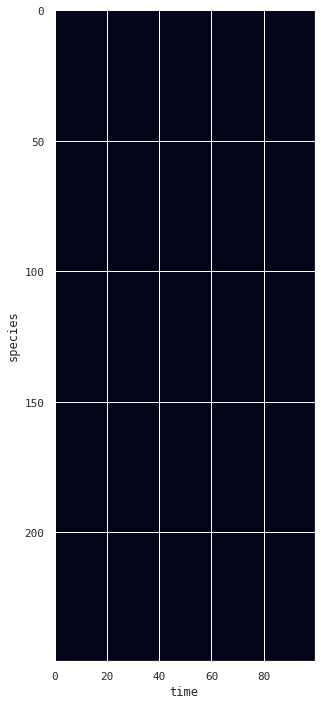

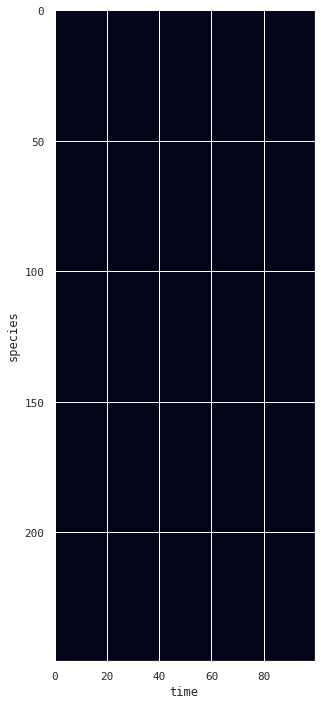

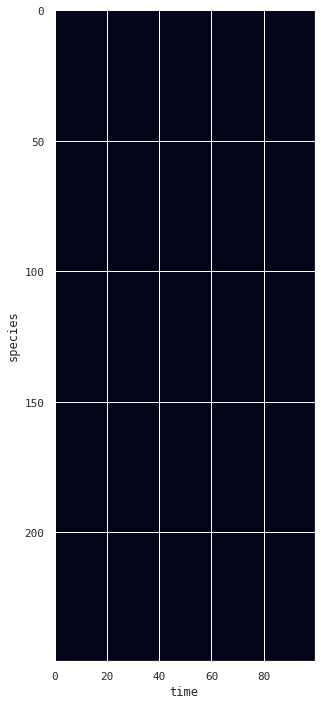

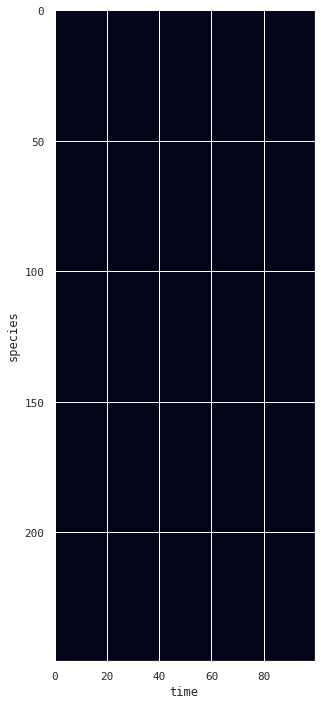

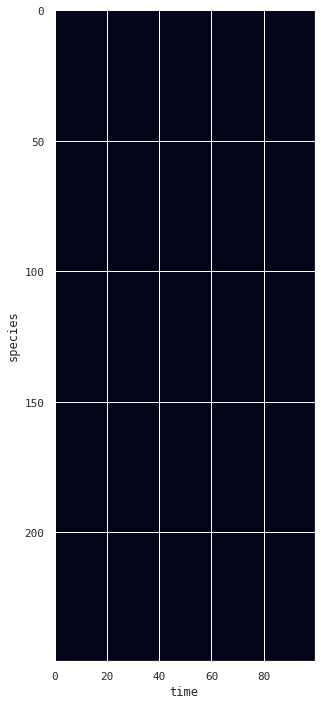

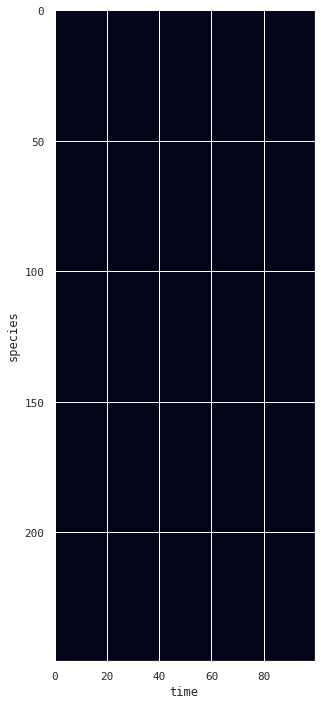

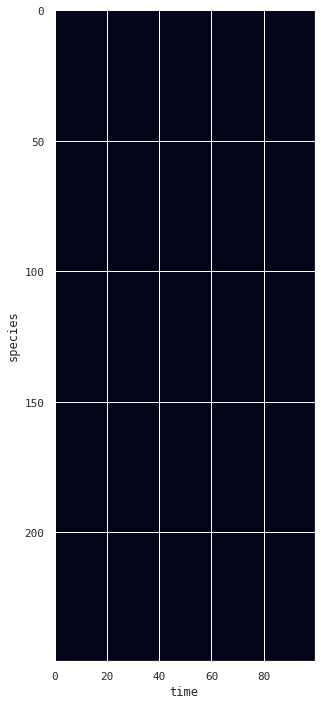

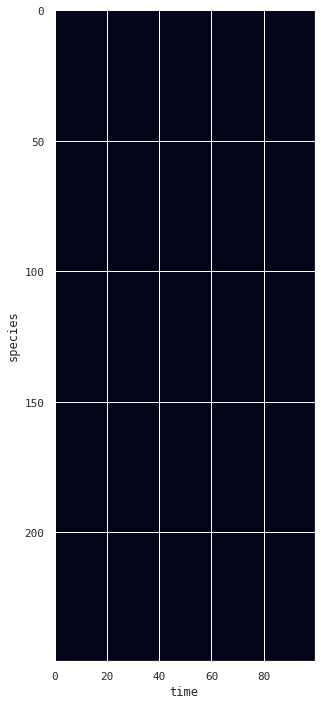

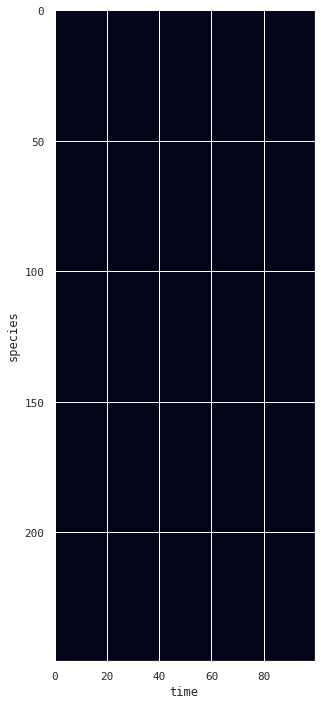

In [93]:
resultSave4 = []
for i in range(0, 100):
    interactionMatrix4, leaves_name4 = Hypothesis4(C_tree, sigma_hp4, Constant)
    sample4 = simulation(len(leaves), interactionMatrix4, 0.00001, 'z')
    resultSave4.append(plot_dieout(sample4))
print(resultSave4)

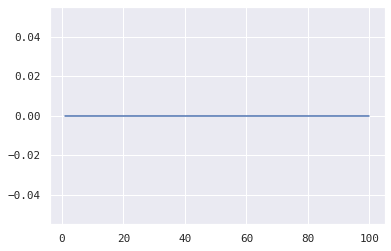

In [94]:
plt.plot([x for x in range(1,101)], resultSave4)

In [17]:
seaborn_plot(InteractionMatrix1, leaves, distMatrix)

ValueError: Shape of passed values is (499, 499), indices imply (250, 250)

Node 'n0' initialized
Interaction 'n0->n0' added
set m:(n0)->(n0):   0:250    0:250
Added x0 vector to node n0
Added growth rates to node n0
Initialized


(-15.0, 15.0)

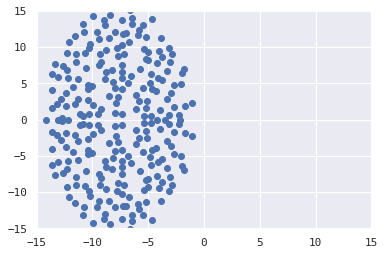

In [60]:
# Test purpose
gen = OmicsGenerator([250], init_full=True)
eigvals, eigvecs = np.linalg.eig(gen.get('n0->n0').matrix)

plt.scatter(np.real(eigvals), np.imag(eigvals))

plt.xlim([-15,15])
plt.ylim([-15,15])

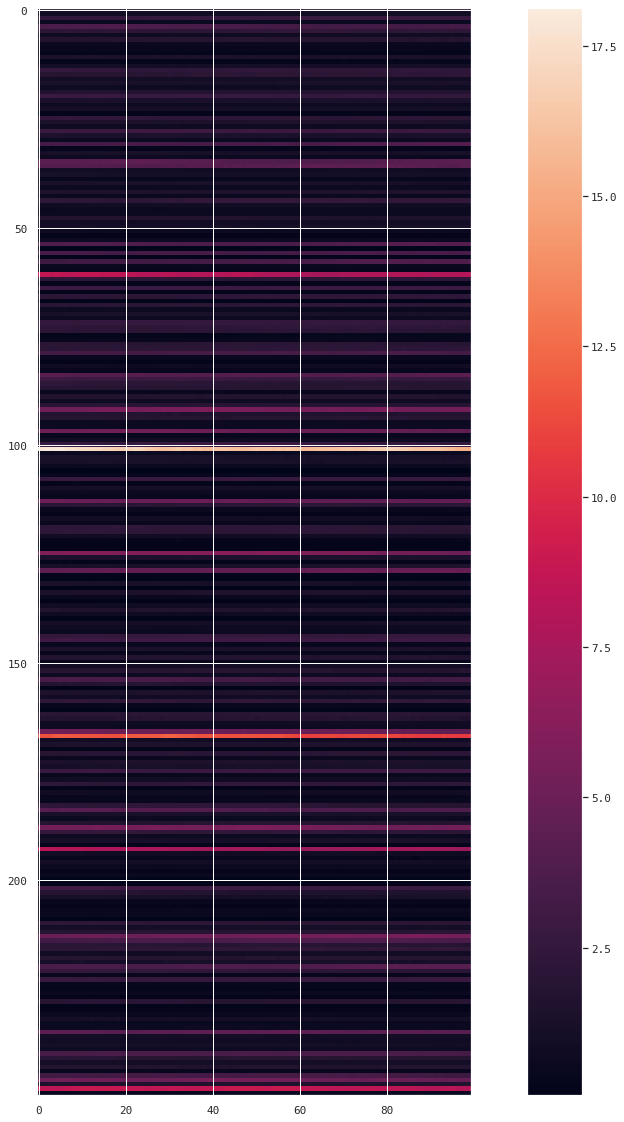

In [74]:
z,x,y = gen.generate(dt=.00001)
sample = z['n0']
fig = plt.figure(figsize=(20,20))
plt.imshow(sample.T)
plt.colorbar()

OK


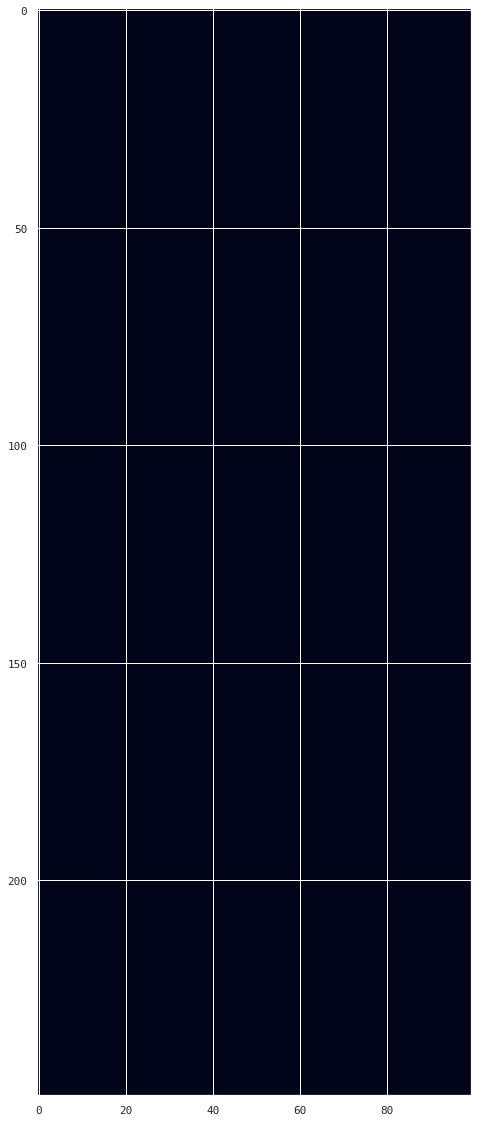

In [76]:
sample_zeros = (sample == 0)

fig = plt.figure(figsize=(20,20))
plt.imshow(sample_zeros.T)